# Handling of Outliers and NaNs

In [1]:
import os
import sys

sys.path.append('..')

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
from copy import deepcopy

from utils.functions.normalize_string import normalize_string

In [2]:
data_folder = os.path.join('..', "data")
utils_folder = os.path.join('..', "utils")

interm_data_folder = os.path.join(data_folder, "Intermediate Data")

# Load Data

In [3]:
eb0_features_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Features_Lab.xlsx")
)

eb0_targets_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Targets_Lab.xlsx")
)

In [4]:
eb1_features_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Features_Lab.xlsx")
)

eb1_targets_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Targets_Lab.xlsx")
)

In [5]:
eb0_sensor_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Sensor.xlsx")
)

In [6]:
eb1_sensor_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Sensor.xlsx")
)

In [7]:
thms_df = pd.read_excel(os.path.join(interm_data_folder, "THMs.xlsx"))

In [8]:
# import feature mappings
with open(os.path.join(utils_folder, 'mappings', "eb0_features_mapping.json")) as f:
    eb0_features_mapping = json.load(f)
    
with open(os.path.join(utils_folder, 'mappings', "eb1_features_mapping.json")) as f:
    eb1_features_mapping = json.load(f)

In [9]:
'''
Per quanto riguarda outliers e missing values, ho deciso prima di rimuovere gli outliers
dato che per gestire i missing values utilizzo data imputation con KNN, che è molto sensibile
agli outliers.
Inoltre, prima di rimuovere gli outliers dai sensori, vengono prima rimossi i sample
che hanno un valore di ALARMA ESPECTRAL >= 3, e vengono rimossi anche quei valori = 0
per alcune variabili per le quali non è appurato che si tratta di un errore di misurazione.
Queste feature sono: index UV, Sulfats, Particules, pH, color, conductivity
 
Data imputation viene fatta solo sulle features e non sulle variabili target in quanto
imputare i valori di target potrebbe portare ad avere molto bias e quindi a risultati non realistici.
'''

'\nPer quanto riguarda outliers e missing values, ho deciso prima di rimuovere gli outliers\ndato che per gestire i missing values utilizzo data imputation con KNN, che è molto sensibile\nagli outliers.\nInoltre, prima di rimuovere gli outliers dai sensori, vengono prima rimossi i sample\nche hanno un valore di ALARMA ESPECTRAL >= 3, e vengono rimossi anche quei valori = 0\nper alcune variabili per le quali non è appurato che si tratta di un errore di misurazione.\nQueste feature sono: index UV, Sulfats, Particules, pH, color, conductivity\n \nData imputation viene fatta solo sulle features e non sulle variabili target in quanto\nimputare i valori di target potrebbe portare ad avere molto bias e quindi a risultati non realistici.\n'

# Ouliers

## Lab

### EB0

In [10]:
eb0_features_lab_df.columns = [
    normalize_string(c) for c in eb0_features_lab_df.columns
]

eb0_features_mapping = {
    normalize_string(k): v for k, v in eb0_features_mapping.items()
}

In [11]:
# NaN count per feature
print(eb0_features_lab_df.isna().sum() / len(eb0_features_lab_df) * 100)
print()
print('Total number of samples: ', len(eb0_features_lab_df))

Unnamed: 0                                 0.000000
DateTime                                   0.000000
Color                                     25.487365
Conductivitat a 20oC                       5.703971
Mercuri                                    7.364621
Quantitat més abundant de partícules    94.151625
Sulfats                                   84.187726
Temperatura                               61.227437
Terbolesa                                  5.703971
pH                                         5.703971
Índex UV                                 92.707581
dtype: float64

Total number of samples:  1385


<Axes: >

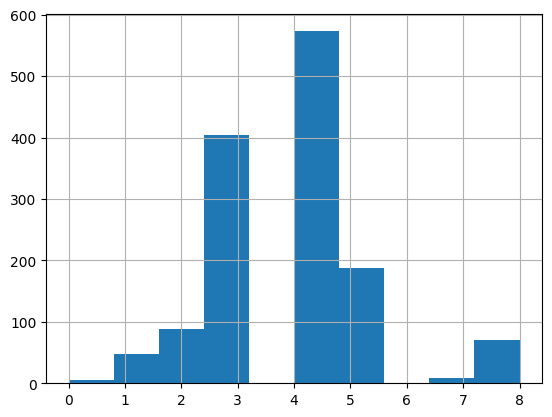

In [12]:
# NaN count per sample
eb0_features_lab_df.isna().sum(axis=1).hist()

In [13]:
# count of the samples with zero NaNs
(eb0_features_lab_df.isna().sum(axis=1) == 0).sum()

5

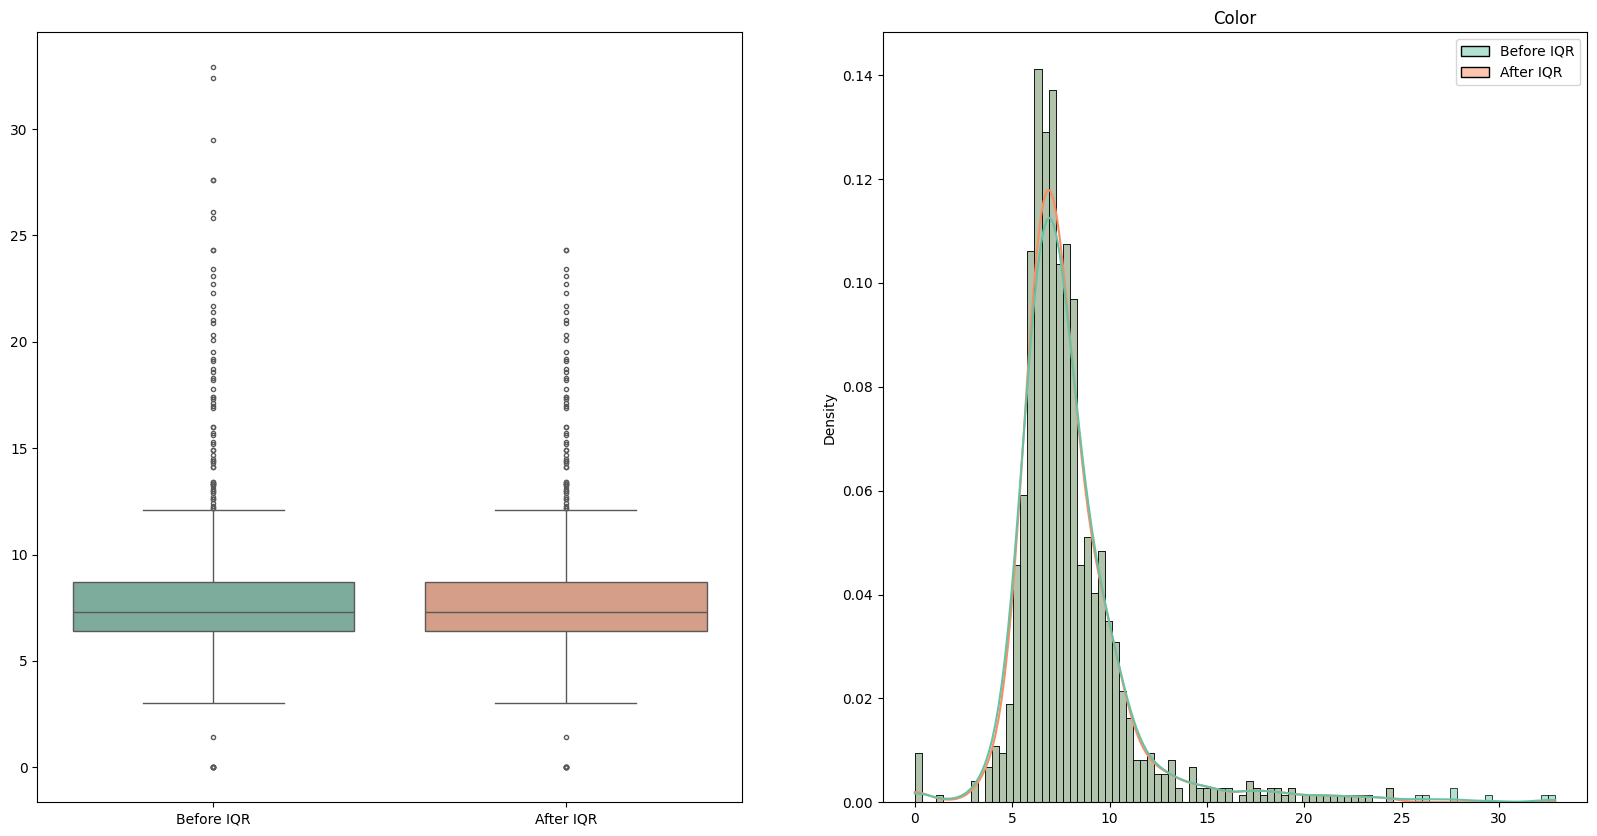

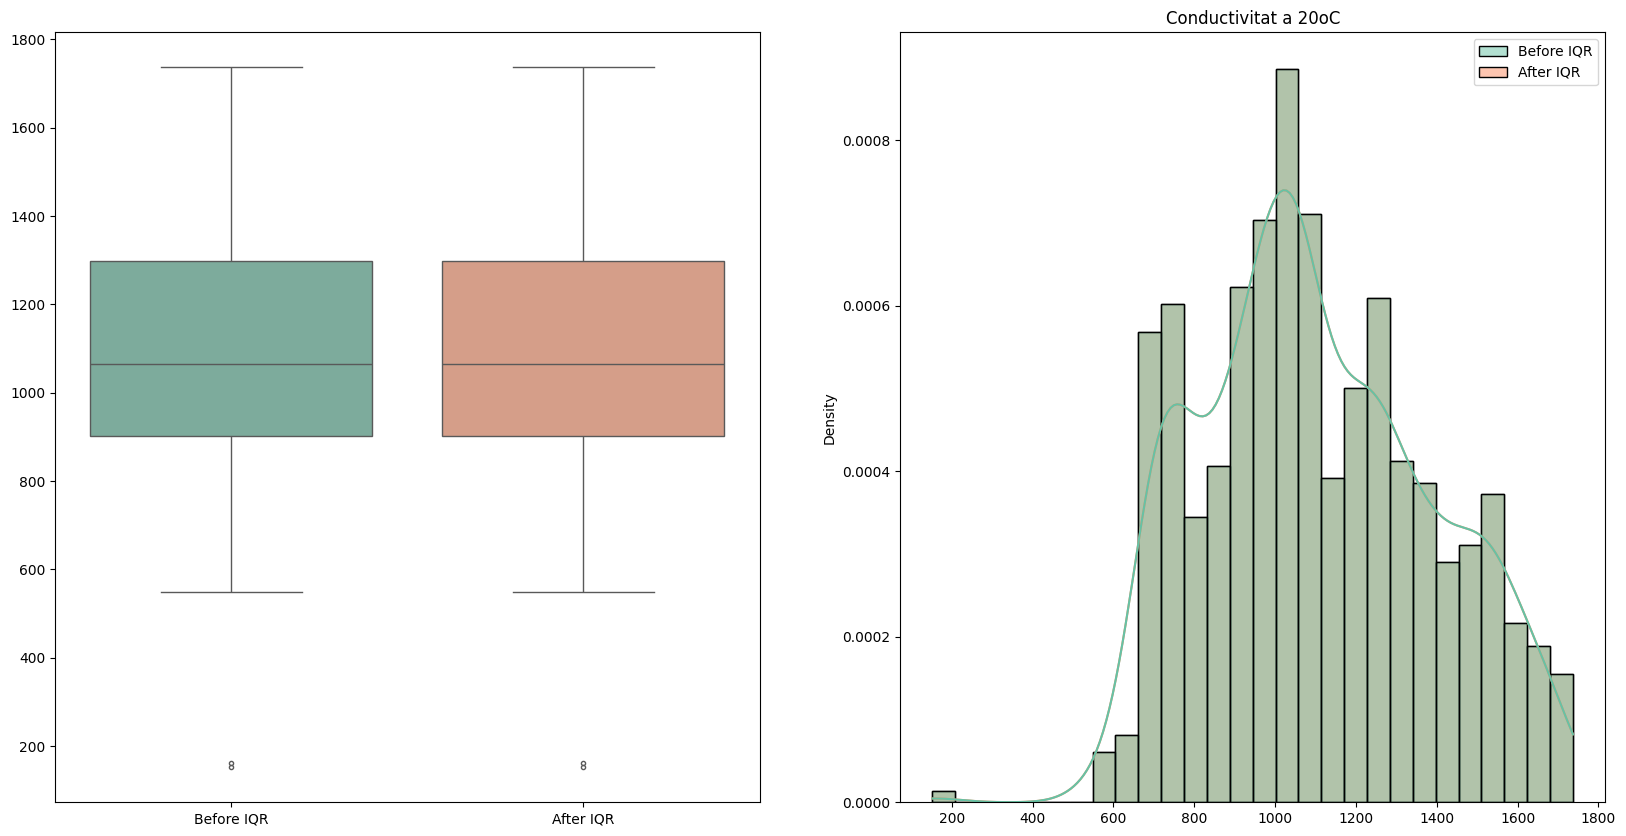

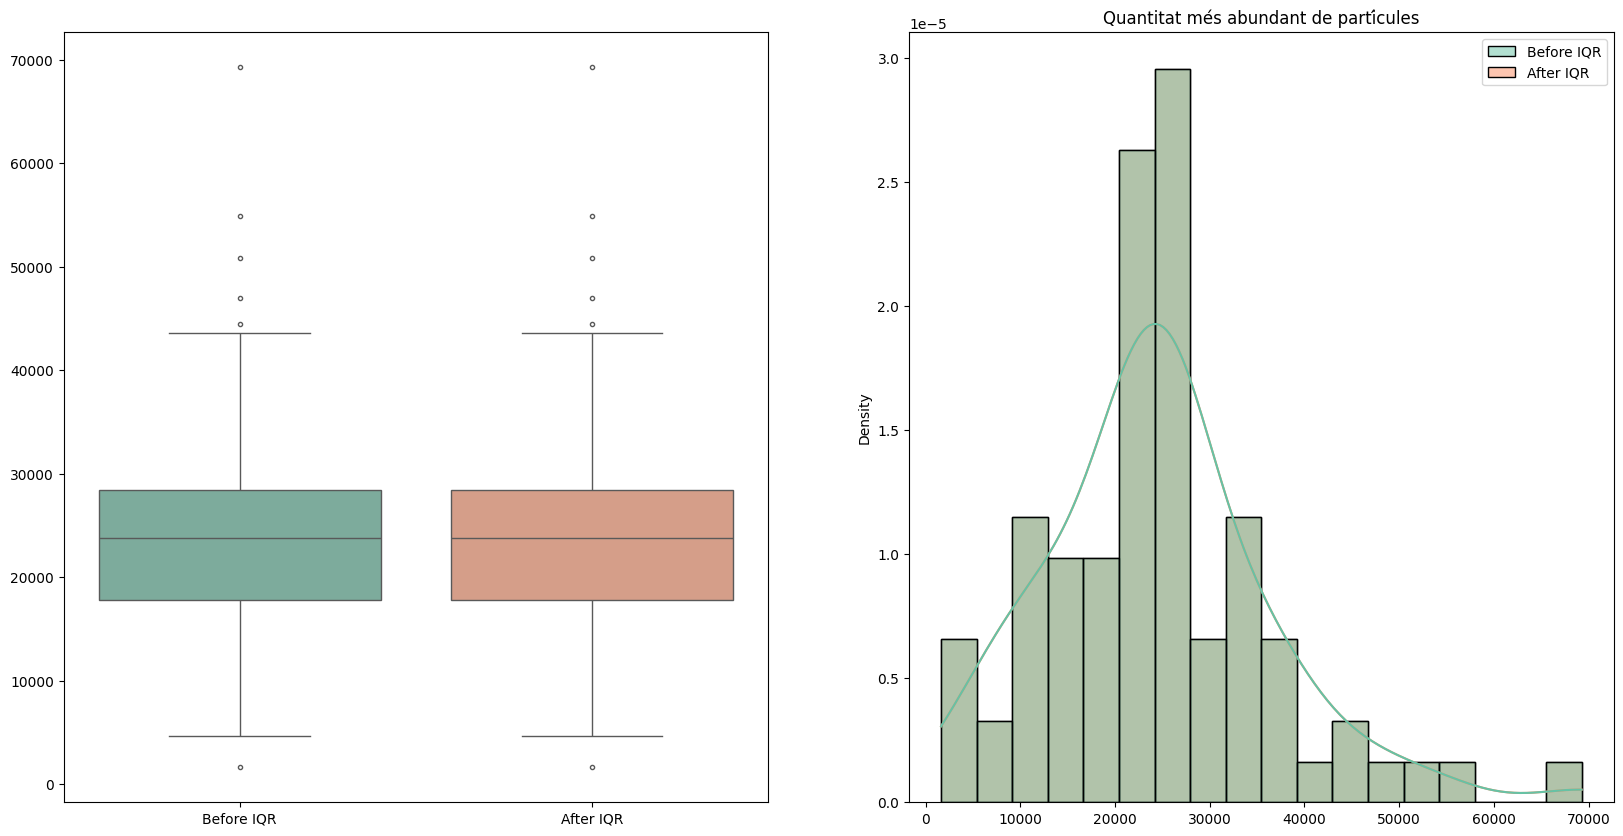

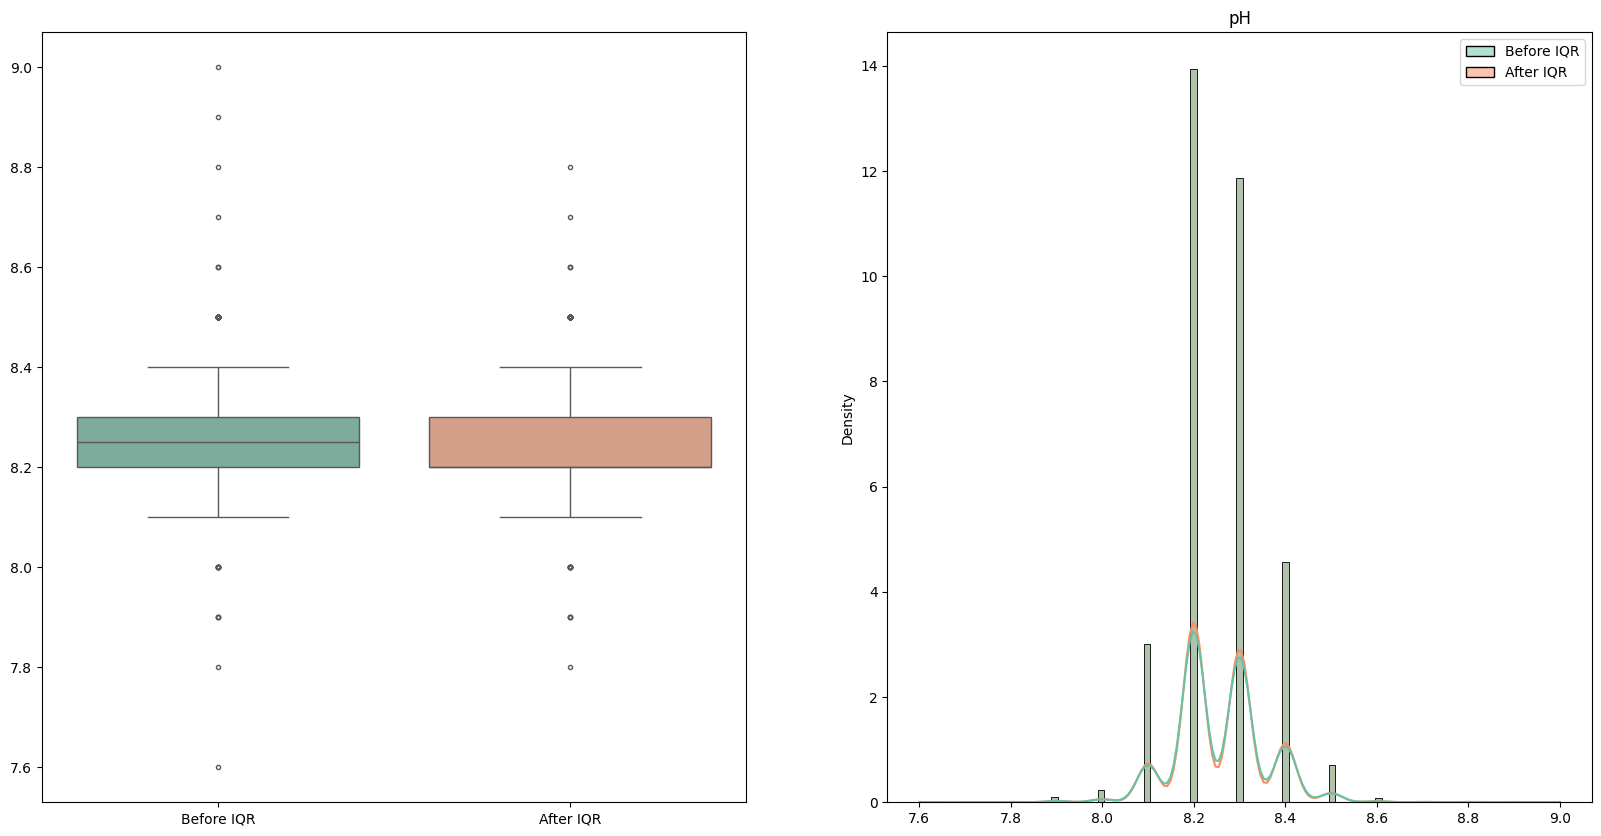

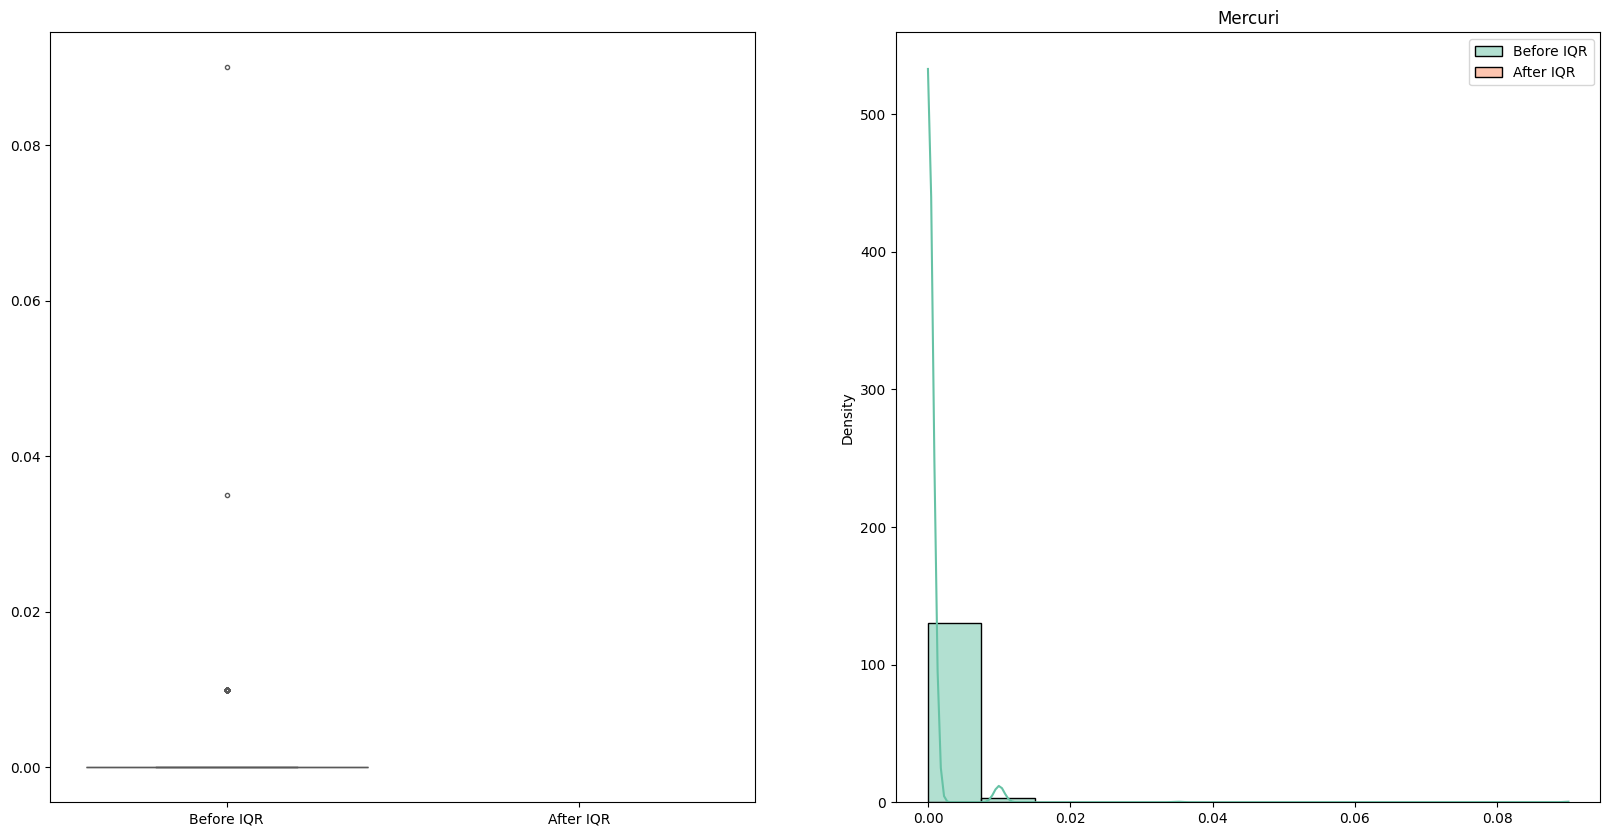

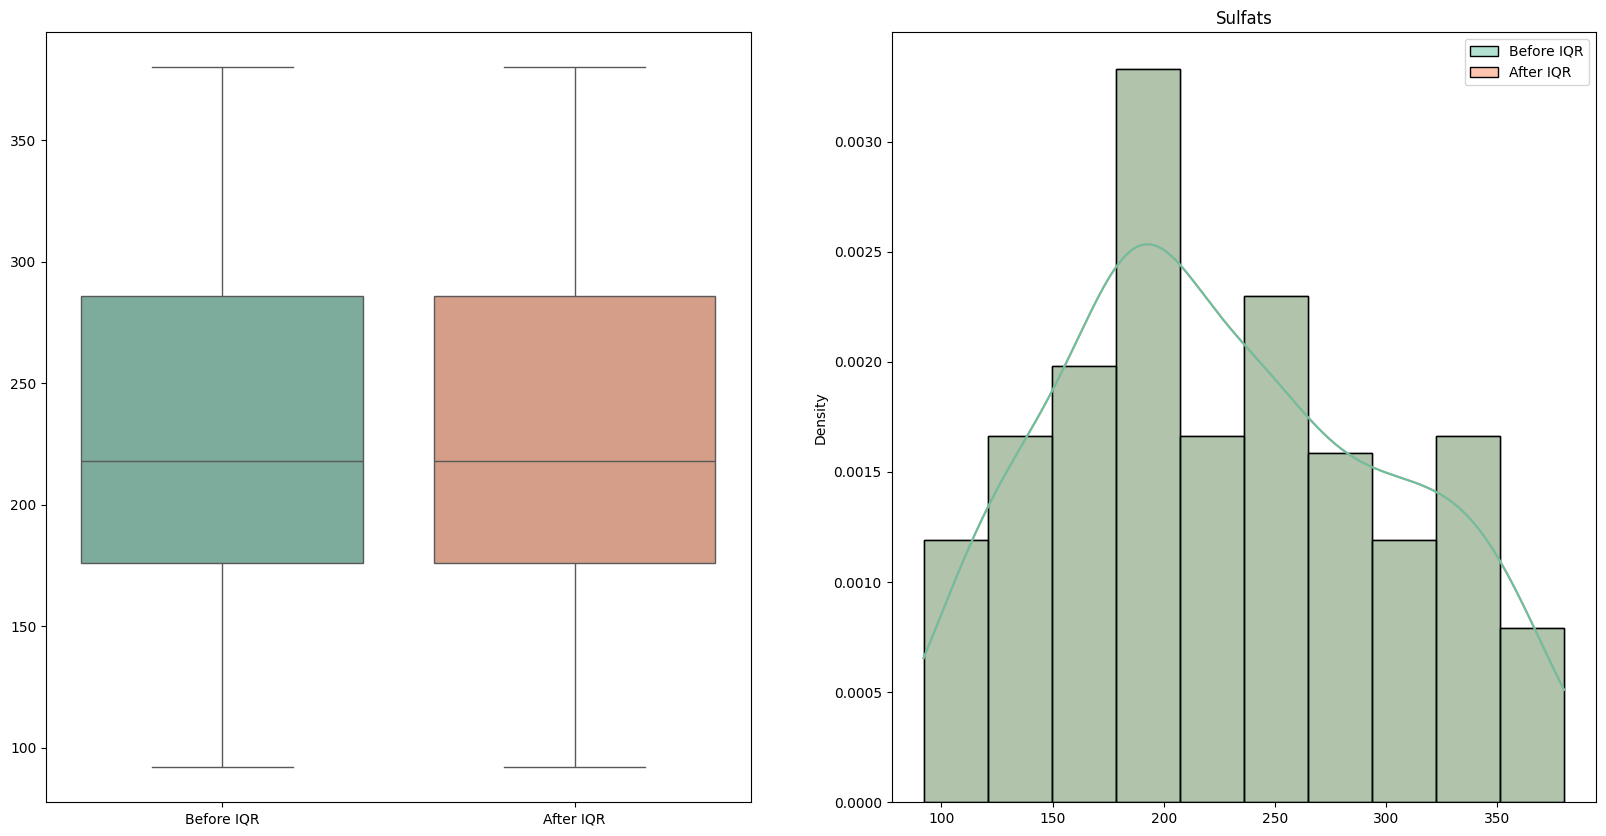

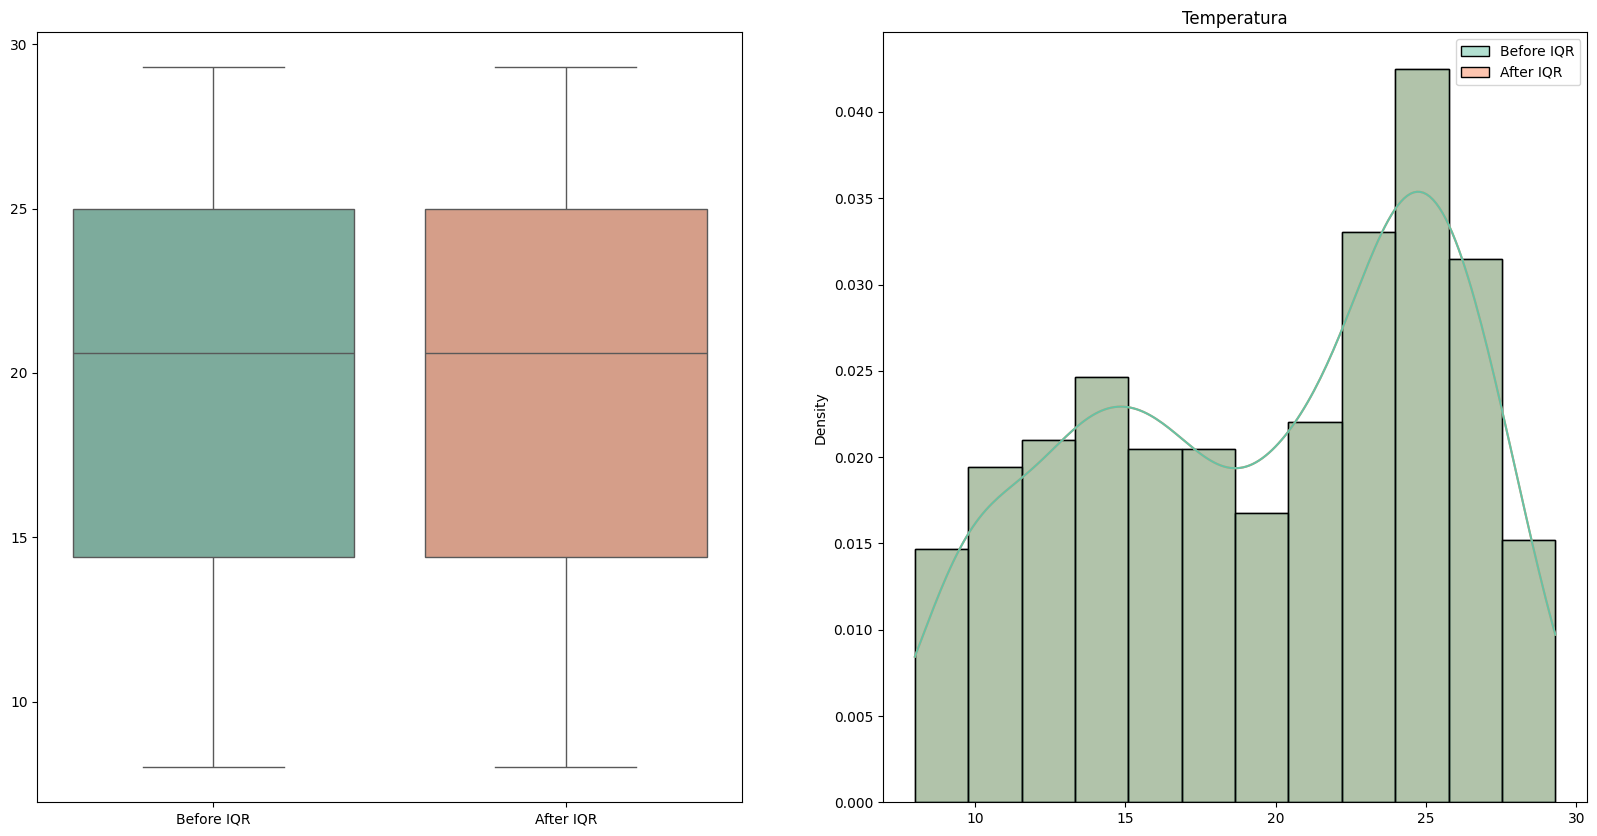

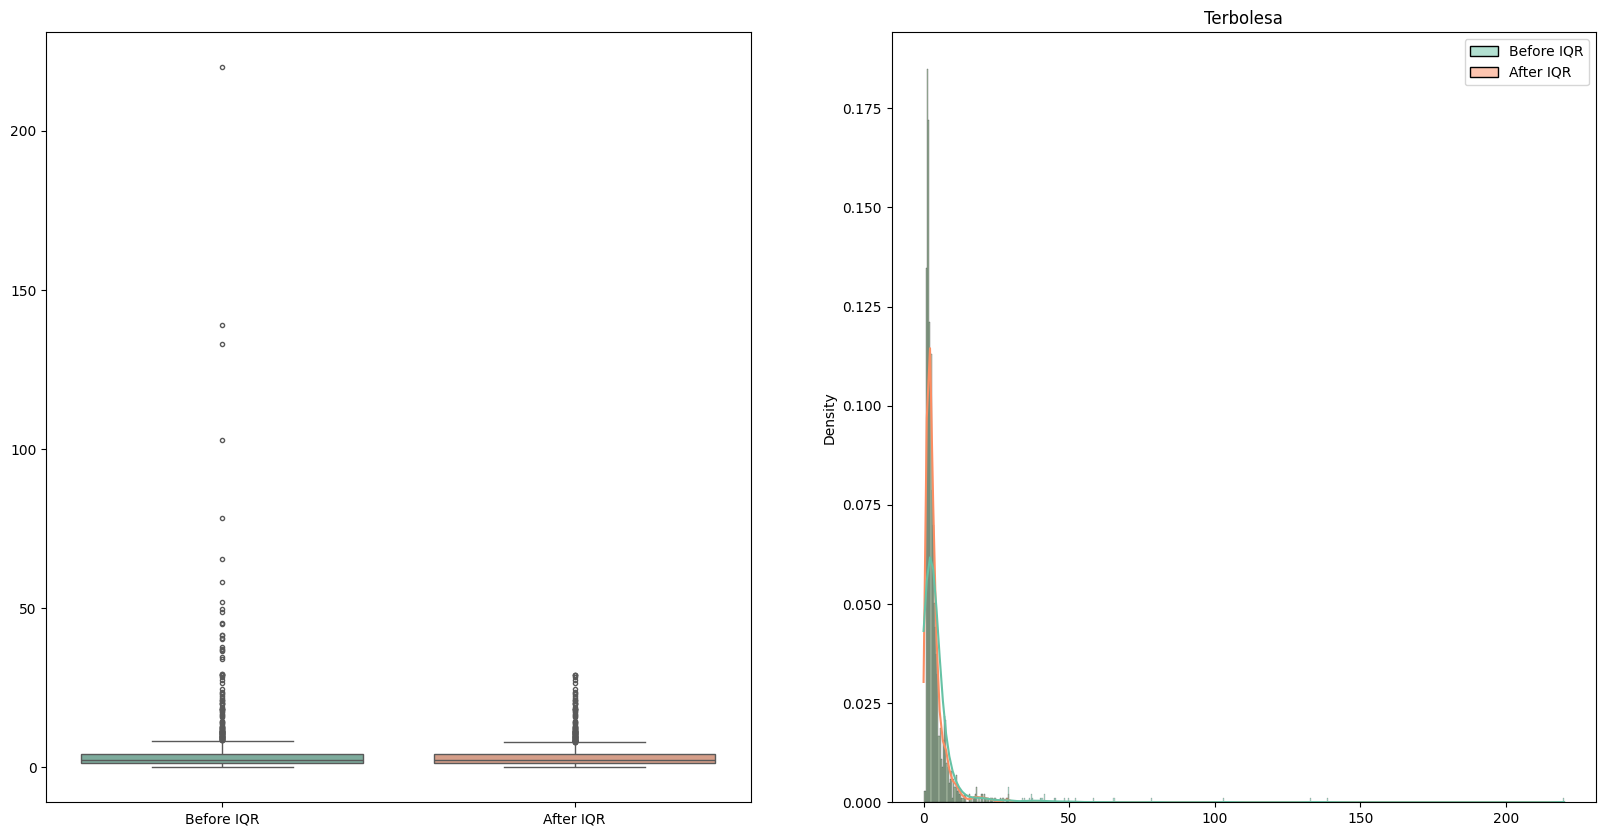

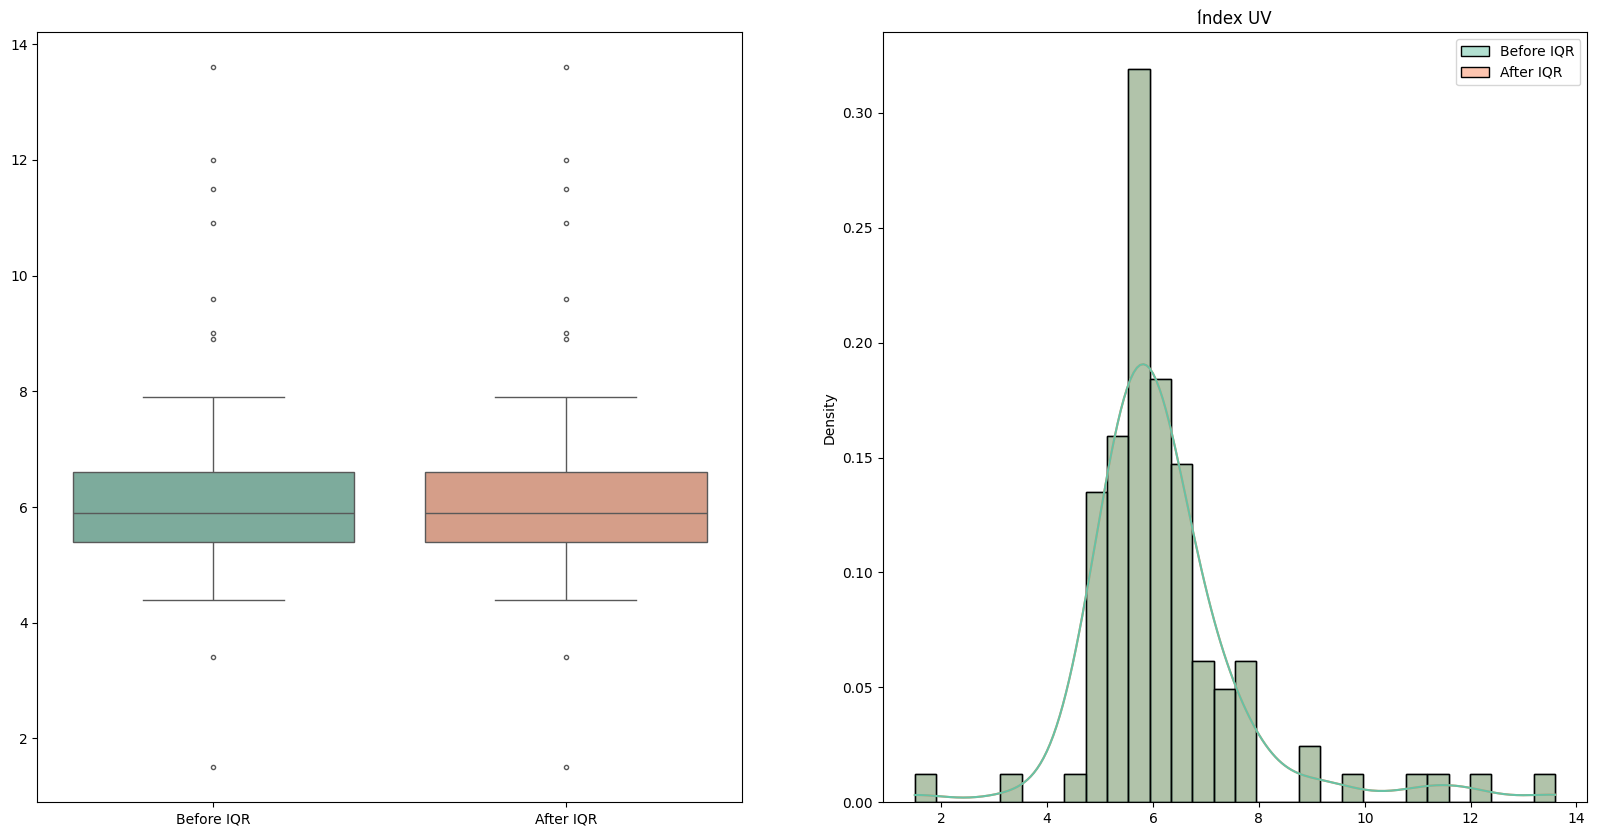

In [14]:
# Try combinations with and without zeros
# Outliers are removed using the IQR method with 0.05 and 0.95 quantiles,
# since the lab dataset is small and not much noisy

for lab_key in eb0_features_mapping.keys():

    quartile1, quartile3 = eb0_features_lab_df[lab_key].quantile([0.05, 0.95])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    # Create a temporary DataFrame with the column values before and after the IQR operation
    temp_df = pd.DataFrame(
        {
            "Before IQR": eb0_features_lab_df[lab_key],
            "After IQR": eb0_features_lab_df[lab_key].apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
                ),
        }
    )

    # Plot the temporary DataFrame
    
    fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
    
    sns.boxplot(
        data=temp_df,
        palette="Set2",
        saturation=0.5,
        whis=1.5,
        fliersize=3,
        ax=axs[0]
    )
    
    sns.histplot(
        data=temp_df,
        palette="Set2",
        kde=True,
        stat="density",
        ax=axs[1]
    )
    
    plt.title(lab_key)
    plt.show()

In [15]:
# Remove outliers
for lab_key in eb0_features_mapping.keys():

    quartile1, quartile3 = eb0_features_lab_df[lab_key].quantile([0.05, 0.95])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb0_features_lab_df[lab_key] = eb0_features_lab_df[lab_key].apply(
        lambda x: x if (x > lower_bound and x < upper_bound) else None
    )

In [16]:
# NaN count per feature
print(eb0_features_lab_df.isna().sum())
print()
print('Total number of samples: ', len(eb0_features_lab_df))

Unnamed: 0                                   0
DateTime                                     0
Color                                      360
Conductivitat a 20oC                        79
Mercuri                                   1385
Quantitat més abundant de partícules    1304
Sulfats                                   1166
Temperatura                                848
Terbolesa                                  103
pH                                          82
Índex UV                                 1284
dtype: int64

Total number of samples:  1385


<Axes: >

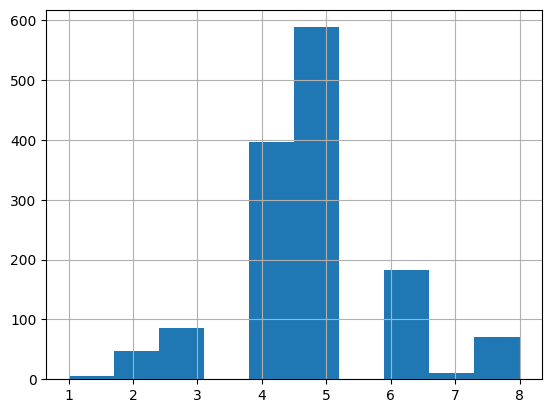

In [17]:
# NaN count per sample
eb0_features_lab_df.isna().sum(axis=1).hist()

In [18]:
# count of the samples with zero NaNs
(eb0_features_lab_df.isna().sum(axis=1) == 0).sum()

0

### EB1

In [19]:
eb1_features_lab_df.columns = [
    normalize_string(c) for c in eb1_features_lab_df.columns
]

eb1_features_mapping = {
    normalize_string(k): v for k, v in eb1_features_mapping.items()
}

In [20]:
# NaN count per feature
print(eb1_features_lab_df.isna().sum() / len(eb1_features_lab_df) * 100)
print()
print('Total number of samples: ', len(eb1_features_lab_df))

Unnamed: 0                                 0.000000
DateTime                                   0.000000
Carboni Orgànic Total Tractament         93.349398
Clor lliure residual                       5.349398
Color                                      5.975904
Conductivitat a 20oC                       5.686747
Quantitat més abundant de partícules    95.421687
Temperatura                               71.807229
Terbolesa                                  5.349398
pH                                         5.686747
Índex UV                                 93.060241
dtype: float64

Total number of samples:  2075


<Axes: >

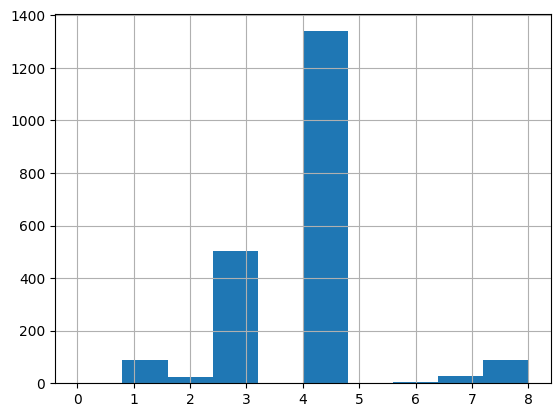

In [21]:
# NaN count per sample
eb1_features_lab_df.isna().sum(axis=1).hist()

In [22]:
# count of the samples with zero NaNs
(eb1_features_lab_df.isna().sum(axis=1) == 0).sum()

1

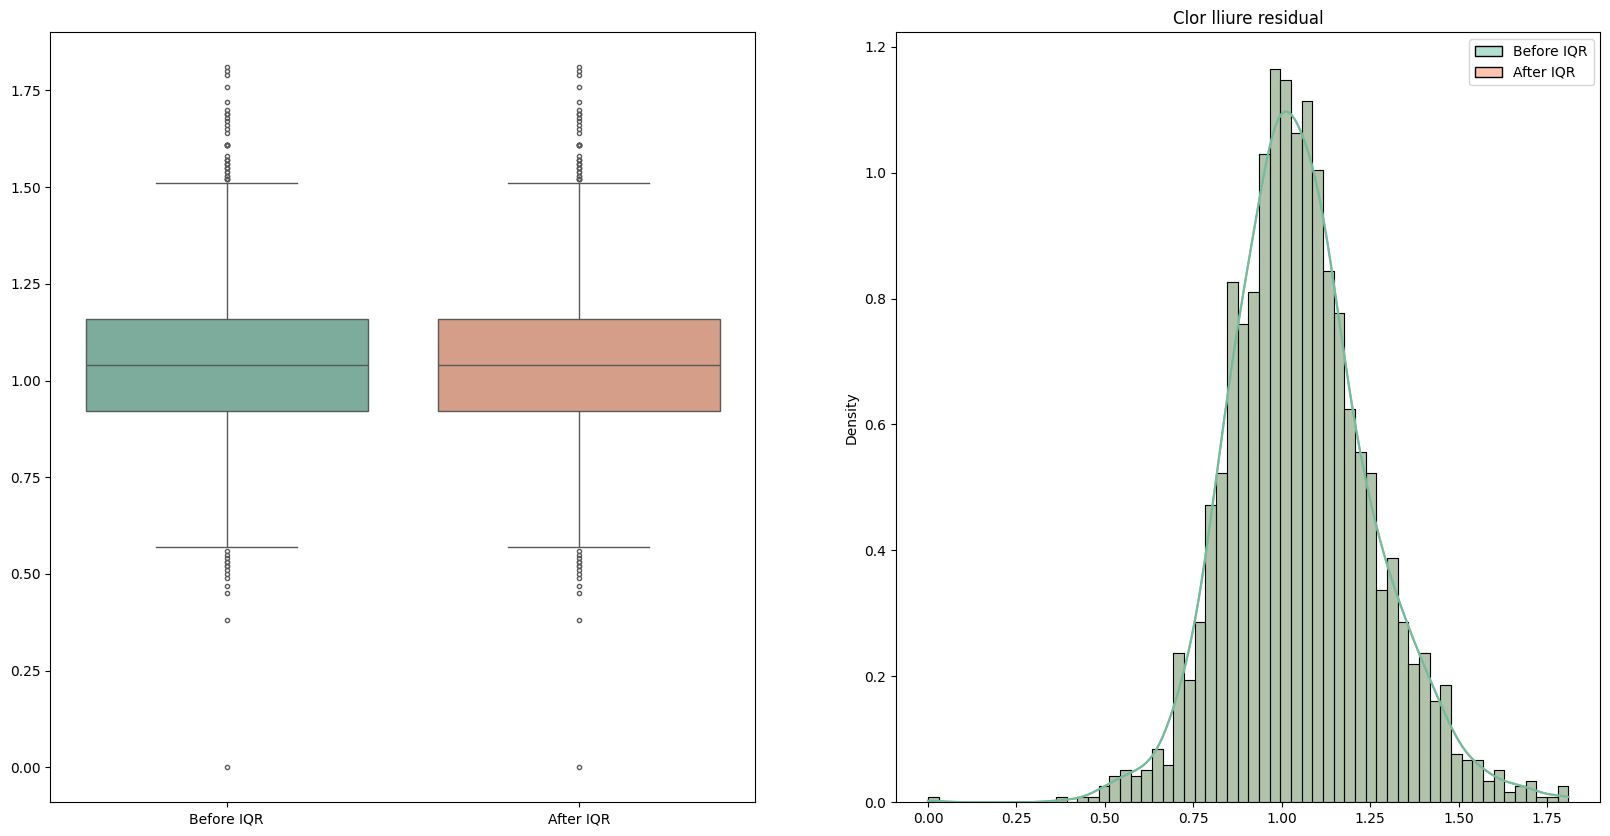

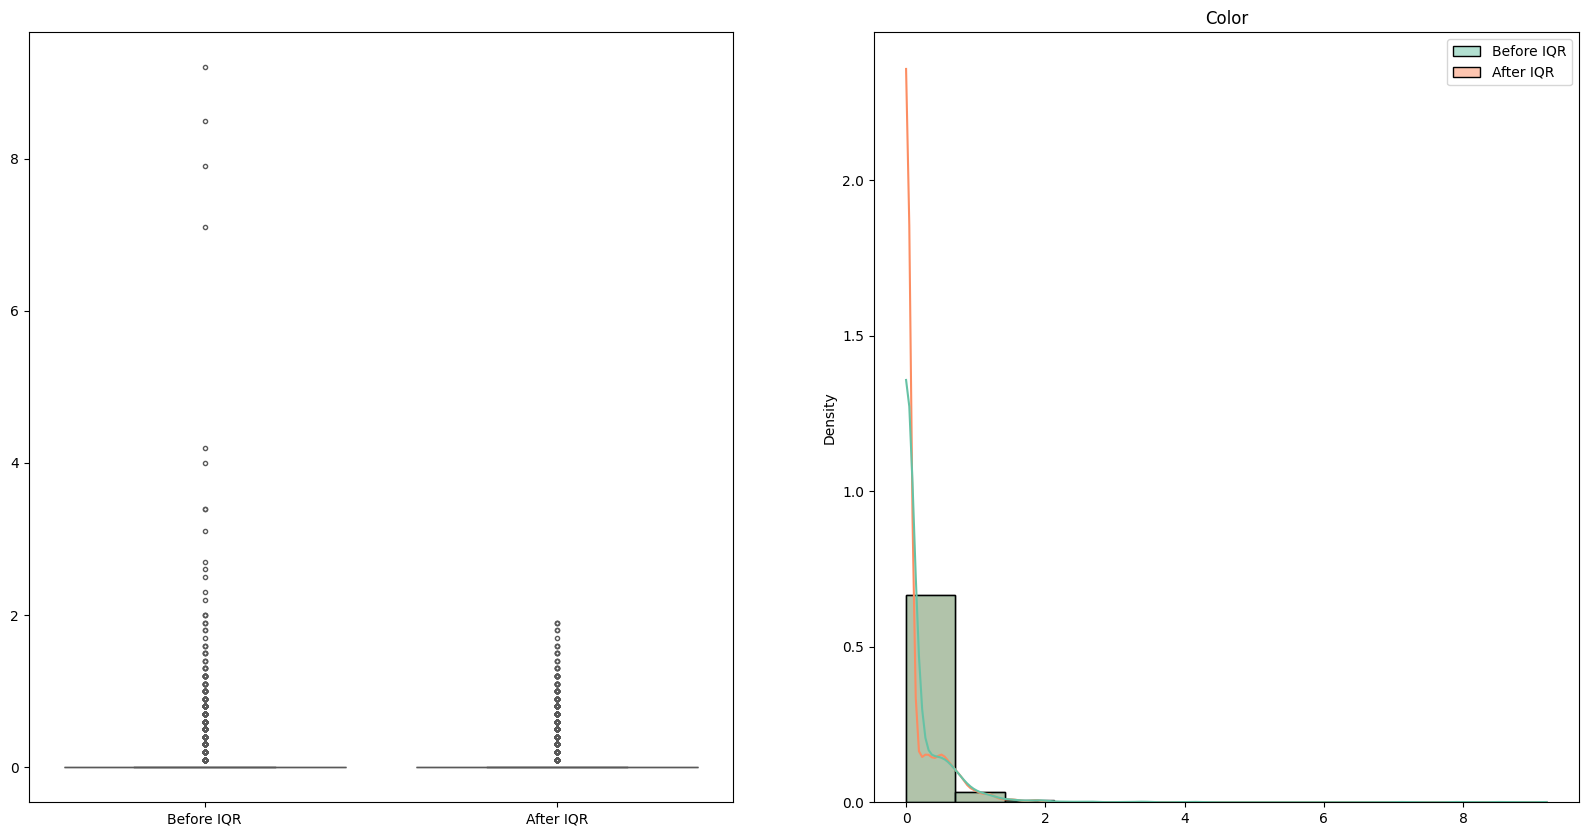

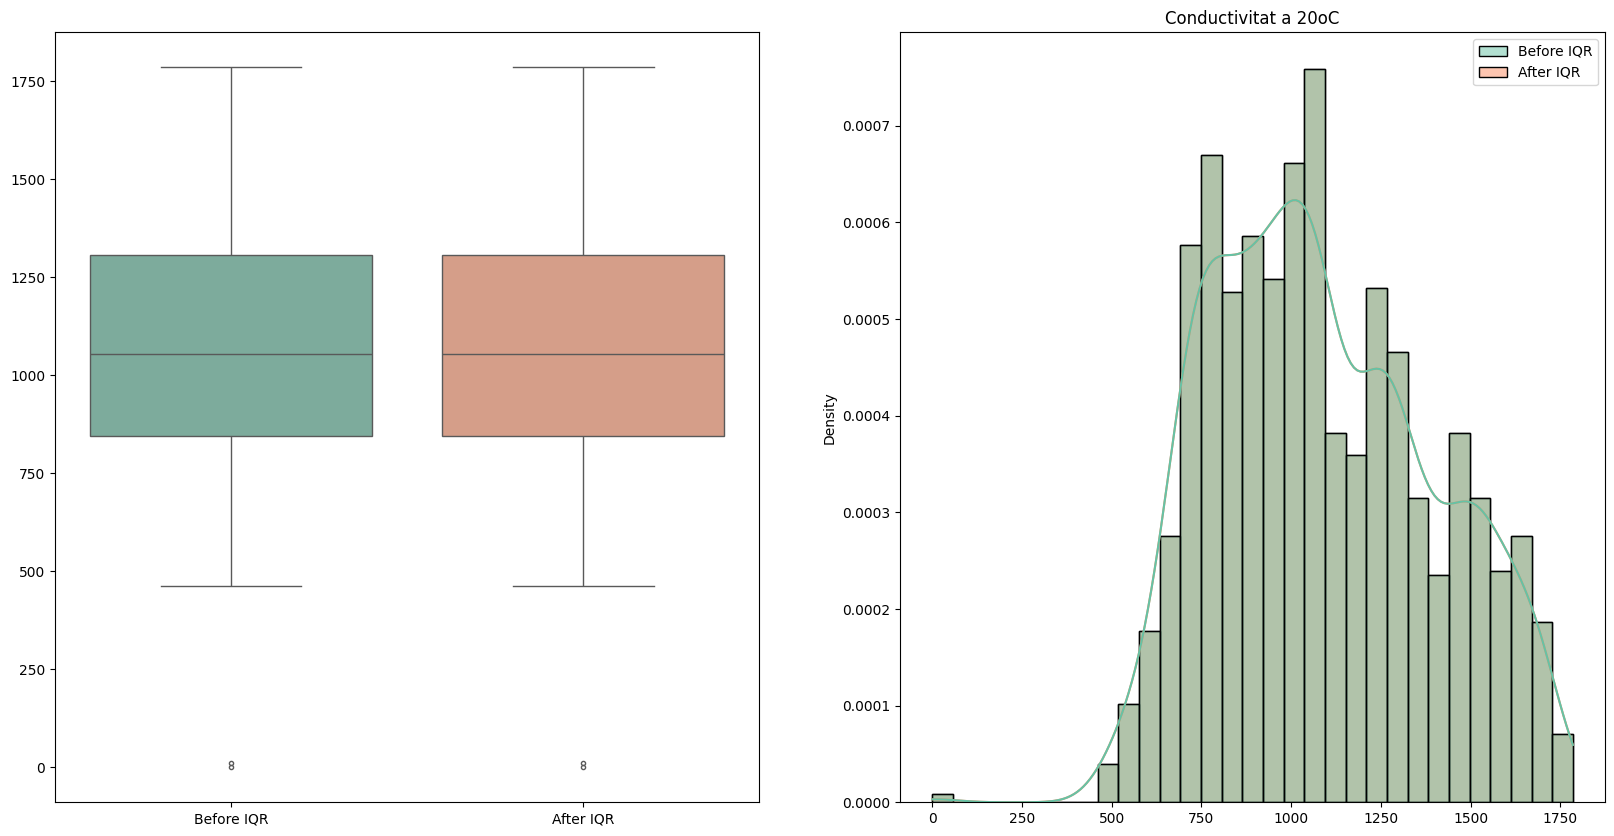

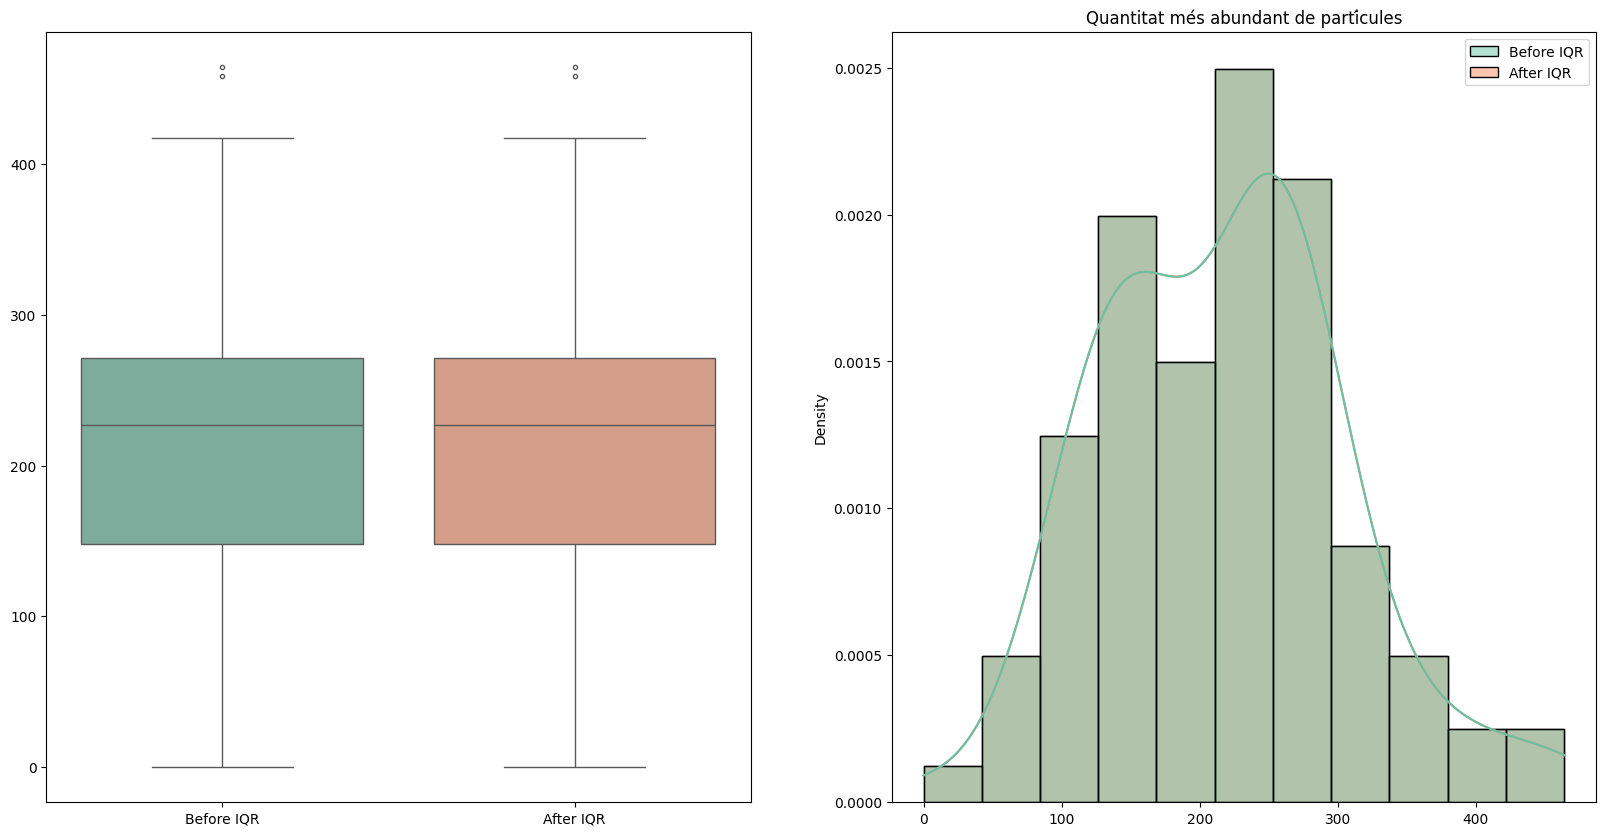

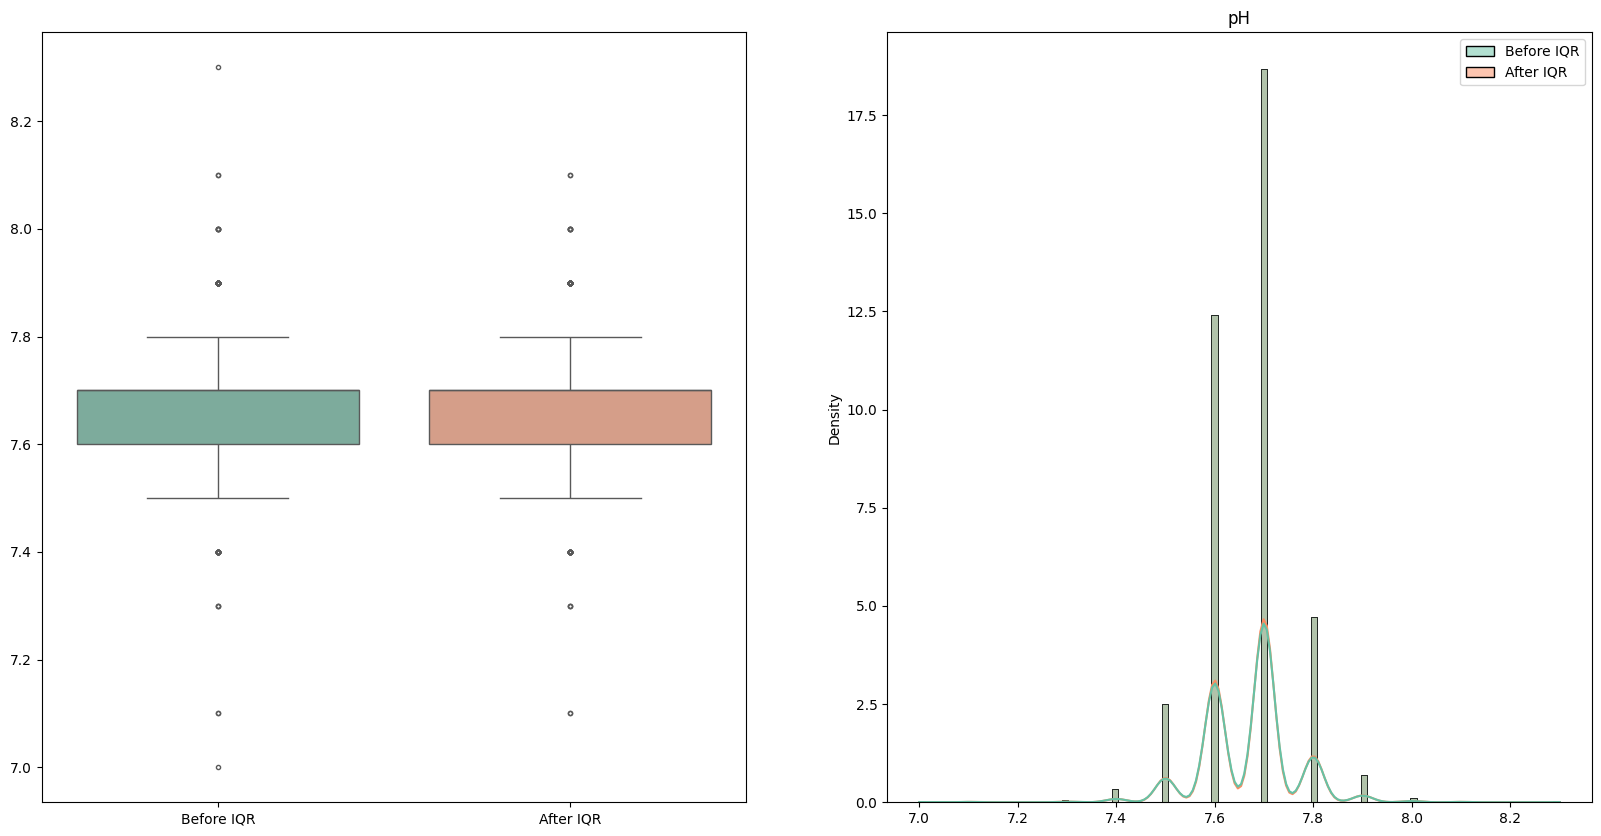

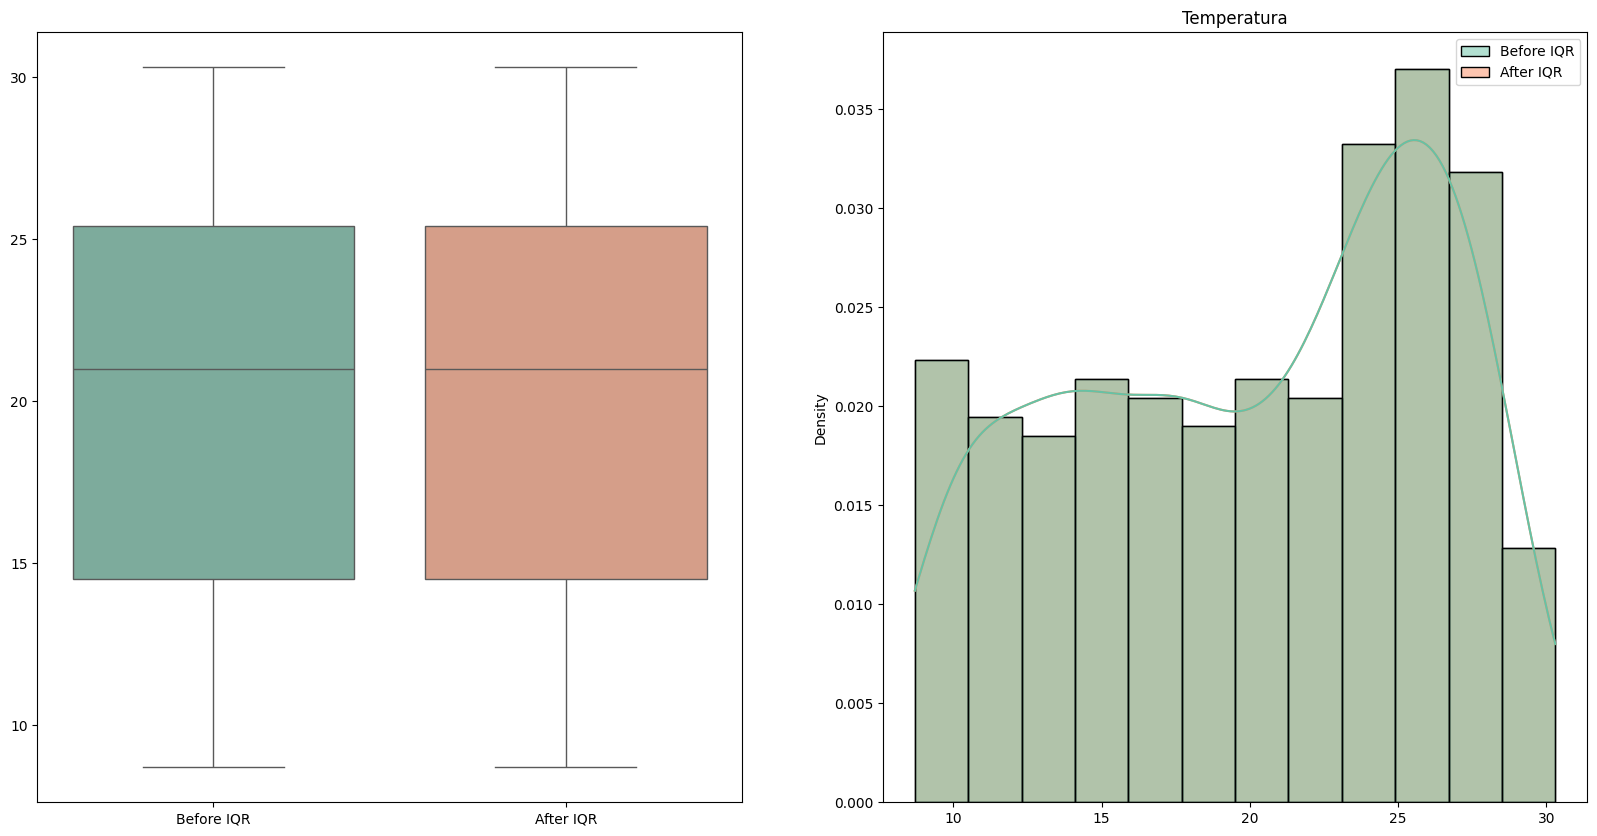

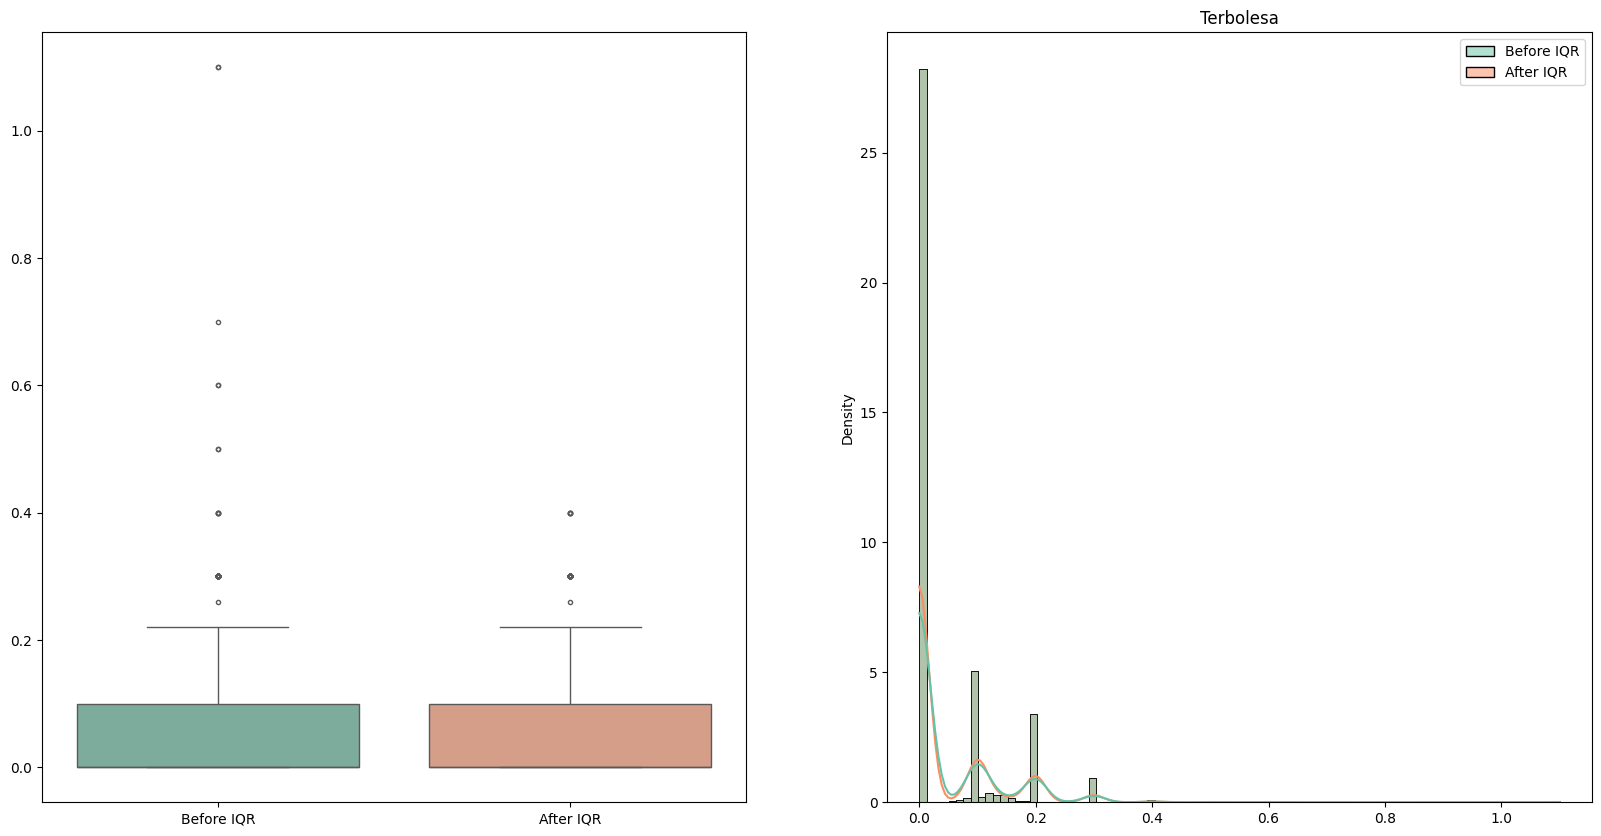

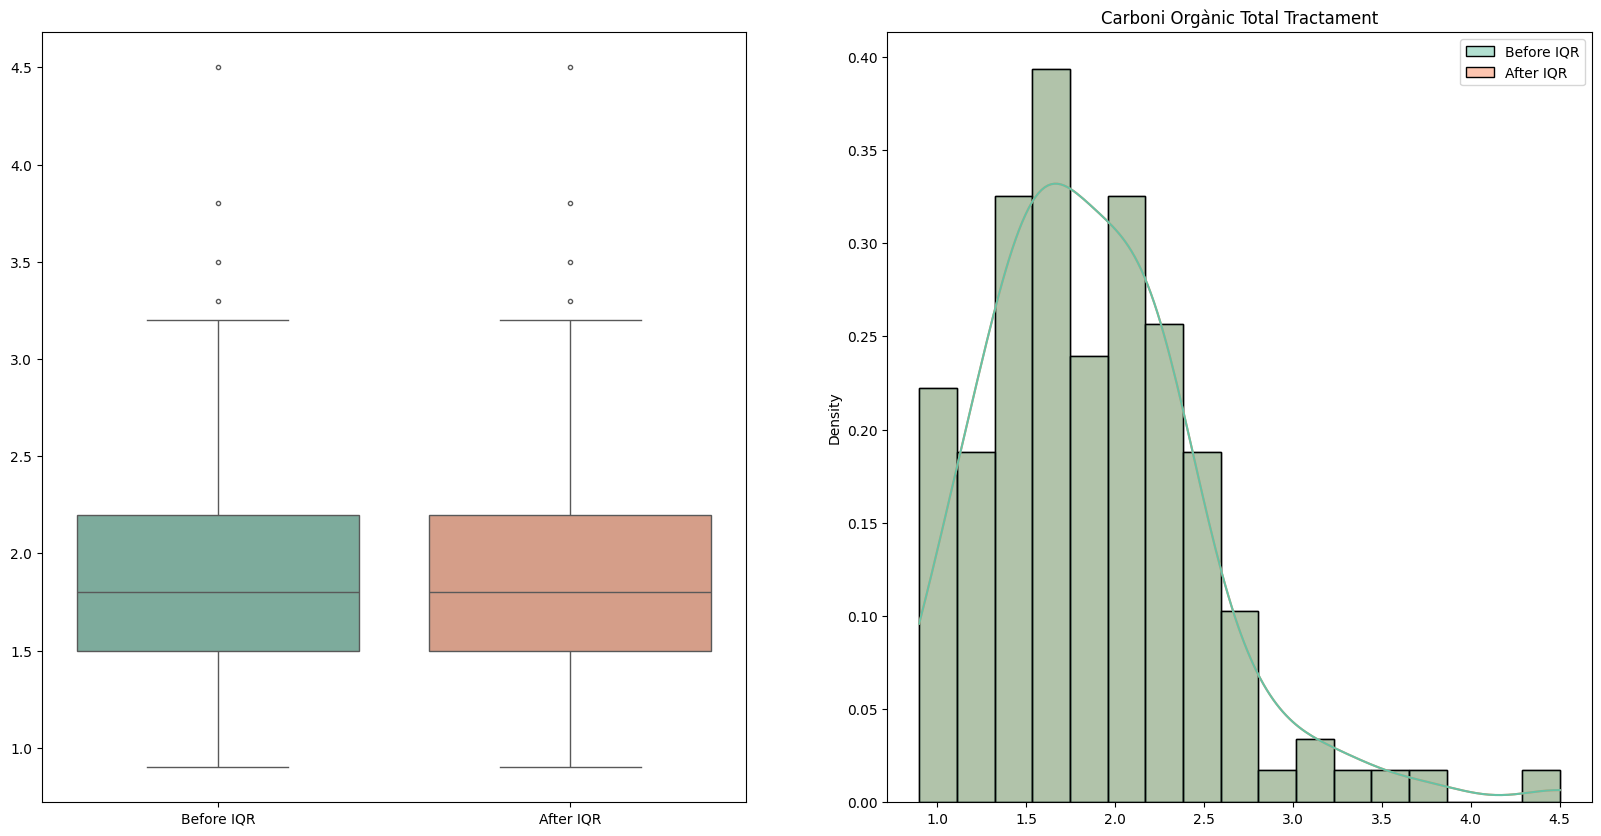

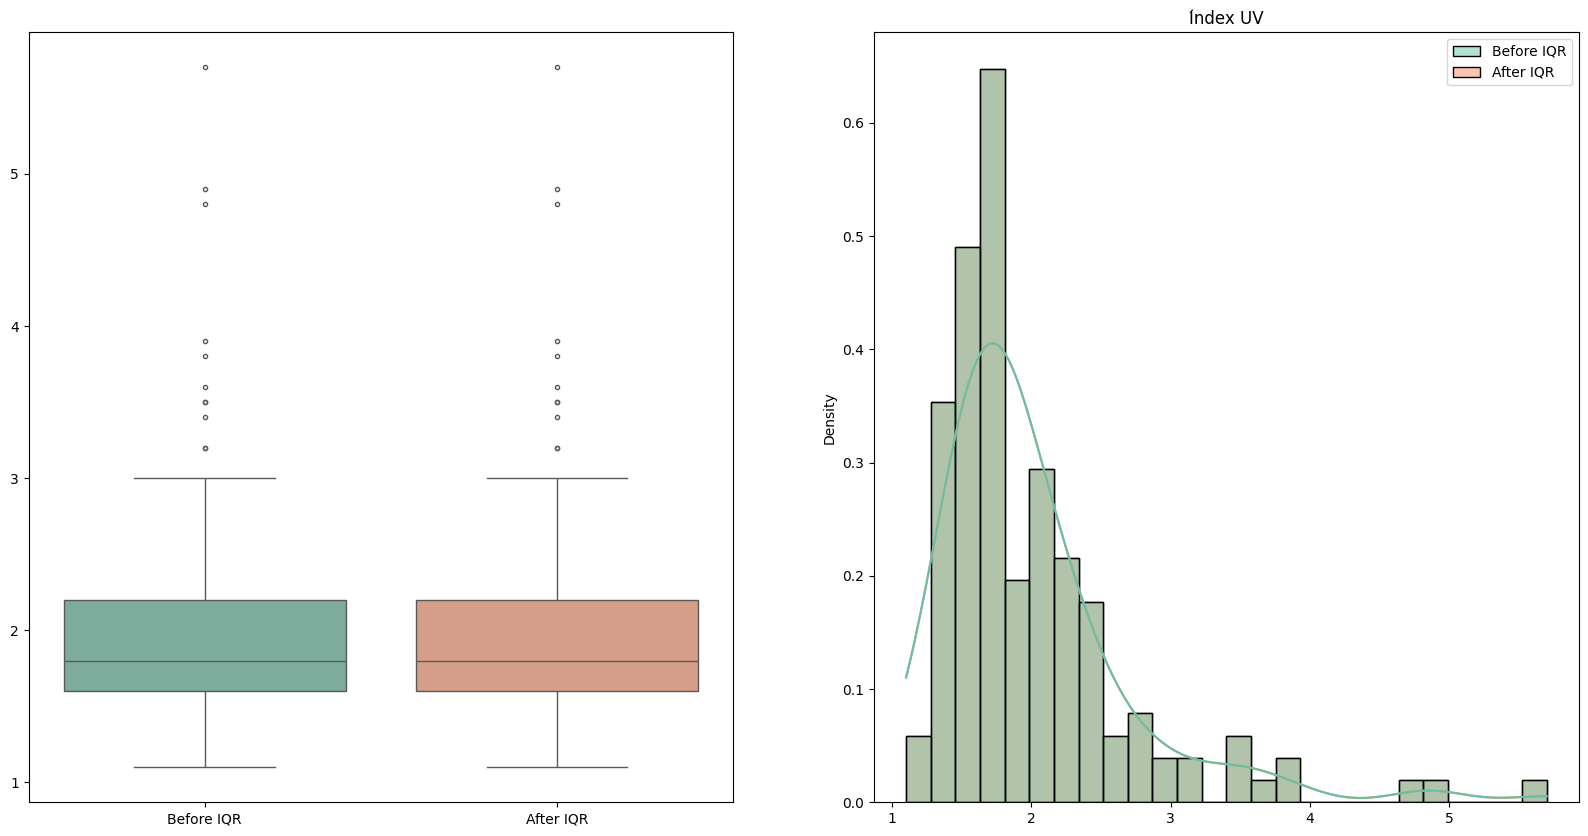

In [23]:
# Try combinations with and without zeros
# Outliers are removed using the IQR method

for lab_key in eb1_features_mapping.keys():

    quartile1, quartile3 = eb1_features_lab_df[lab_key].quantile([0.05, 0.95])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    # Create a temporary DataFrame with the column values before and after the IQR operation
    temp_df = pd.DataFrame(
        {
            "Before IQR": eb1_features_lab_df[lab_key],
            "After IQR": eb1_features_lab_df[lab_key].apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
                ),
        }
    )

    # Plot the temporary DataFrame
    
    fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
    
    sns.boxplot(
        data=temp_df,
        palette="Set2",
        saturation=0.5,
        whis=1.5,
        fliersize=3,
        ax=axs[0]
    )
    
    sns.histplot(
        data=temp_df,
        palette="Set2",
        kde=True,
        stat="density",
        ax=axs[1]
    )
    
    plt.title(lab_key)
    plt.show()

In [24]:
# Remove outliers
for lab_key in eb1_features_mapping.keys():

    quartile1, quartile3 = eb1_features_lab_df[lab_key].quantile([0.05, 0.95])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb1_features_lab_df[lab_key] = eb1_features_lab_df[lab_key].apply(
        lambda x: x if (x > lower_bound and x < upper_bound) else None
    )

In [25]:
# NaN count per feature
print(eb1_features_lab_df.isna().sum())
print()
print('Total number of samples: ', len(eb1_features_lab_df))

Unnamed: 0                                   0
DateTime                                     0
Carboni Orgànic Total Tractament         1937
Clor lliure residual                       111
Color                                      141
Conductivitat a 20oC                       118
Quantitat més abundant de partícules    1980
Temperatura                               1490
Terbolesa                                  118
pH                                         120
Índex UV                                 1931
dtype: int64

Total number of samples:  2075


<Axes: >

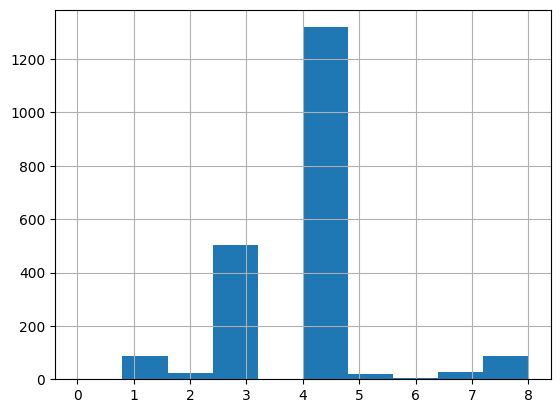

In [26]:
# NaN count per sample
eb1_features_lab_df.isna().sum(axis=1).hist()

In [27]:
# count of the samples with zero NaNs
(eb1_features_lab_df.isna().sum(axis=1) == 0).sum()

1

## Sensor

### EB0

#### Remove invalid samples

In [28]:
eb0_sensor_df = eb0_sensor_df[eb0_sensor_df["ALARMA ESPECTRAL"] < 3]

#### Remove Outliers

<Figure size 2000x1000 with 0 Axes>

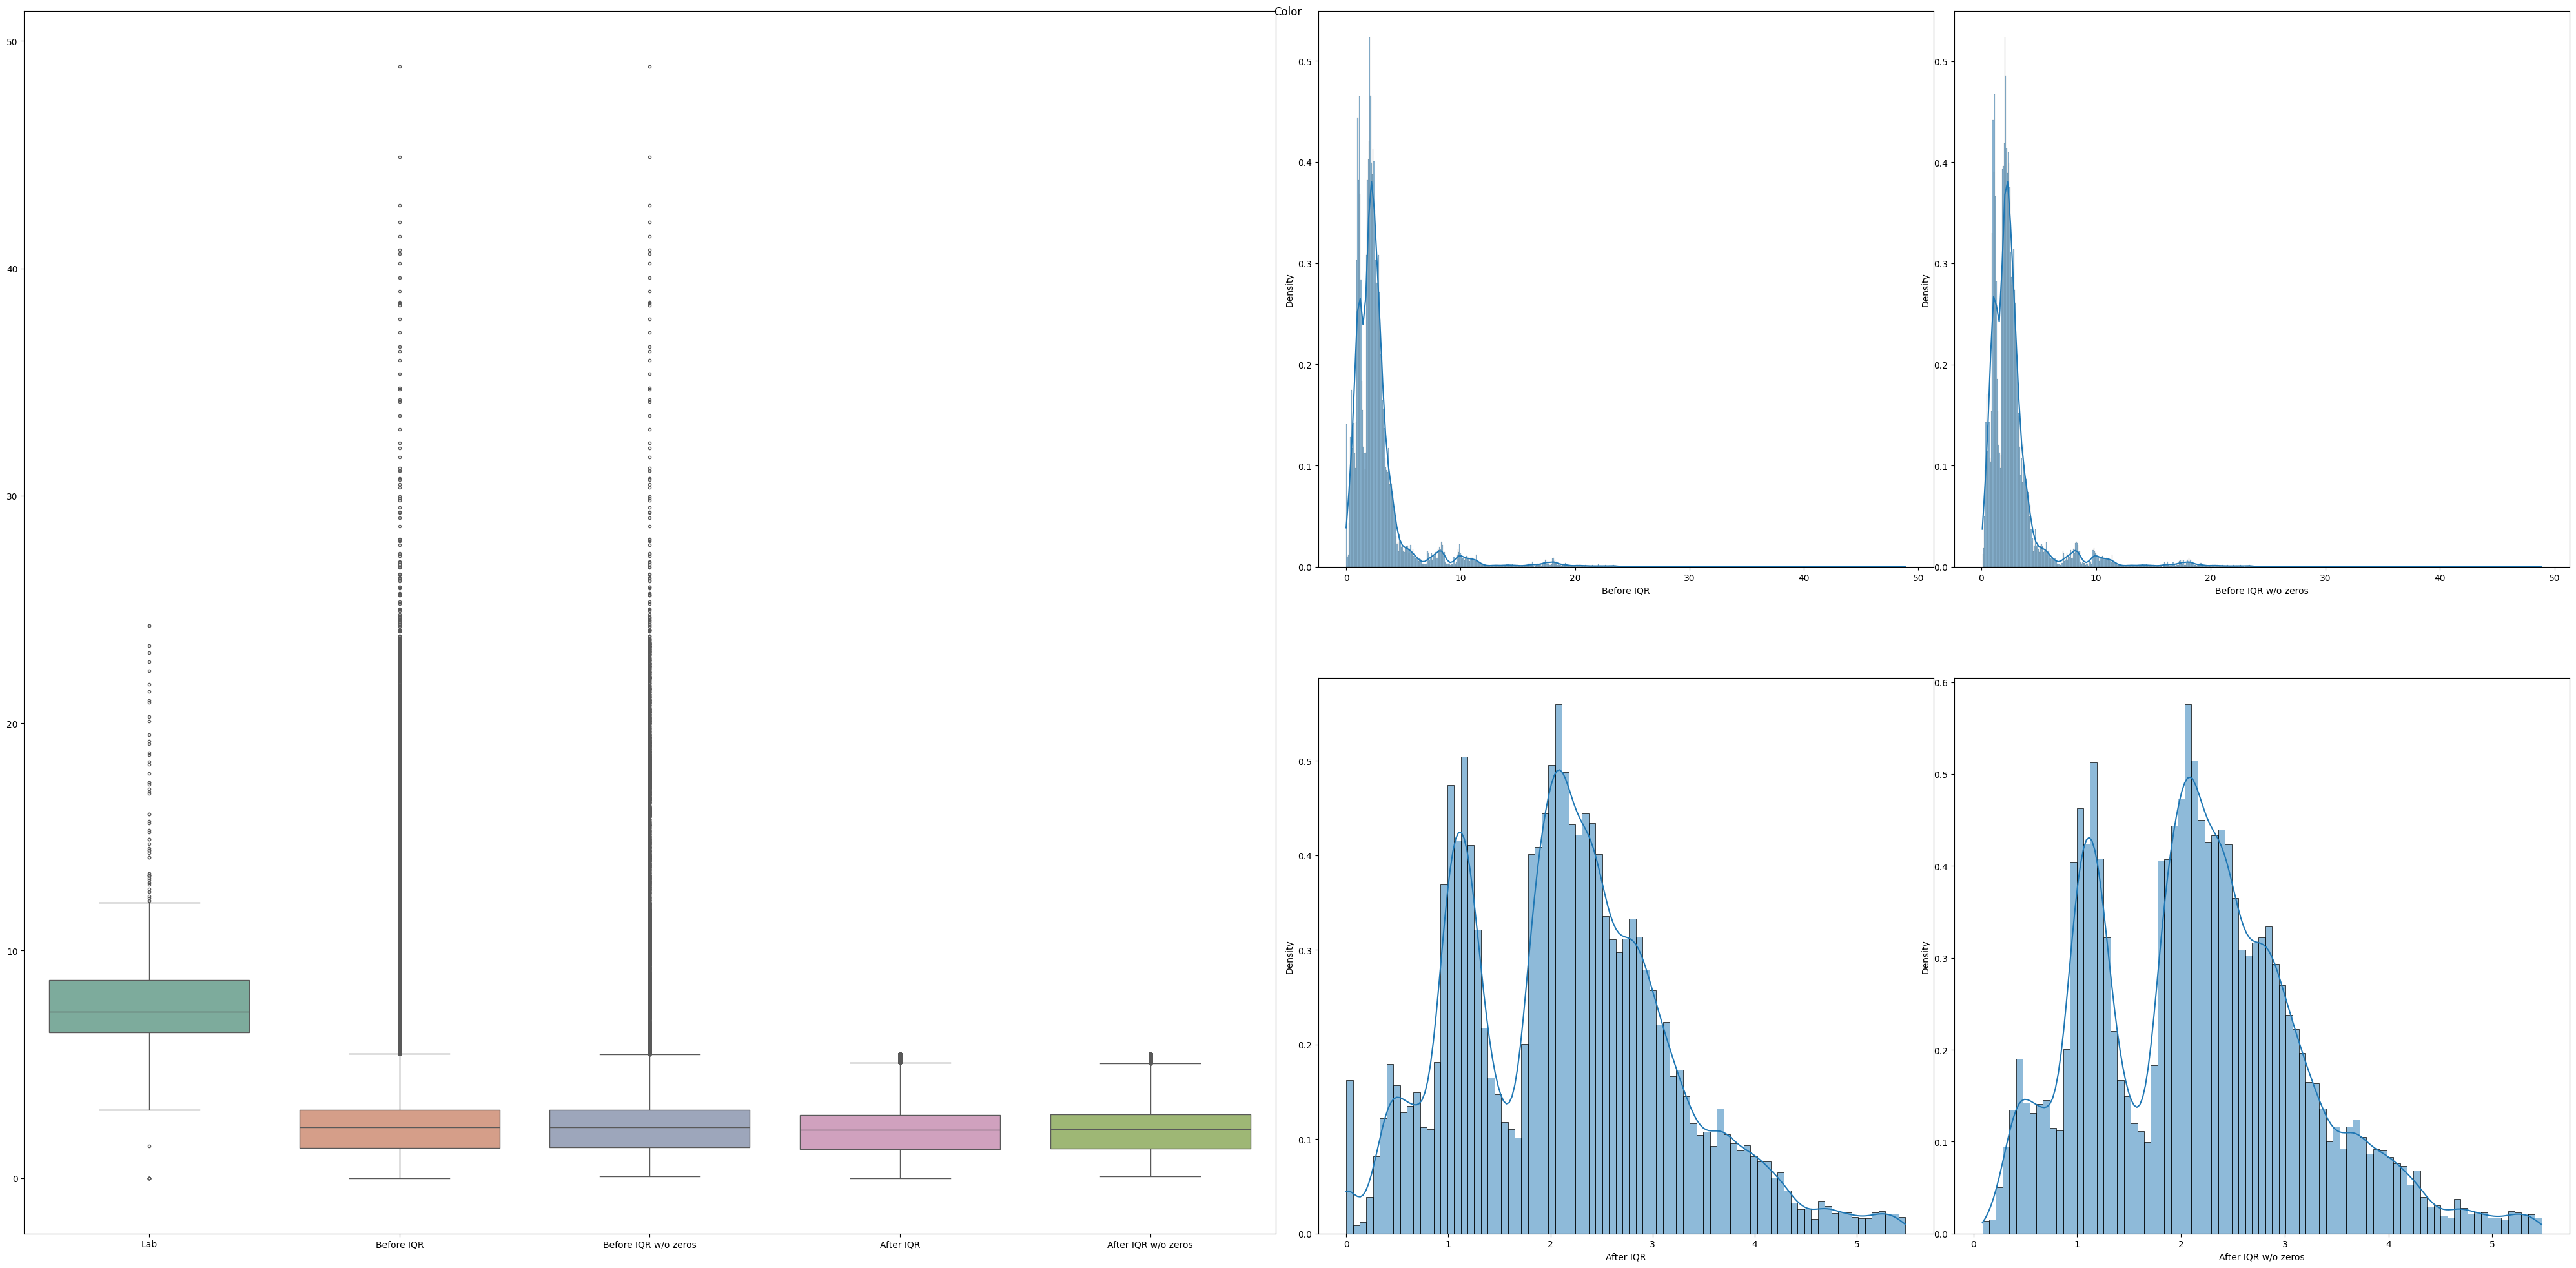

<Figure size 2000x1000 with 0 Axes>

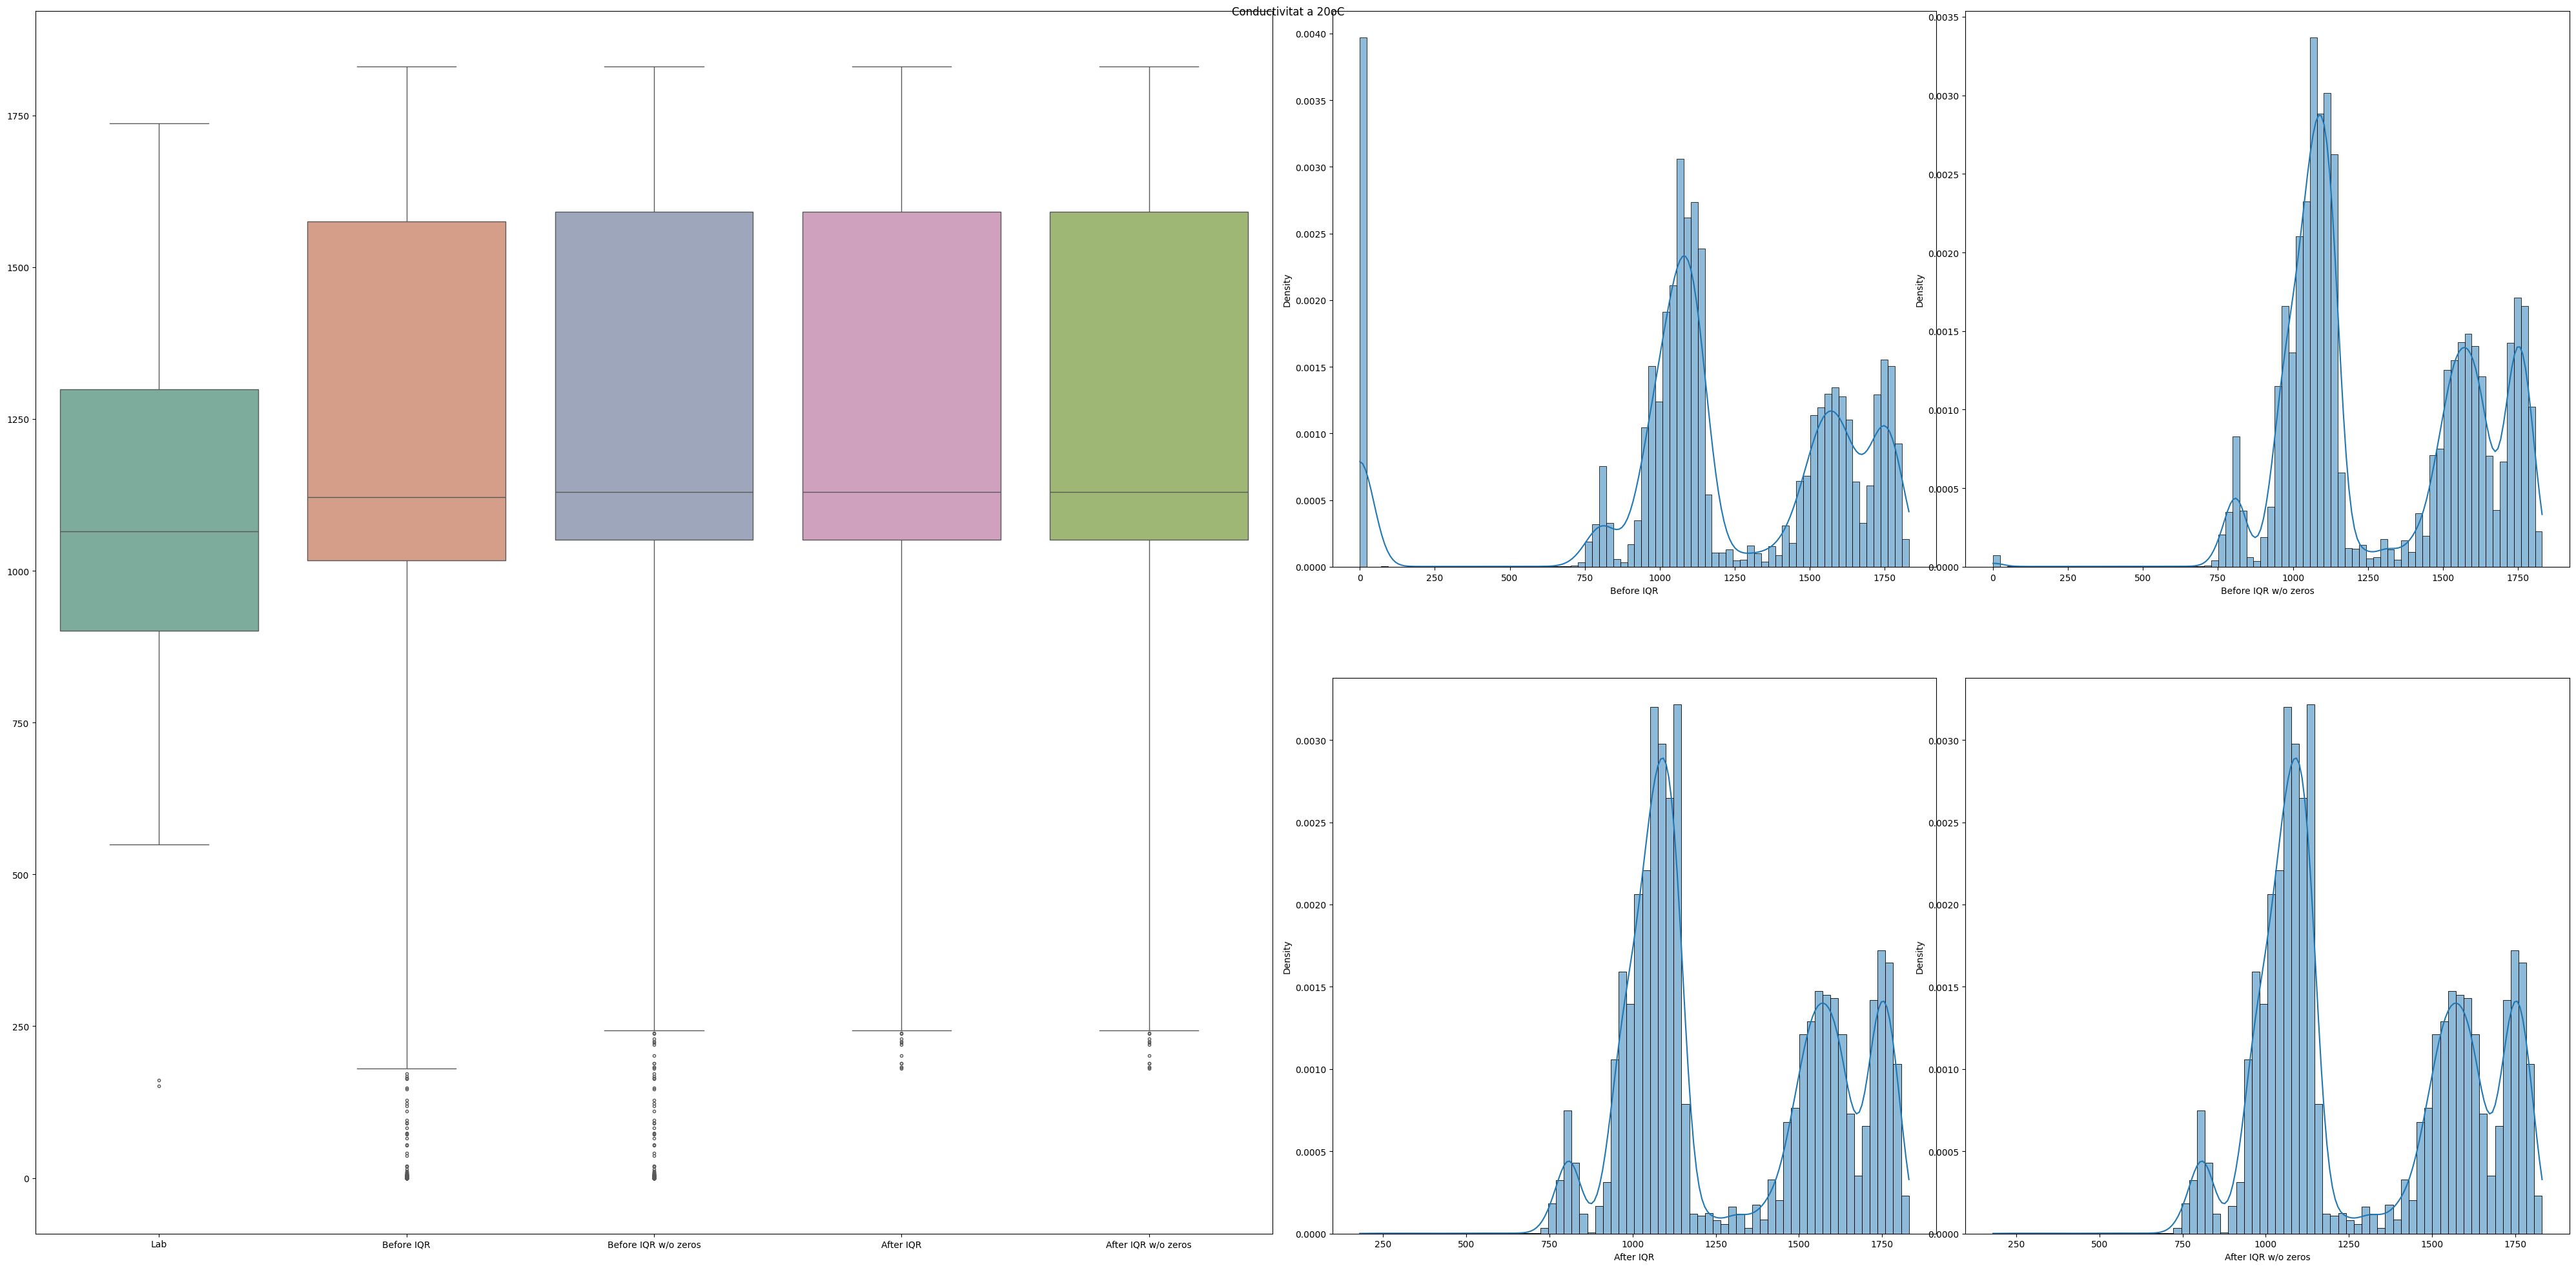

<Figure size 2000x1000 with 0 Axes>

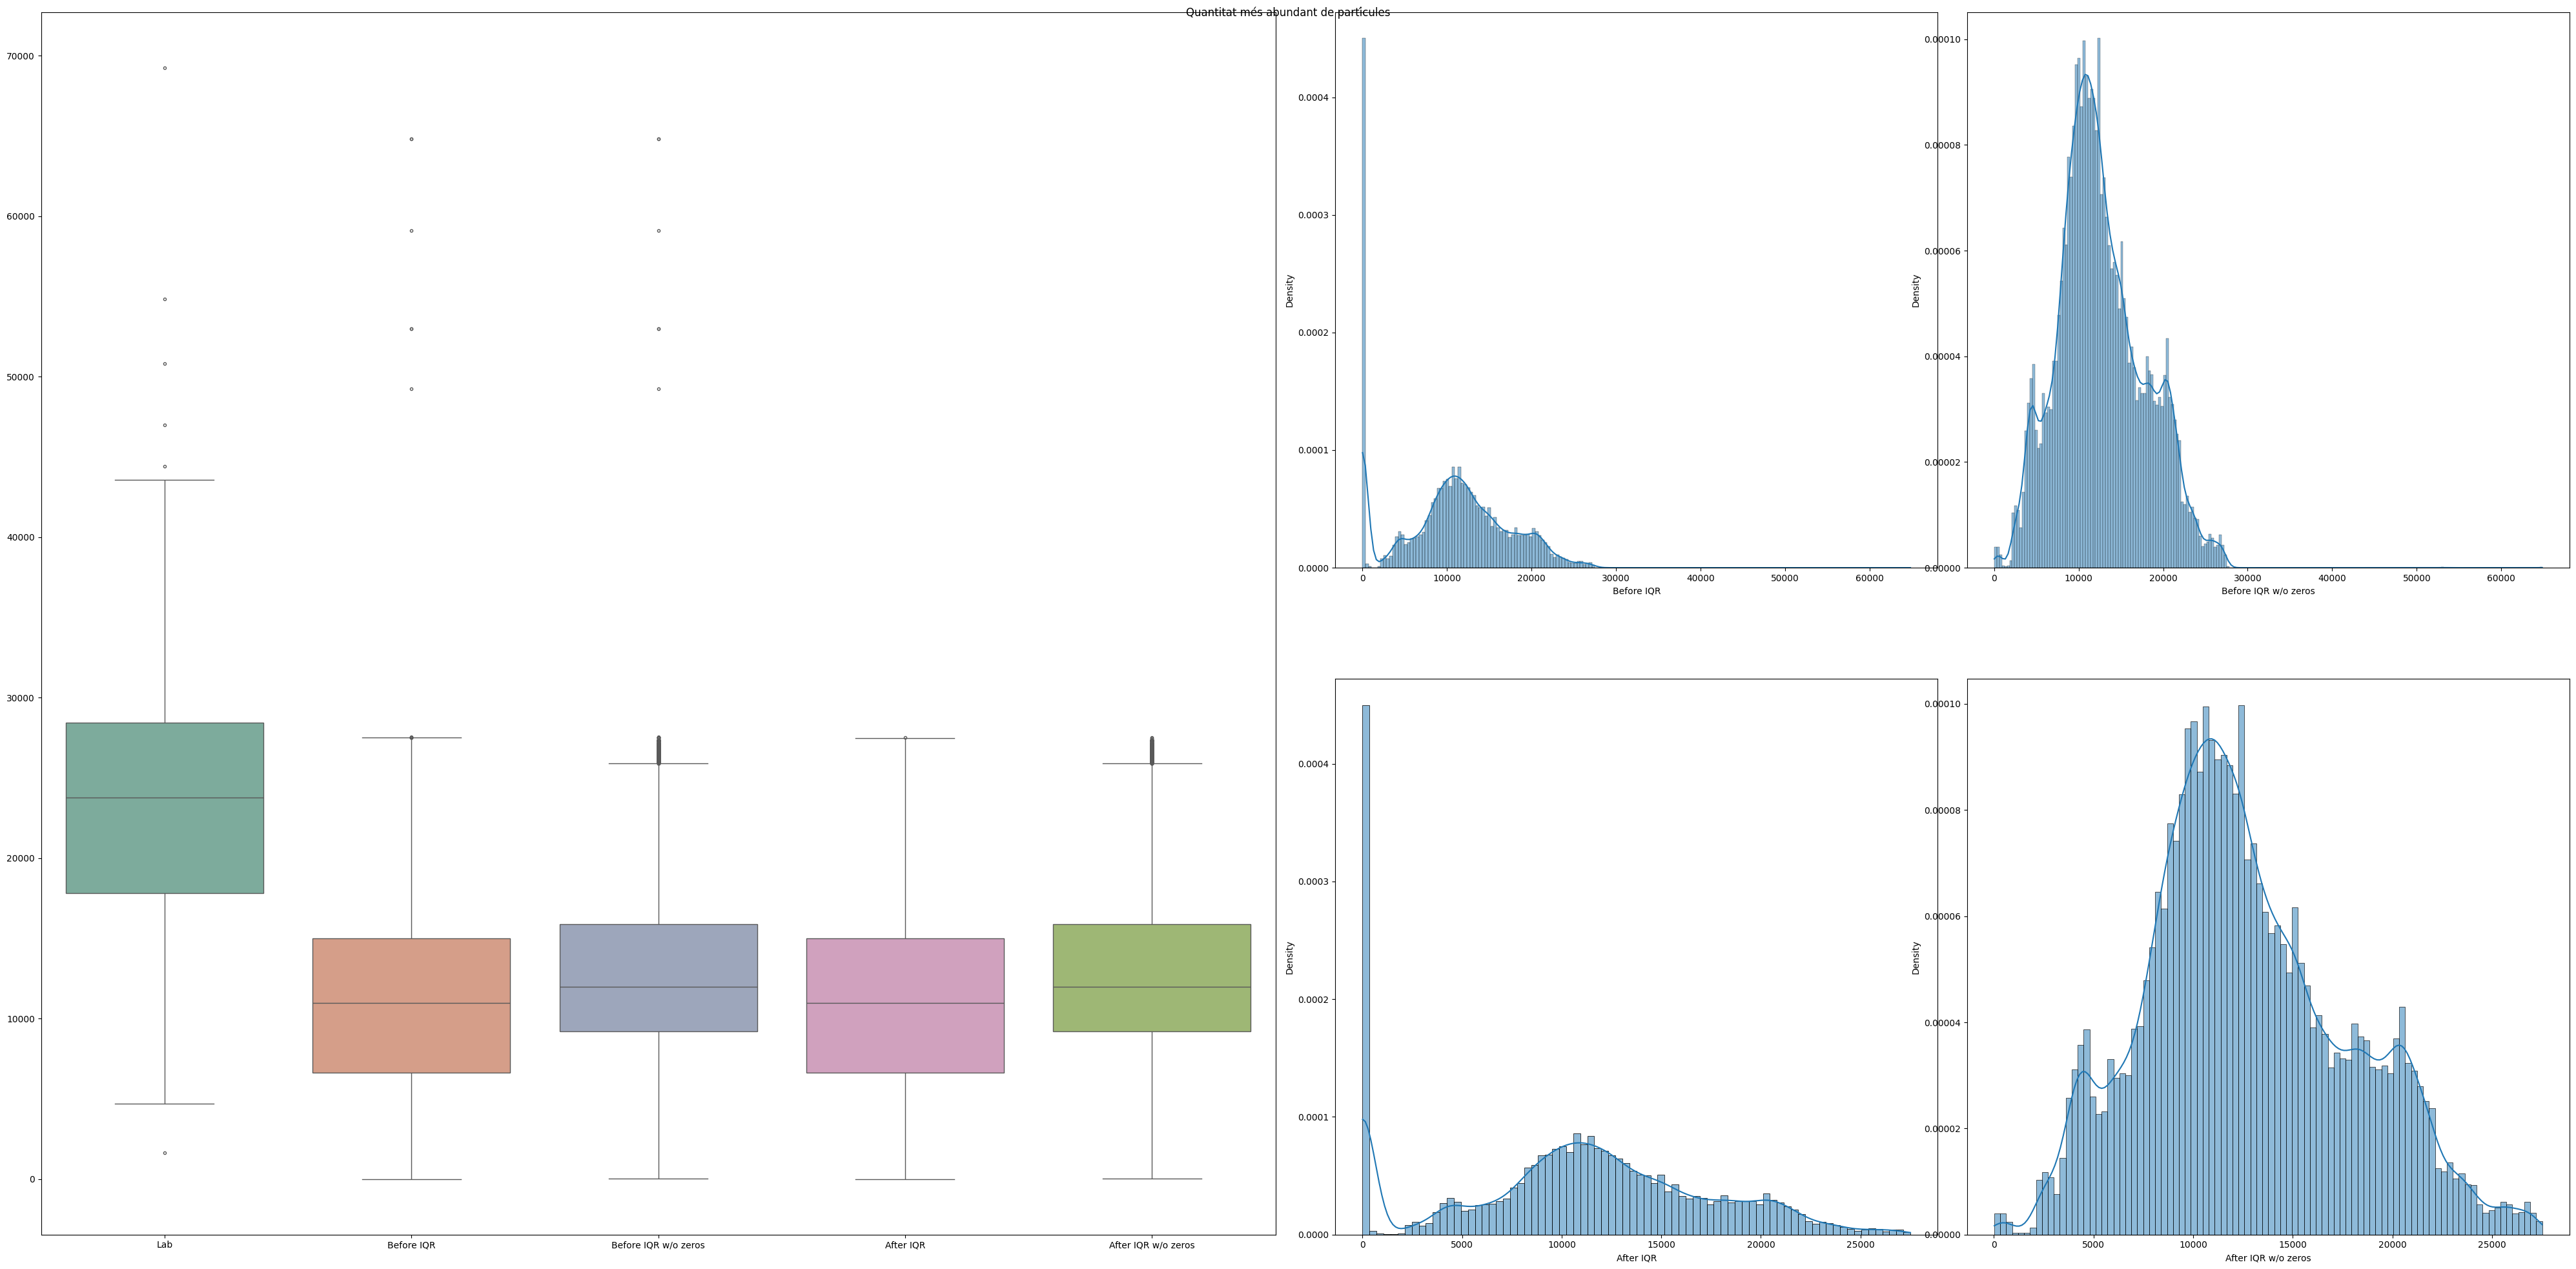

<Figure size 2000x1000 with 0 Axes>

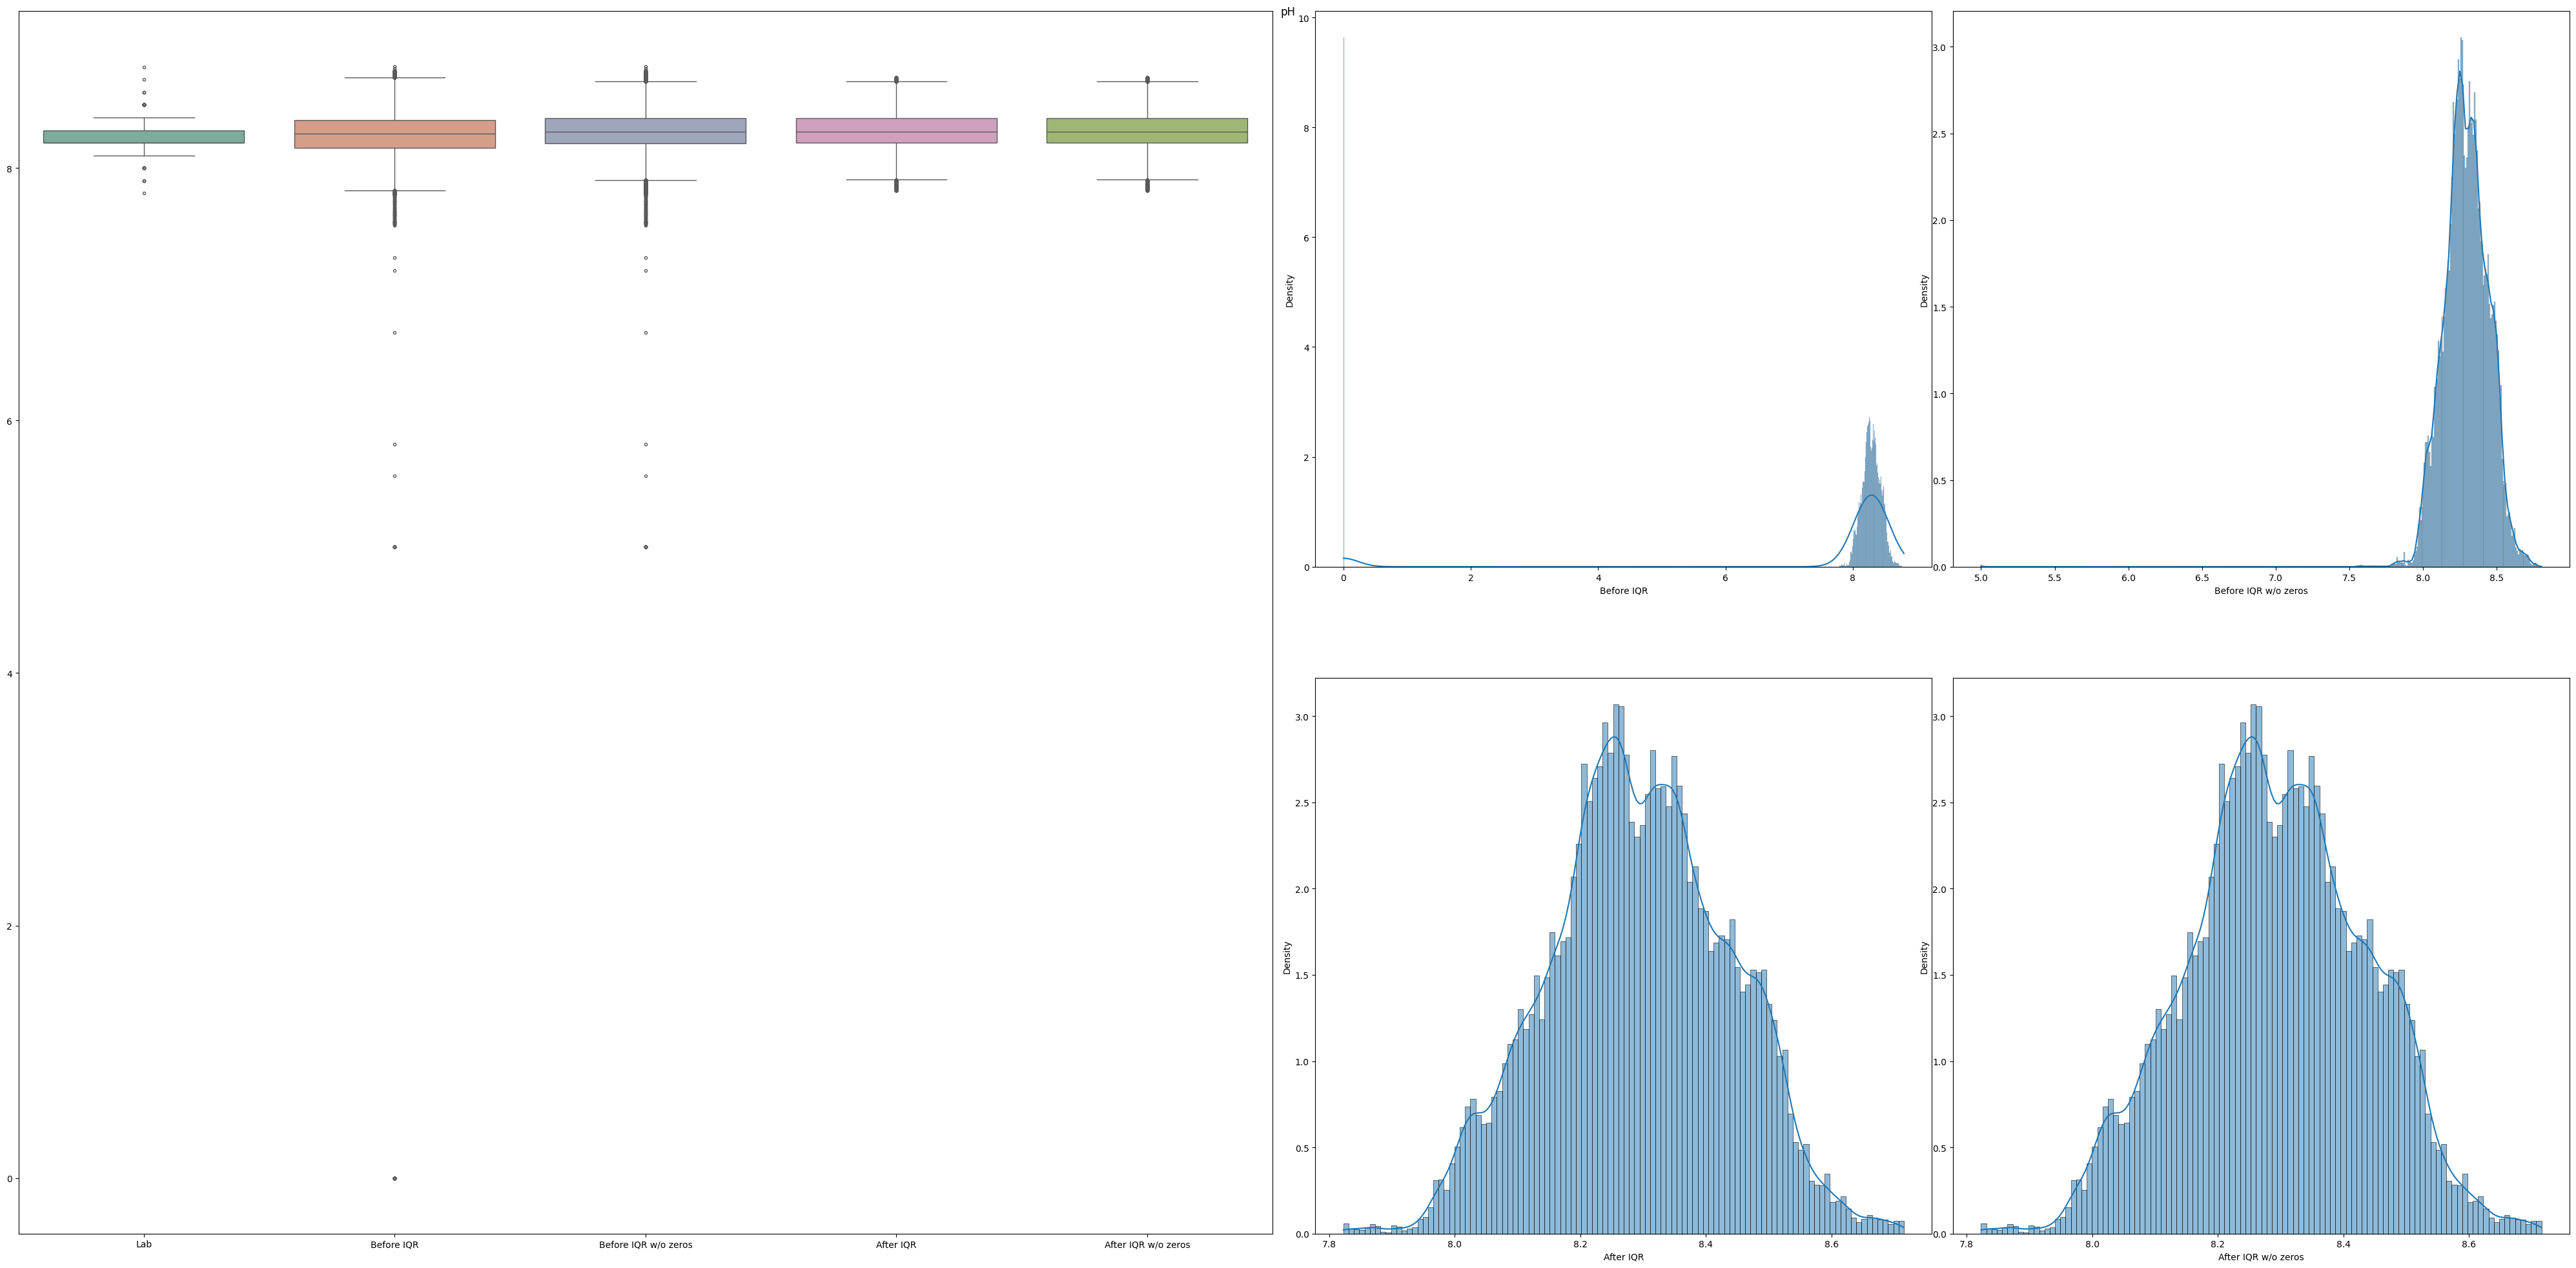

<Figure size 2000x1000 with 0 Axes>

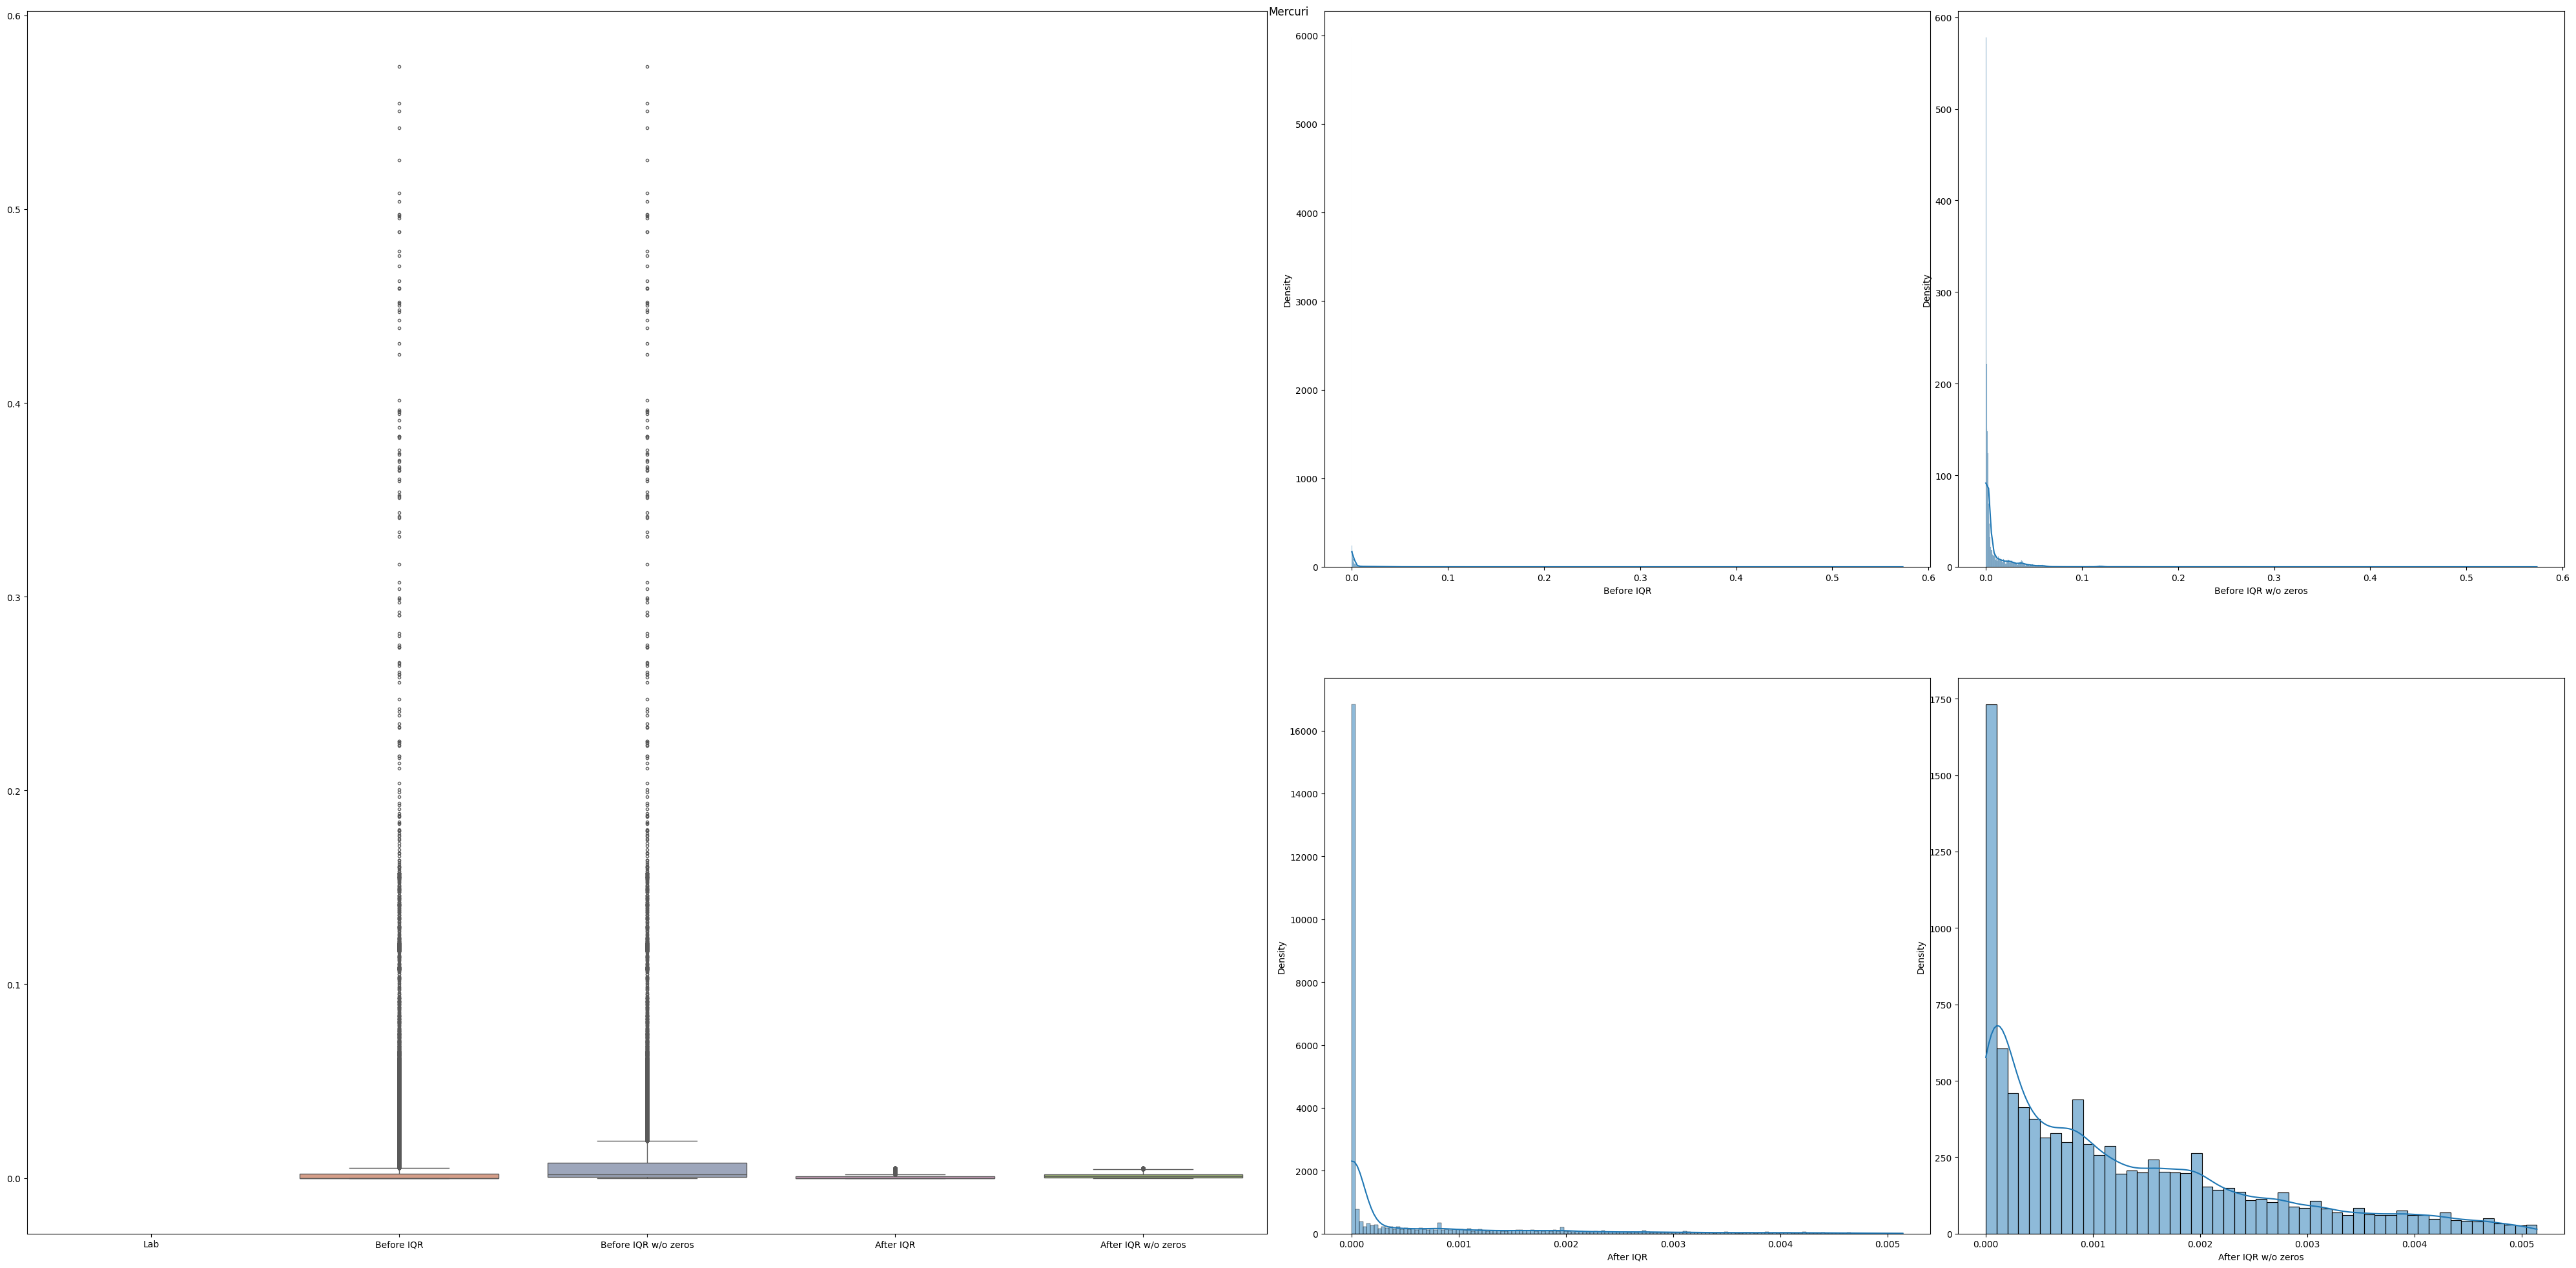

<Figure size 2000x1000 with 0 Axes>

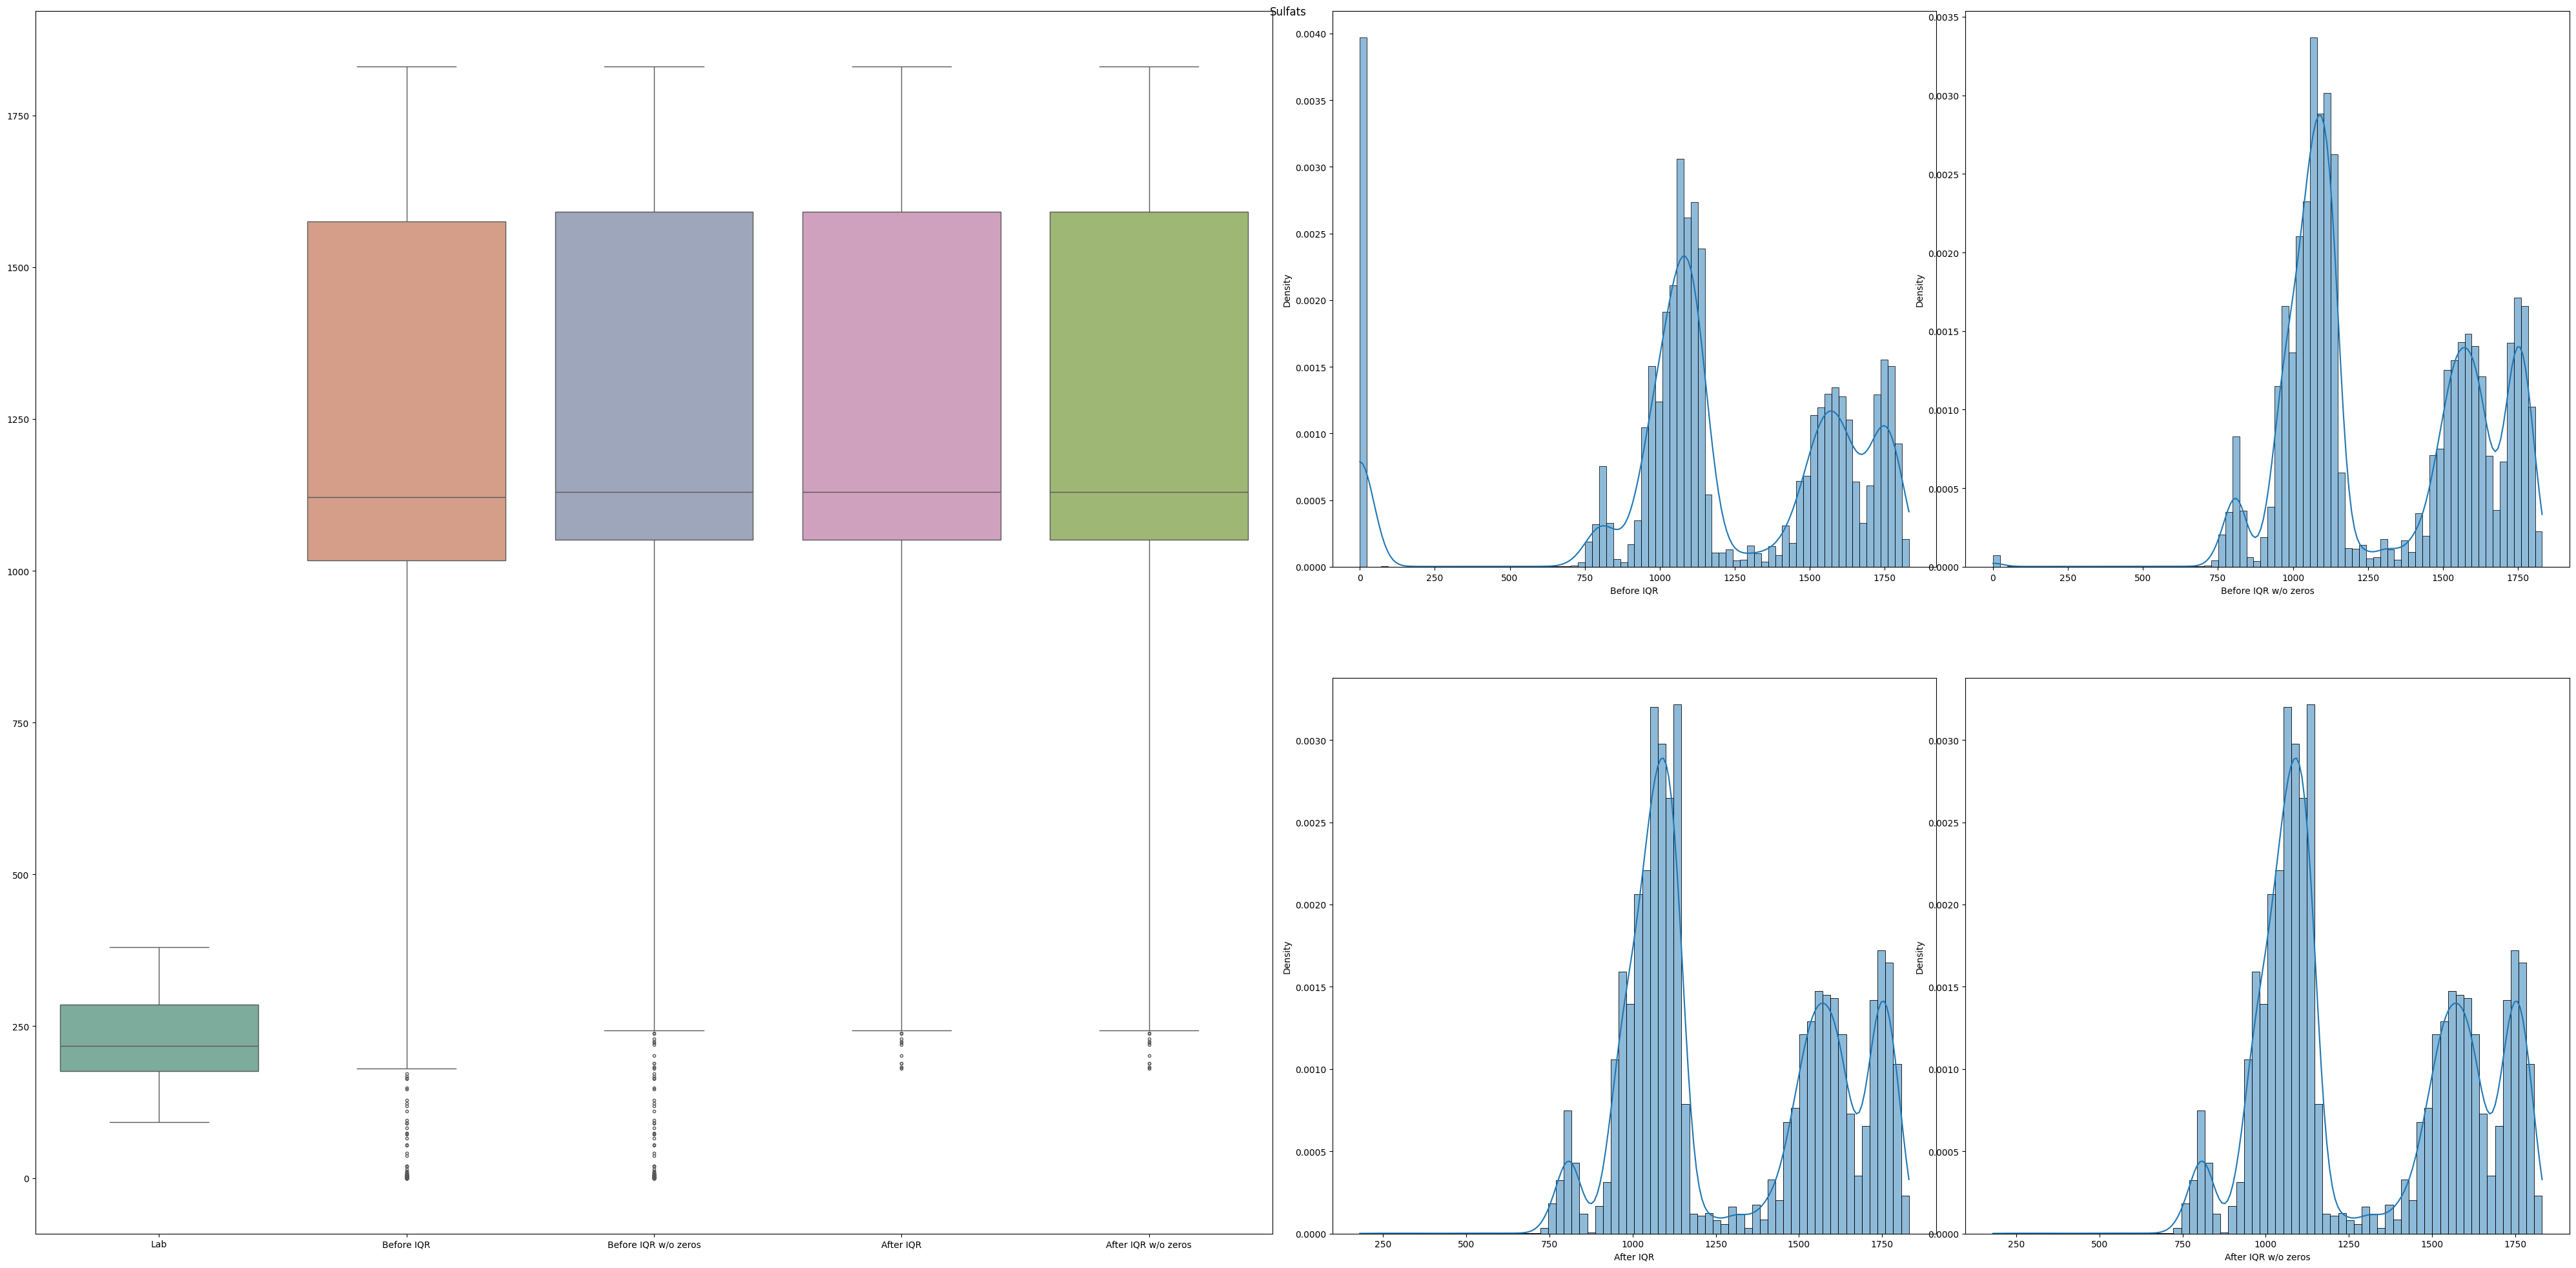

<Figure size 2000x1000 with 0 Axes>

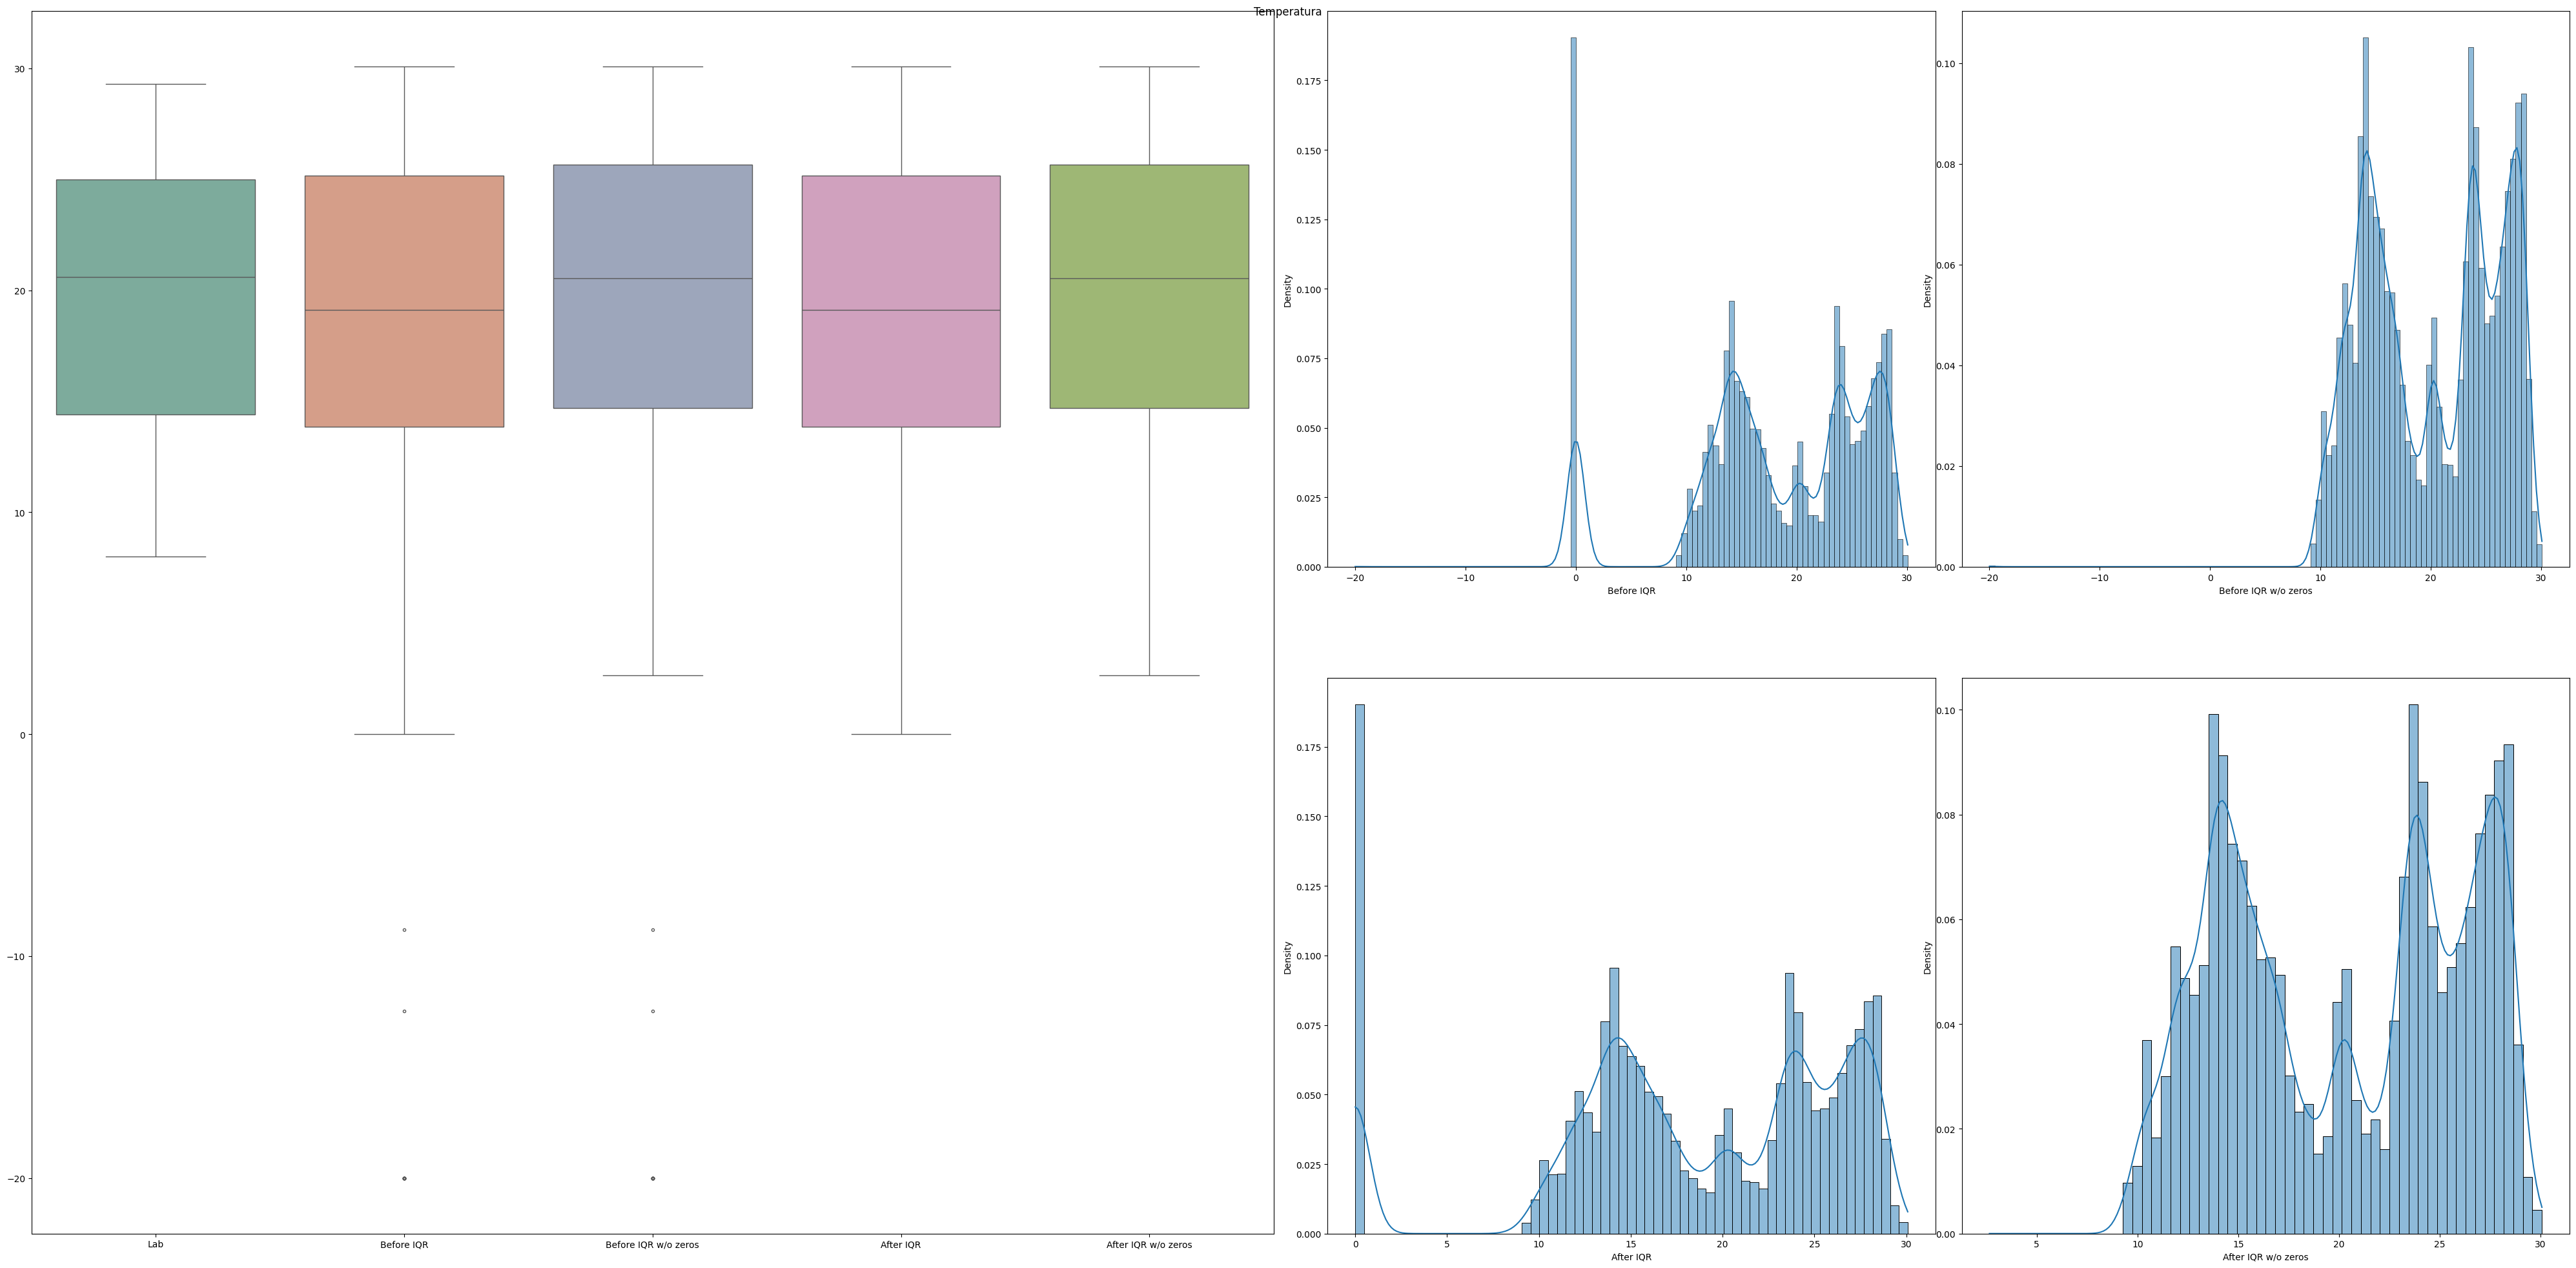

<Figure size 2000x1000 with 0 Axes>

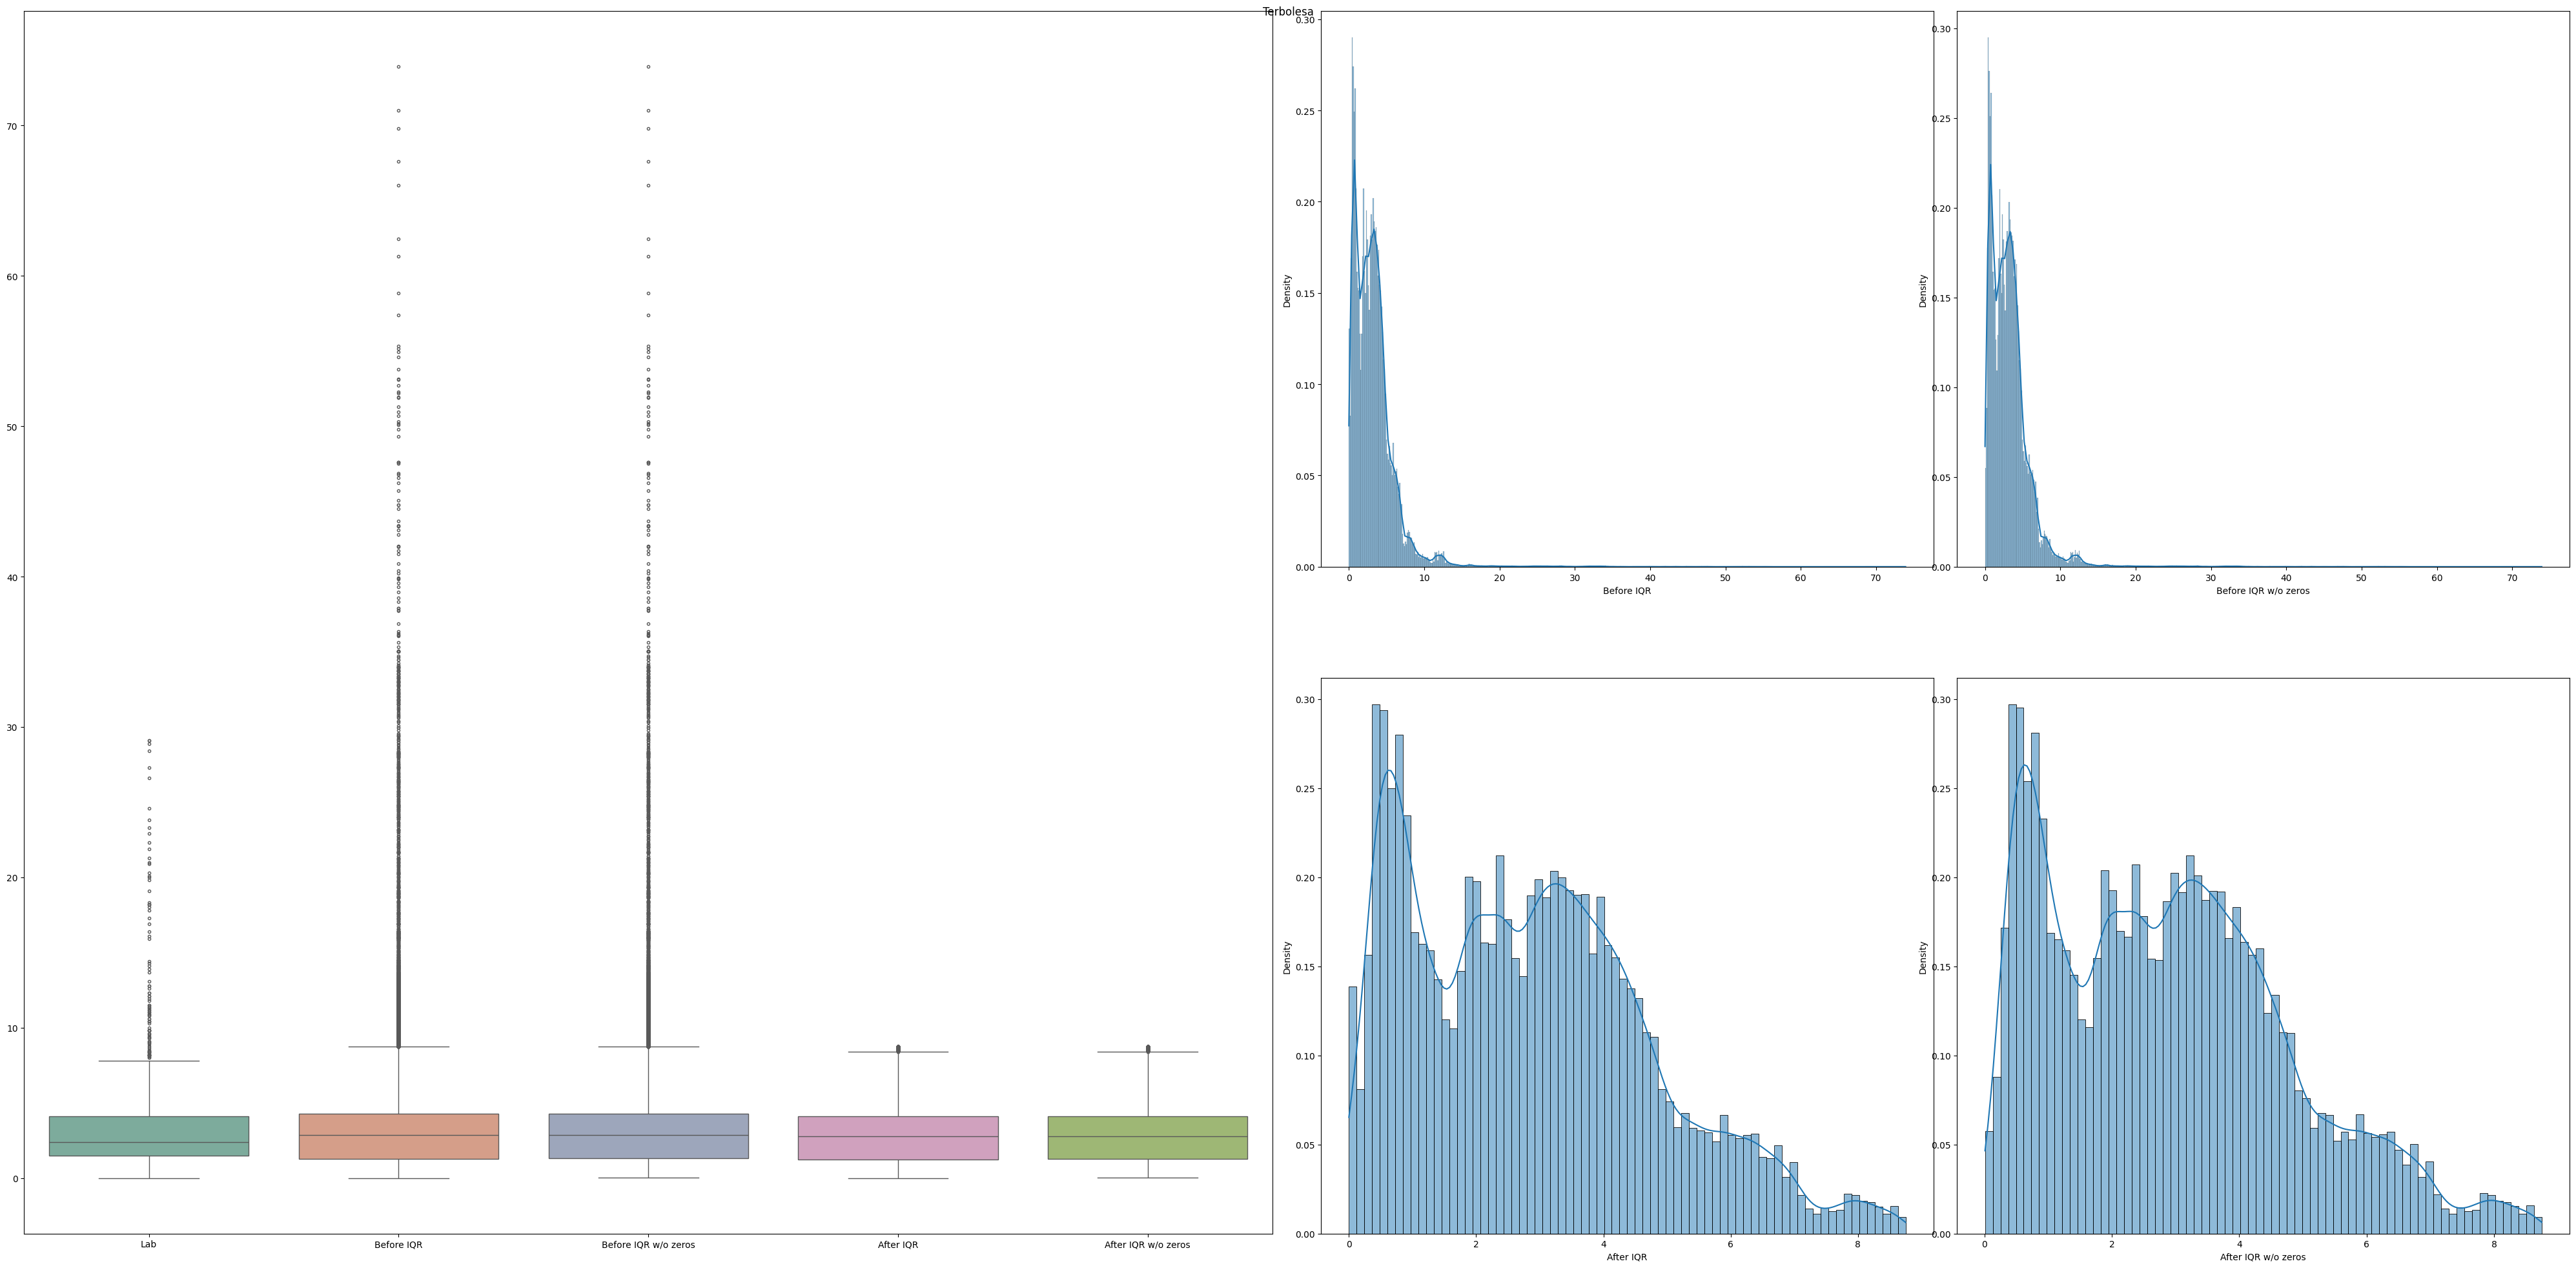

<Figure size 2000x1000 with 0 Axes>

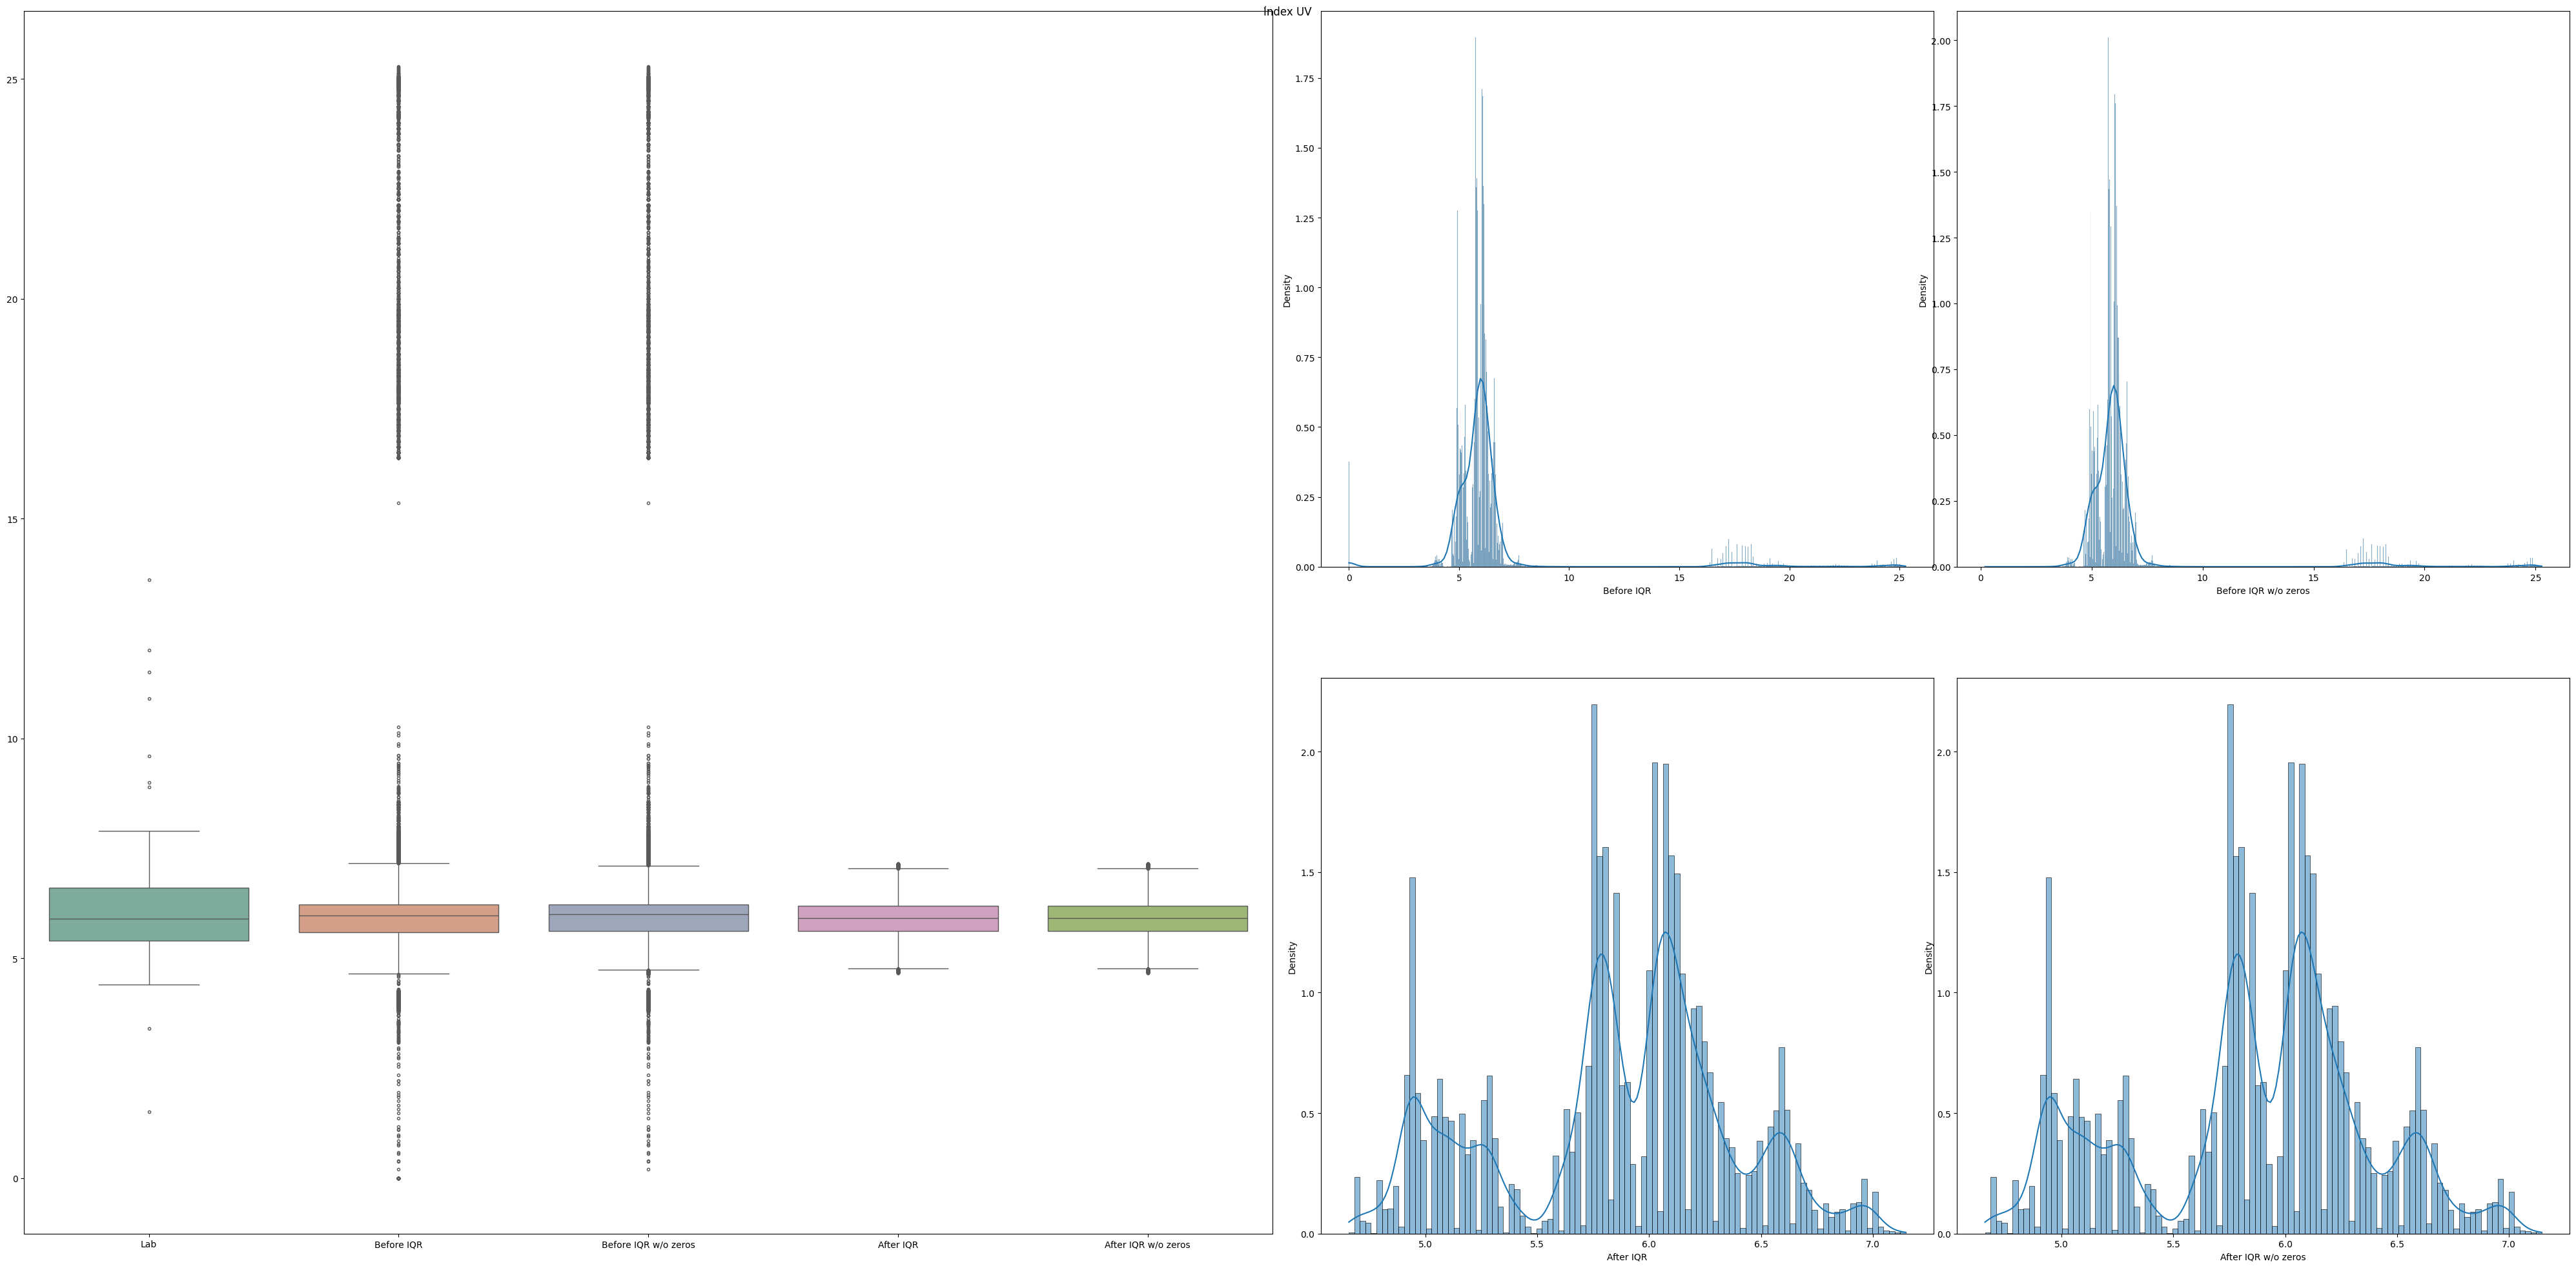

In [29]:
# Try combinations with and without zeros

# Outliers are removed using the IQR method
# NaNs are filled with the capped values

for lab_key, sensor_key in eb0_features_mapping.items():
    plt.figure(figsize=(20, 10))

    quartile1, quartile3 = eb0_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb0_without_zeros = eb0_sensor_df[sensor_key][
        eb0_sensor_df[sensor_key] != 0
    ]

    # Create a temporary DataFrame with the column values before and after the IQR operation
    temp_df = pd.DataFrame(
        {
            "Lab": eb0_features_lab_df[lab_key],
            "Before IQR": eb0_sensor_df[sensor_key],
            "Before IQR w/o zeros": eb0_without_zeros,
            "After IQR": eb0_sensor_df[sensor_key].apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
            "After IQR w/o zeros": eb0_without_zeros.apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
        }
    )
    
    # ...

    fig = plt.figure(figsize=(40, 20))
    
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])

    # Plot the temporary DataFrame
    sns.boxplot(
        data=temp_df,
        palette="Set2",
        saturation=0.5,
        whis=1.5,
        fliersize=3,
        ax=fig.add_subplot(gs00[0])
    )
    
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1])

    # Plot a histogram for each column
    for i, column in enumerate(temp_df.columns[1:], start=1):
        sns.histplot(
            data=temp_df[column],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs01[i - 1]),
            label=column
        )
        
    

    plt.suptitle(lab_key)
    plt.tight_layout()
    plt.show()

In [30]:
list(eb0_features_mapping.values())

['COLOR',
 'COND',
 'PARTICULES',
 'PH',
 'RATIO_HG',
 'SULFAT',
 'TEMP_AIGUA',
 'TERBOLESA',
 'UV254']

In [31]:
# Outliers are removed using the IQR method w/o zeros
# The features that can have 0 values are: RATIO_HG, TERBOLESA

for sensor_key in eb0_features_mapping.values():
    
    if sensor_key not in ["RATIO_HG", "TERBOLESA"]:
        eb0_sensor_df = eb0_sensor_df[eb0_sensor_df[sensor_key] > 0]

    quartile1, quartile3 = eb0_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb0_sensor_df[sensor_key] = (
        eb0_sensor_df[sensor_key]
        .apply(lambda x: x if (x > lower_bound and x < upper_bound) else None)
    )

### EB1

#### Remove invalid samples

In [32]:
eb1_sensor_df = eb1_sensor_df[eb1_sensor_df["ALARMA SPECTRAL"] < 3]

#### Remove outliers

In [33]:
'''
Si potrebbe pensare di utilizzare come lower e upper bound per rimuovere gli outliers
dai samples dei sensori i valori di 0.25 e 0.75 dei samples da laboratorio
'''

'\nSi potrebbe pensare di utilizzare come lower e upper bound per rimuovere gli outliers\ndai samples dei sensori i valori di 0.25 e 0.75 dei samples da laboratorio\n'

<Figure size 2000x1000 with 0 Axes>

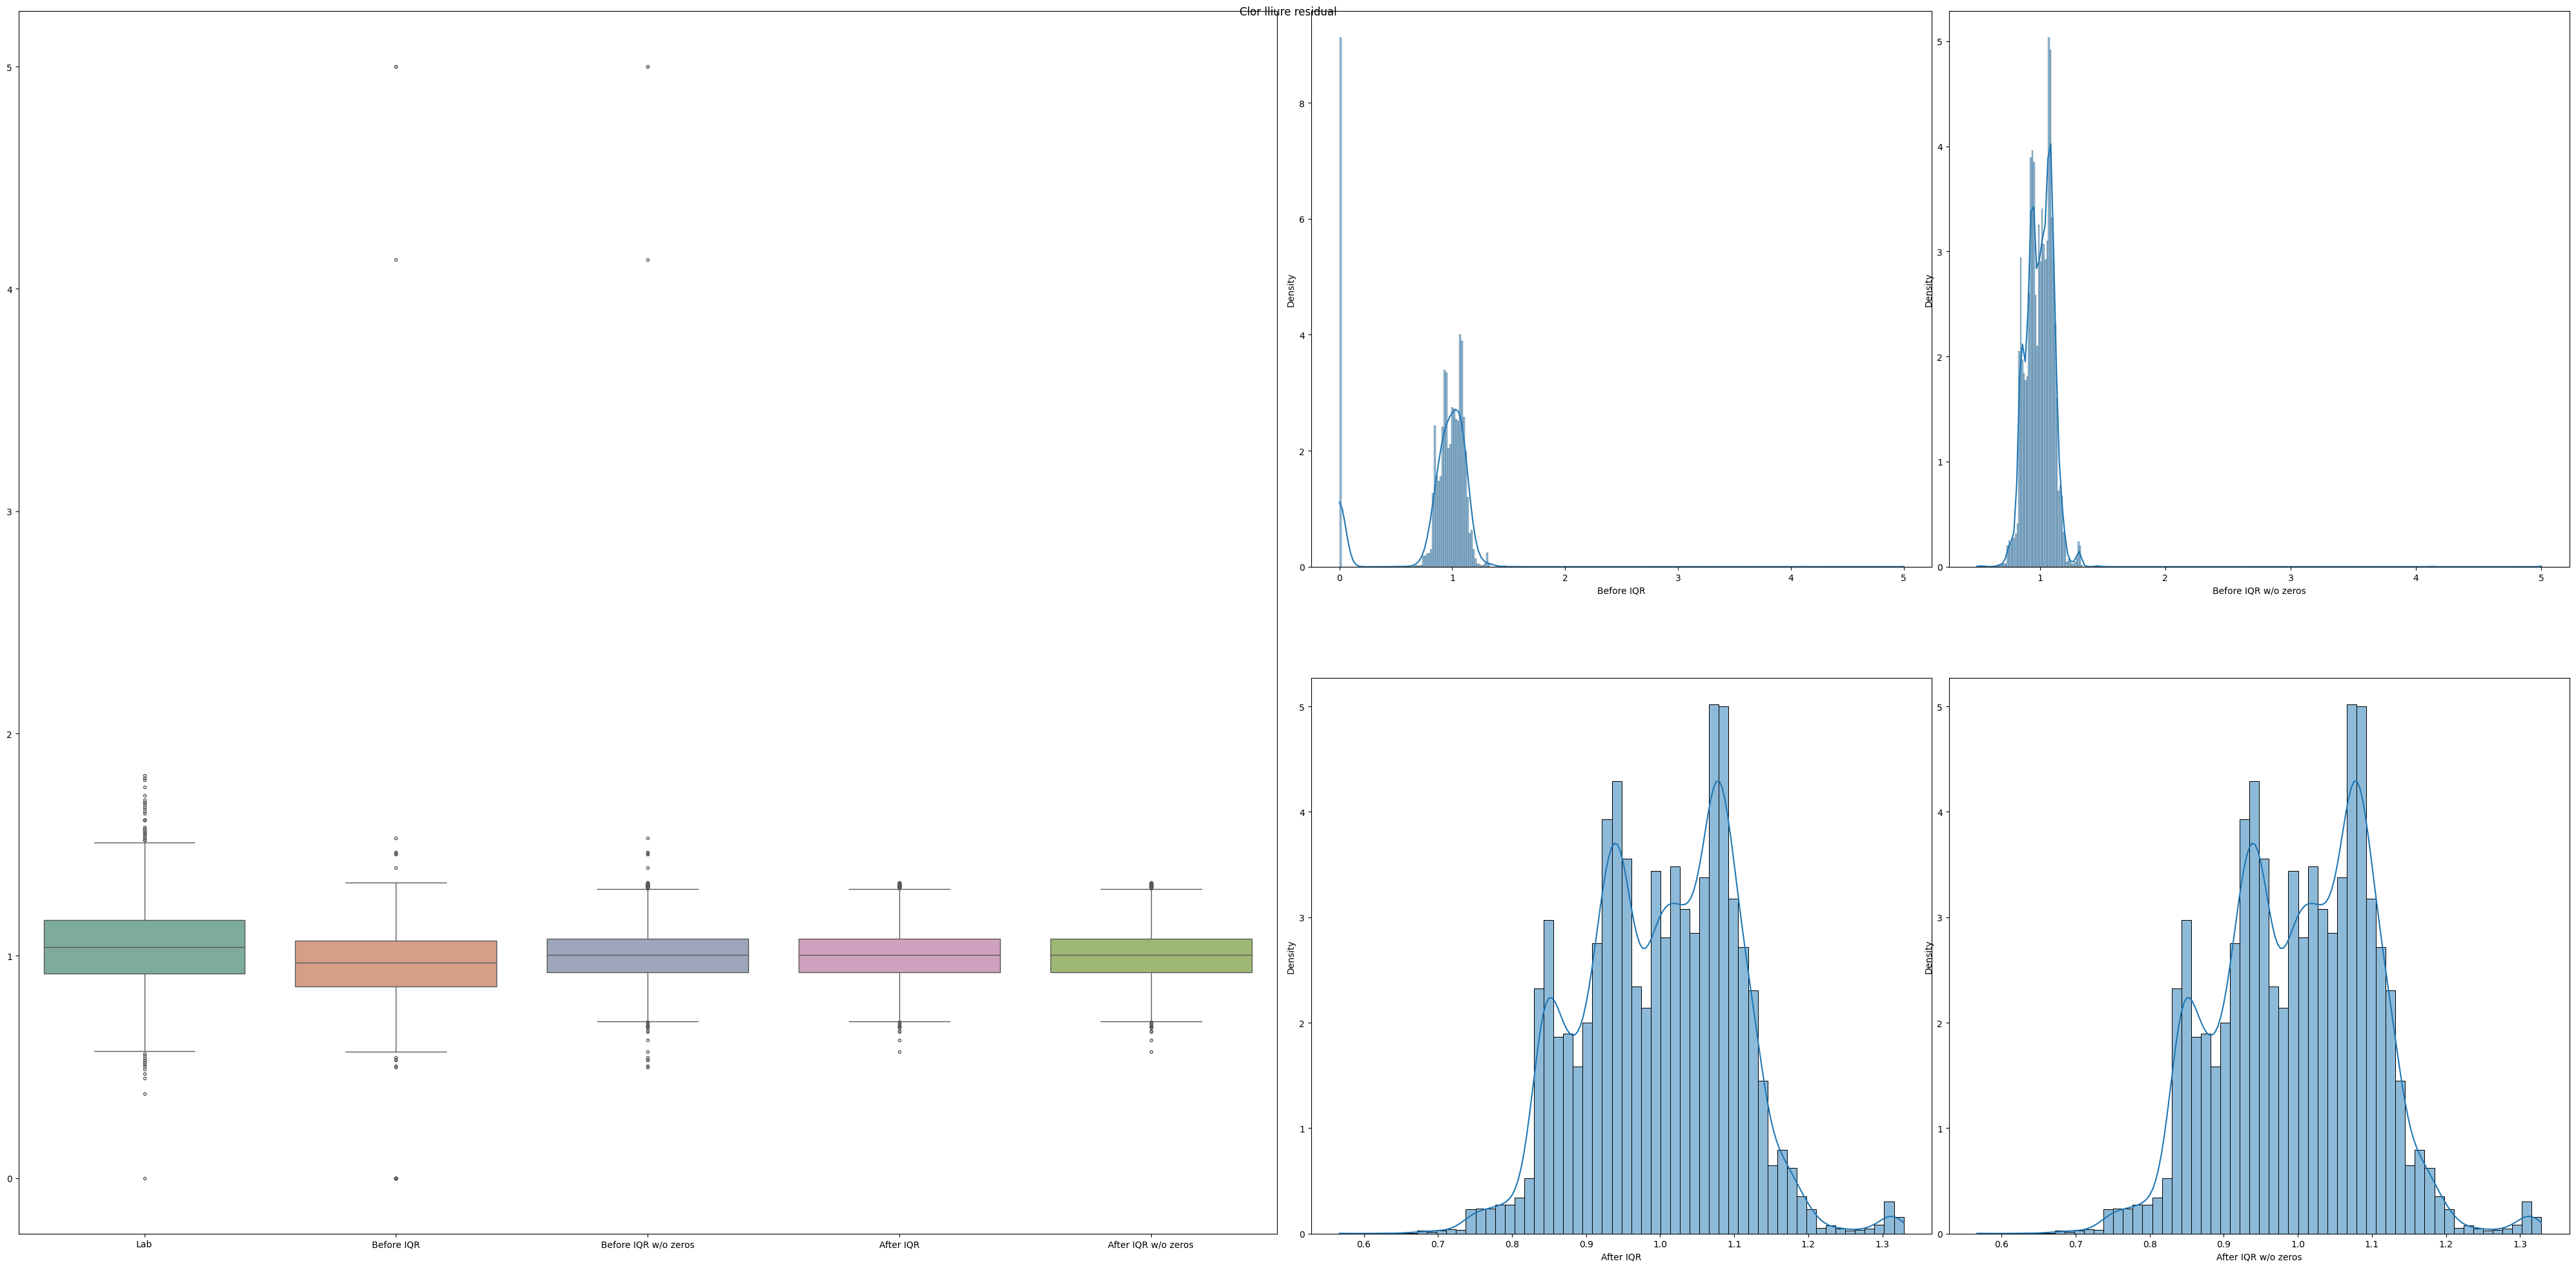

<Figure size 2000x1000 with 0 Axes>

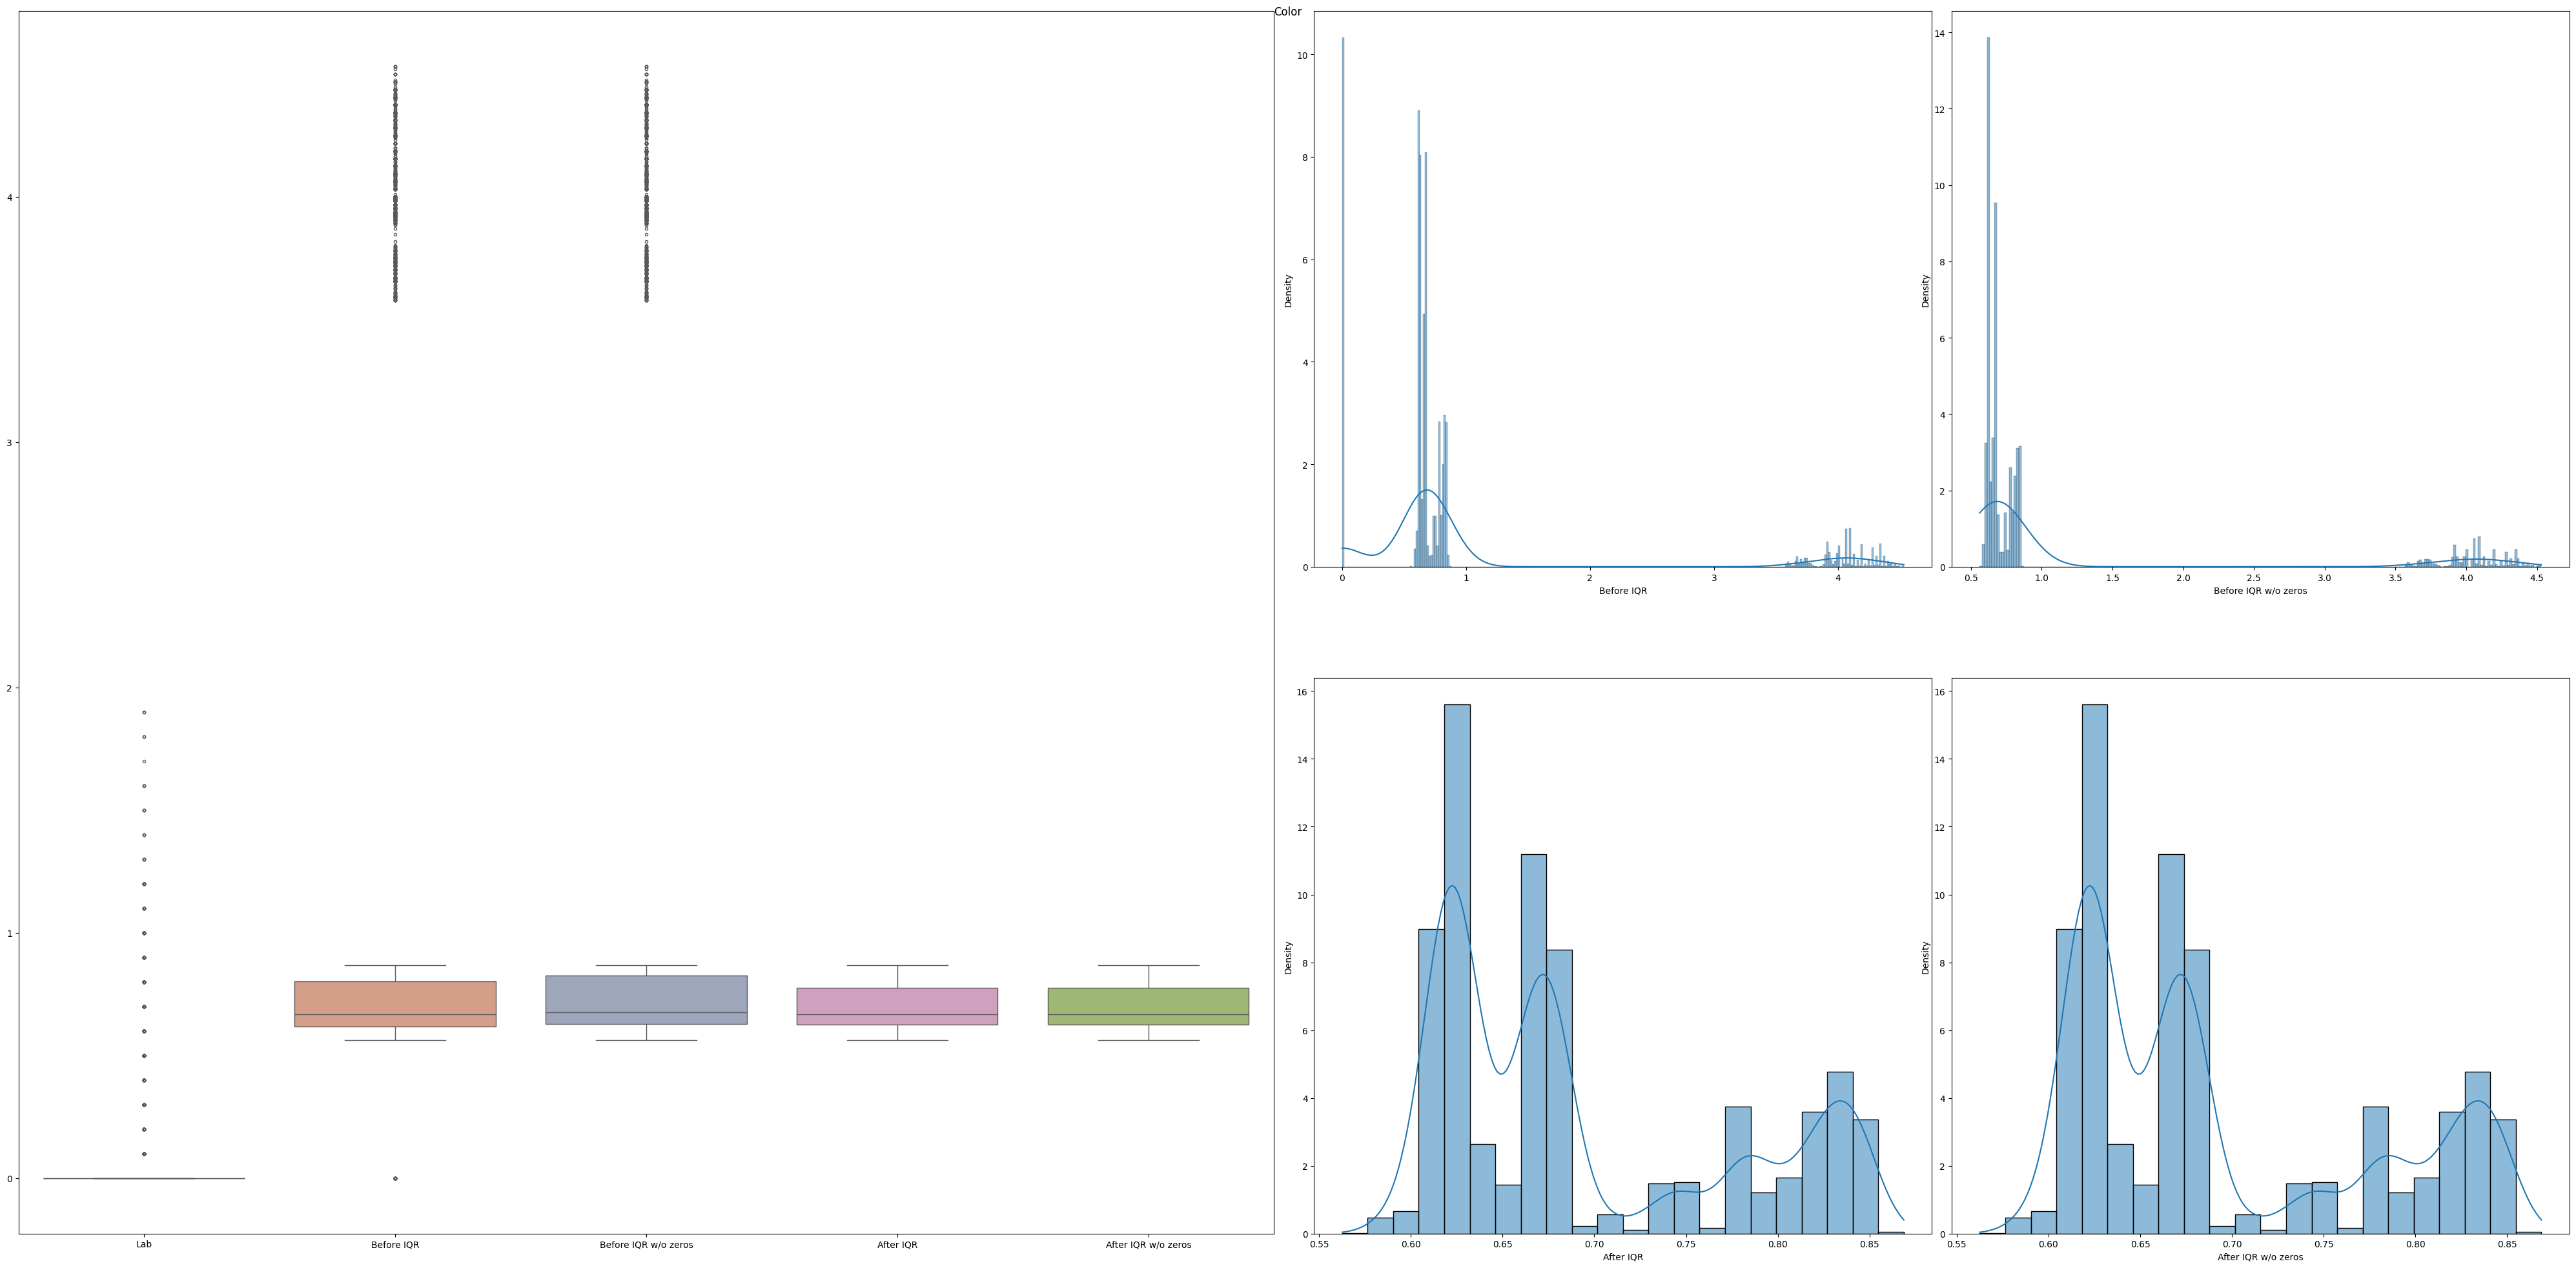

<Figure size 2000x1000 with 0 Axes>

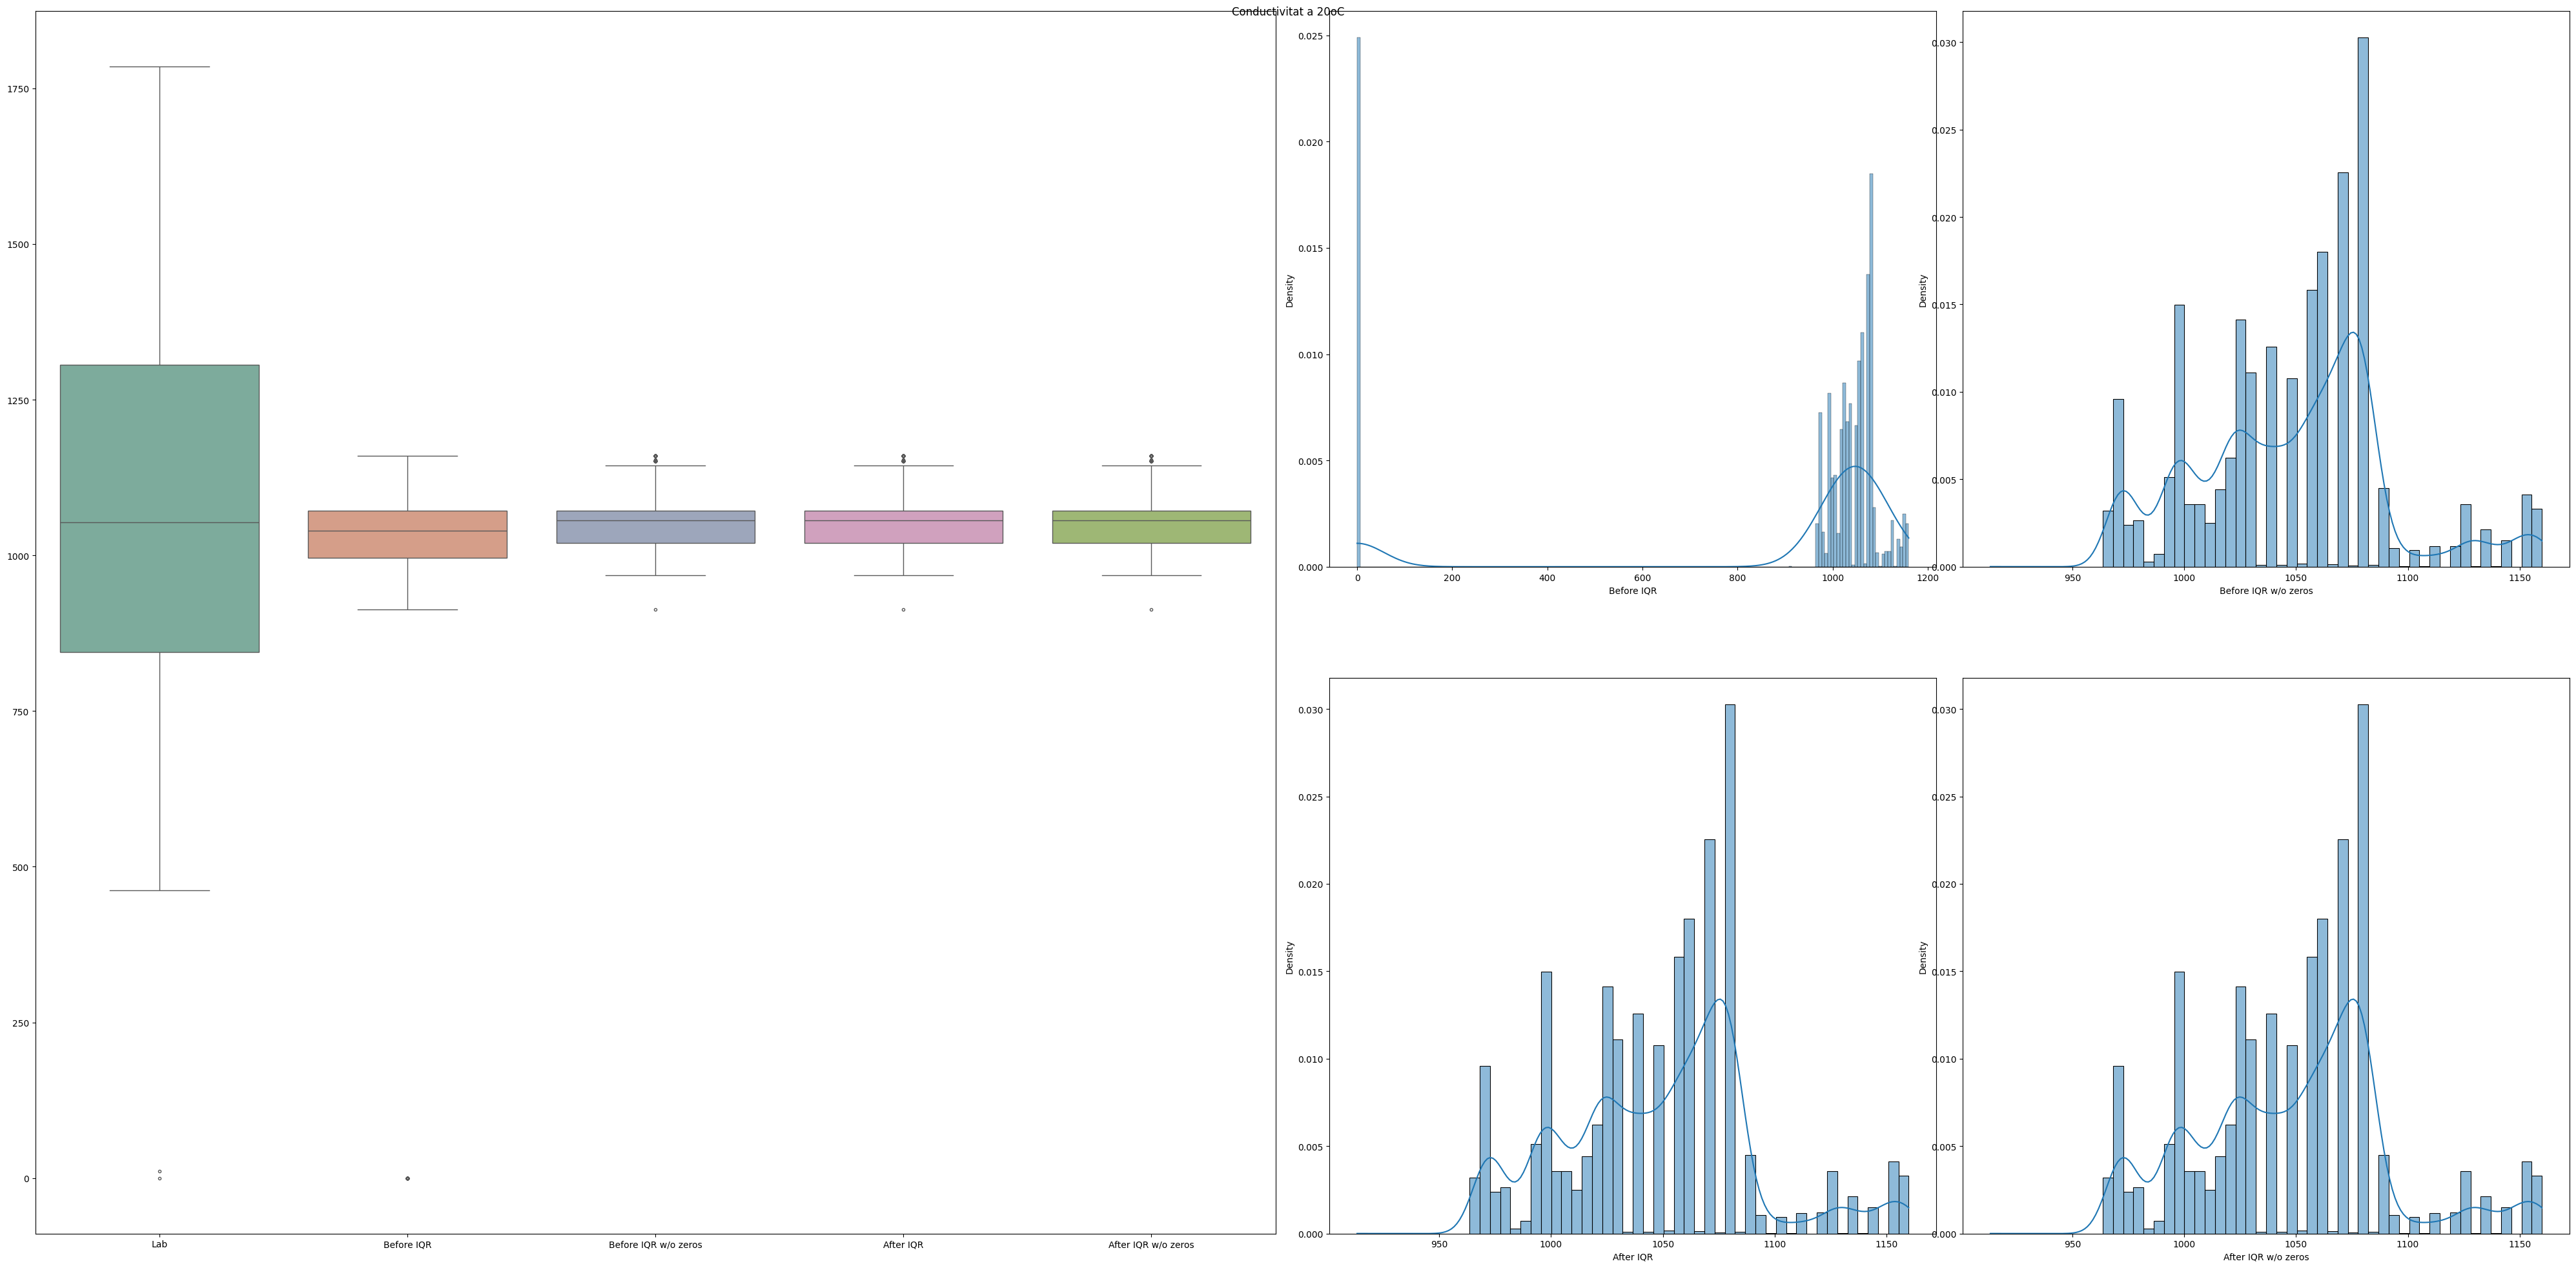

<Figure size 2000x1000 with 0 Axes>

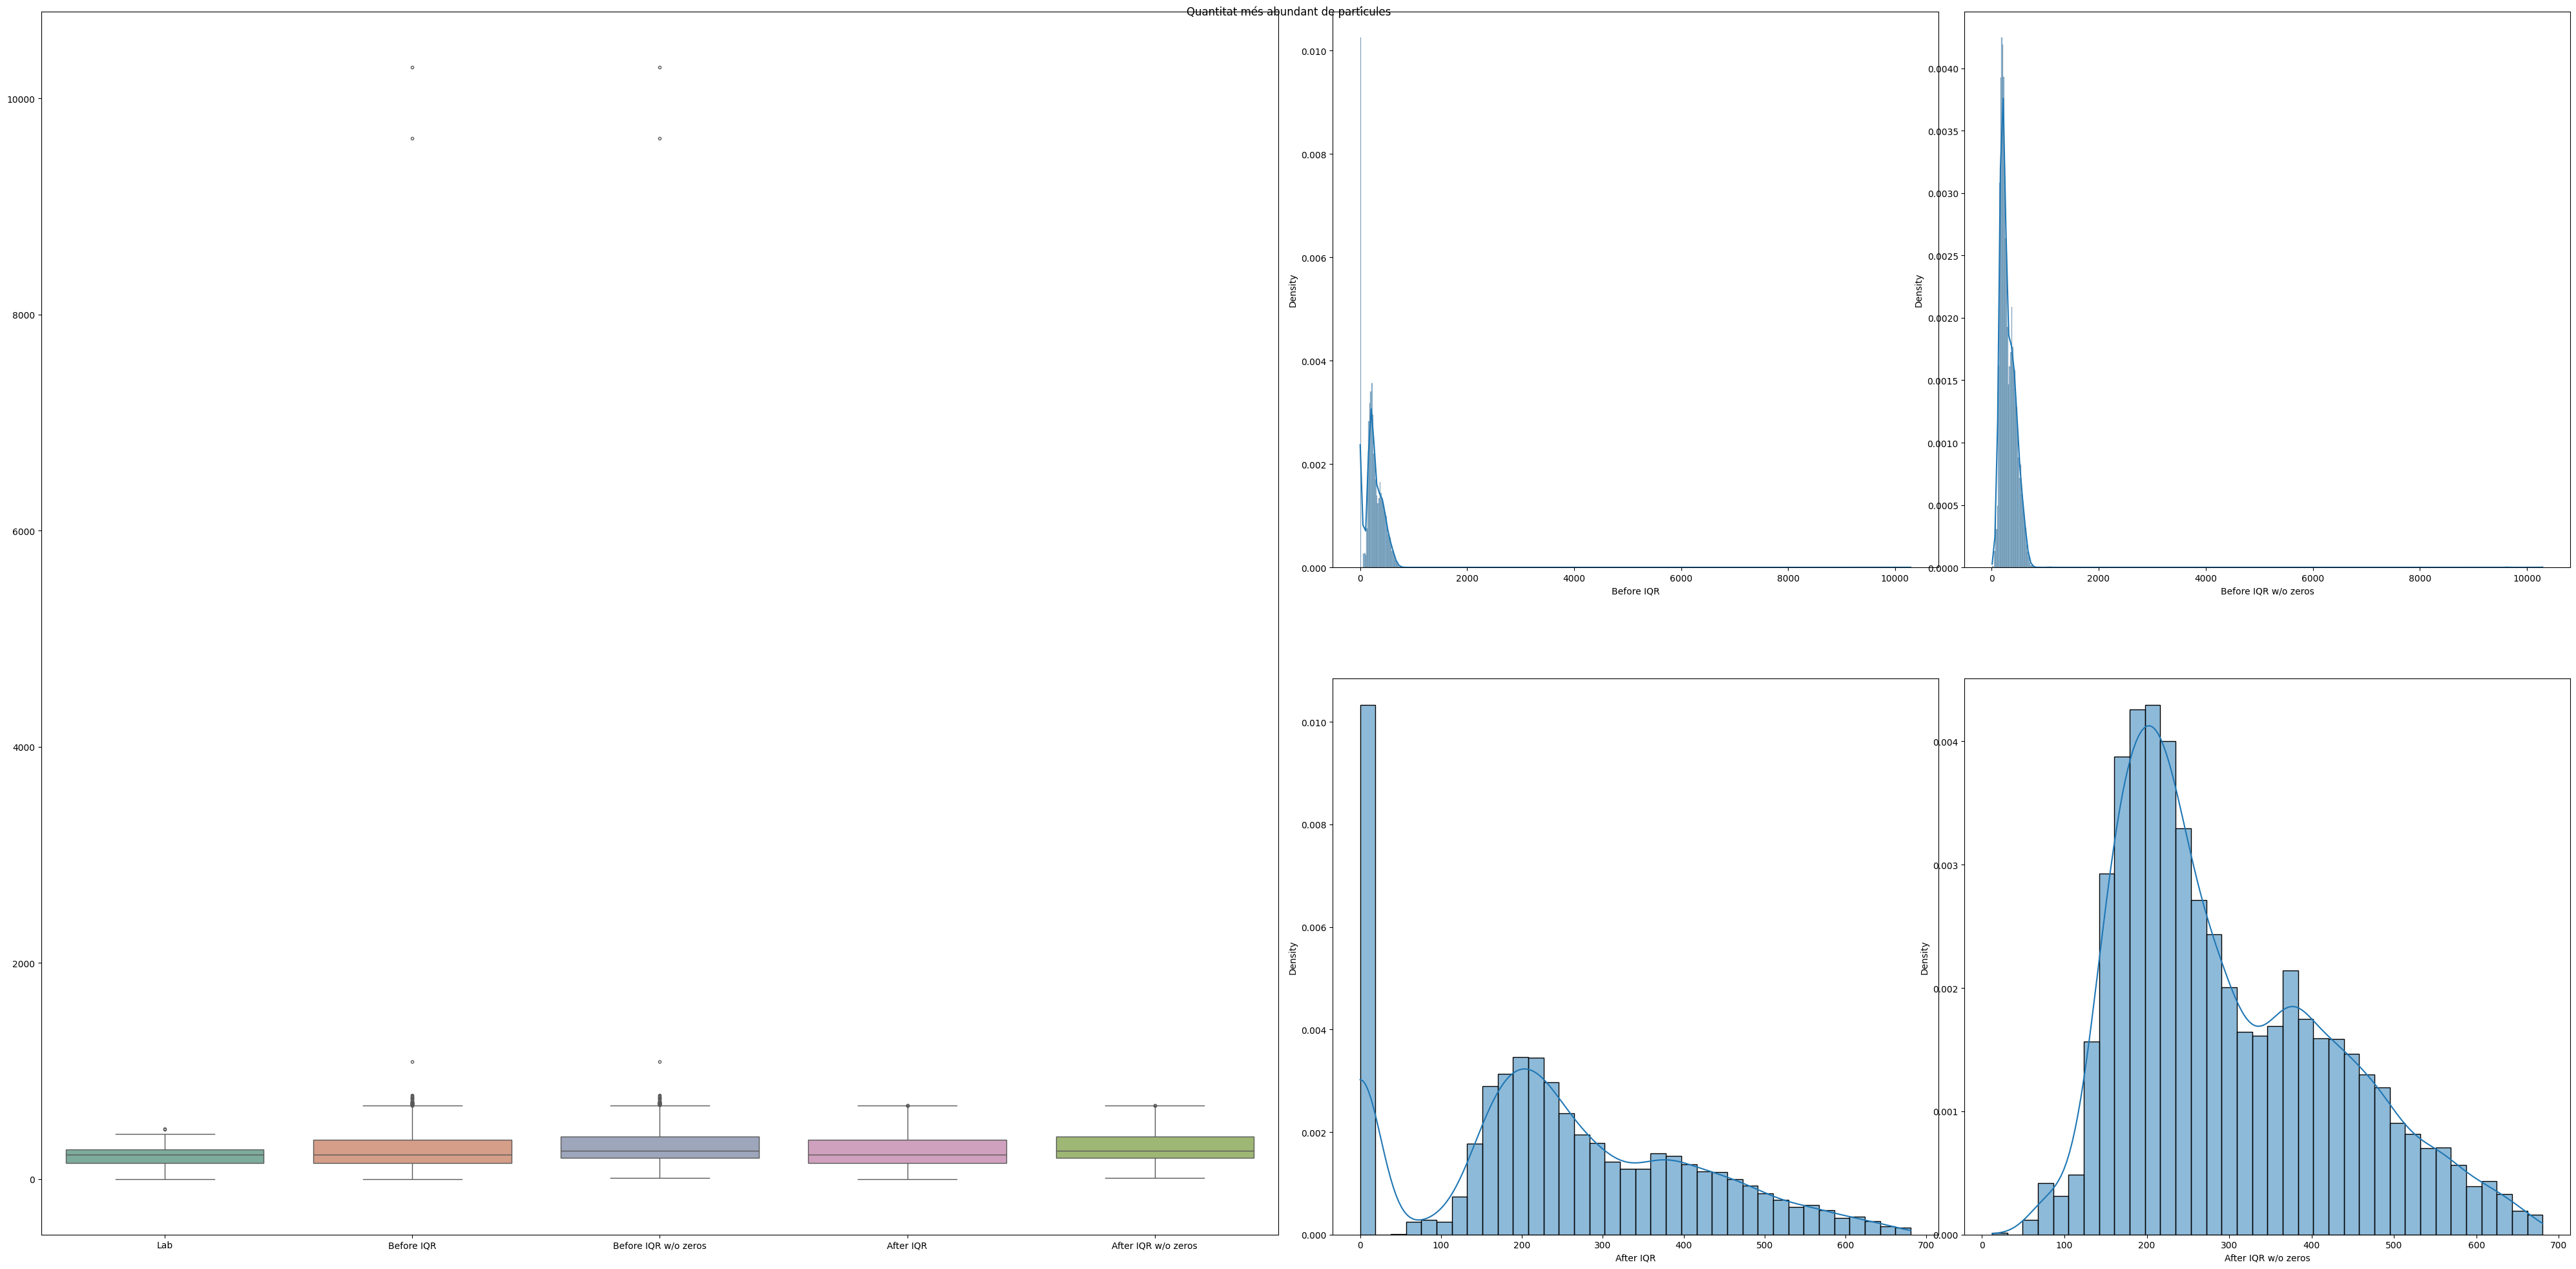

<Figure size 2000x1000 with 0 Axes>

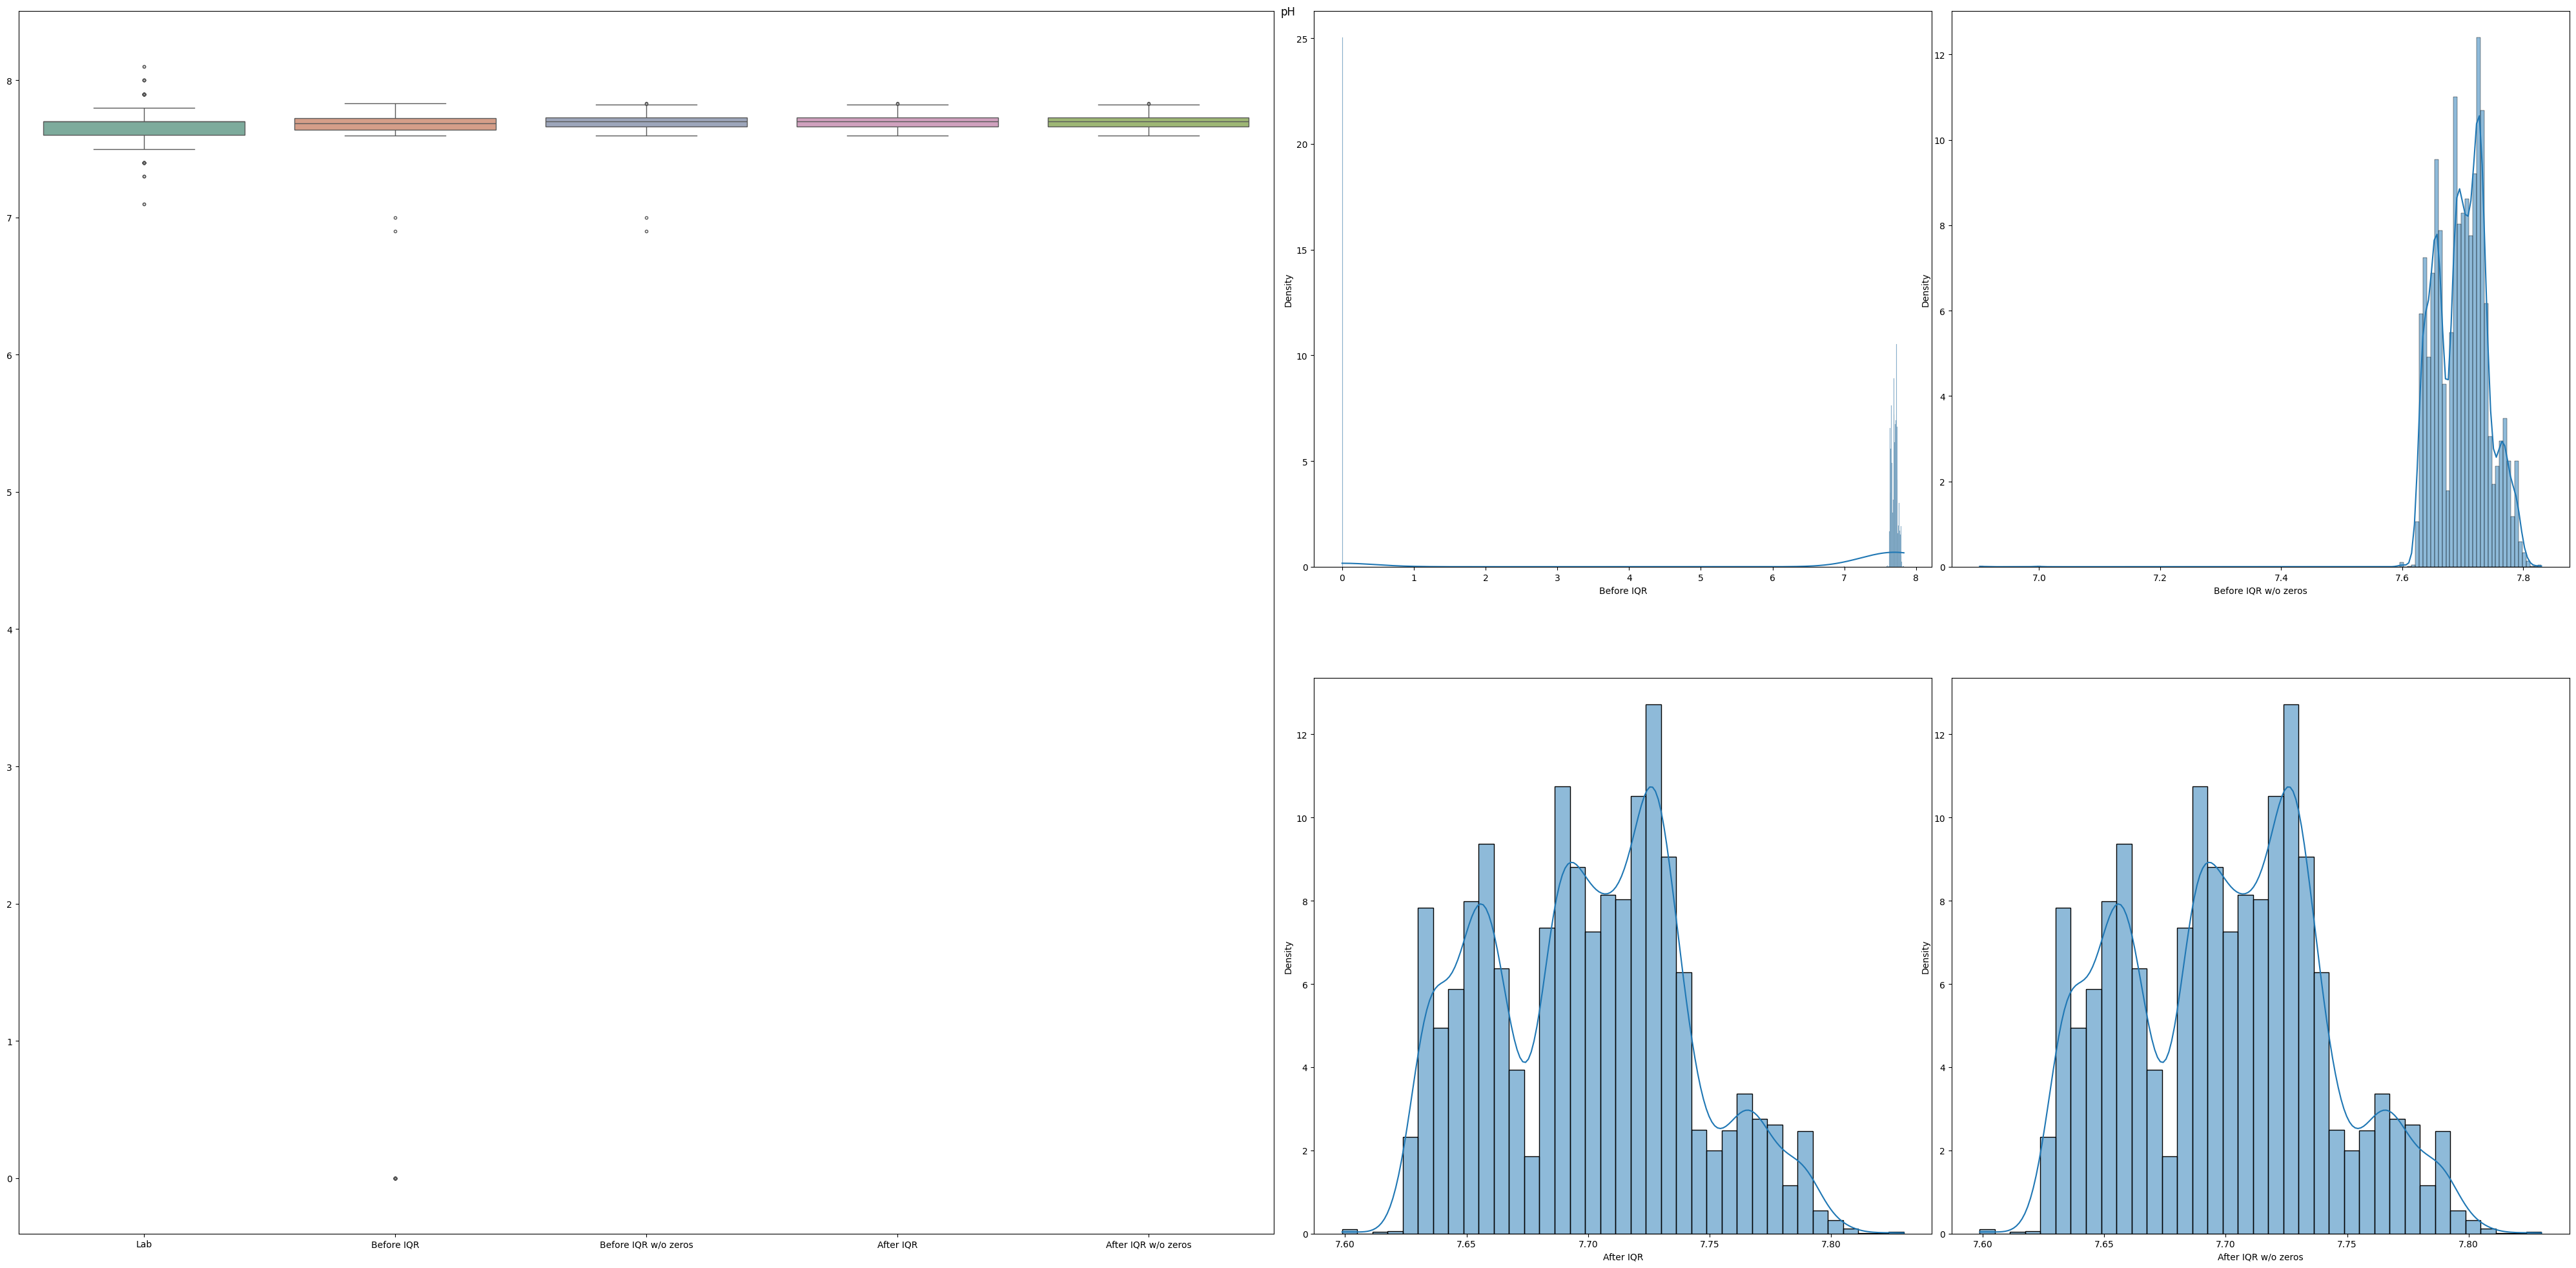

<Figure size 2000x1000 with 0 Axes>

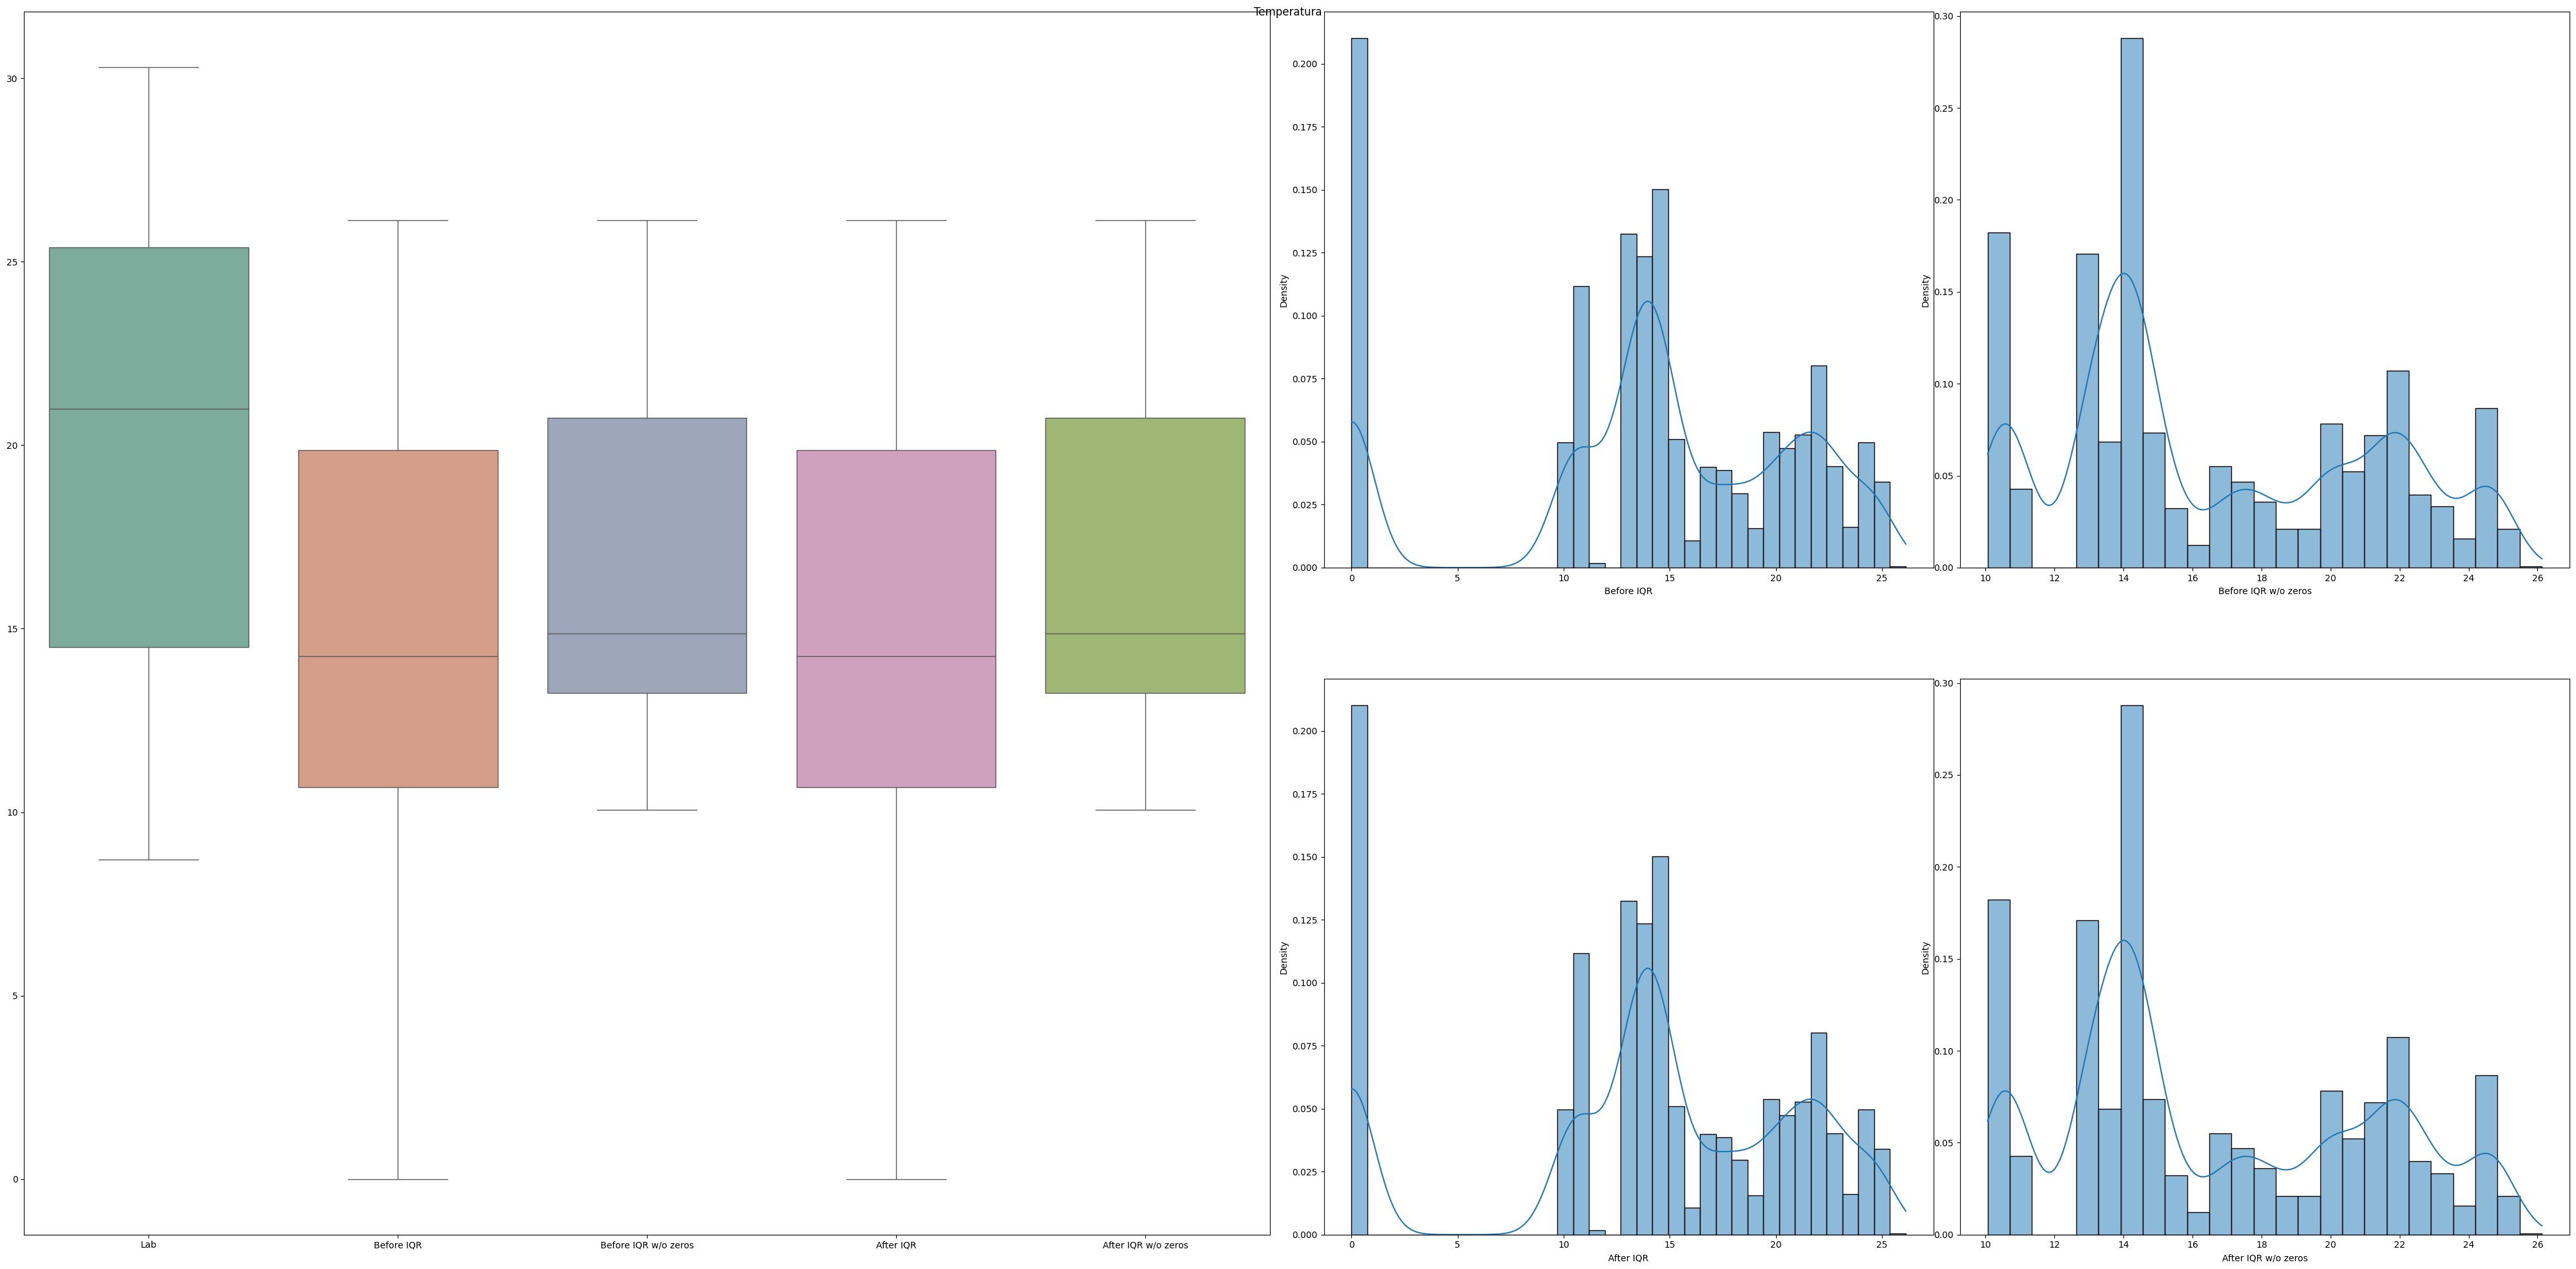

<Figure size 2000x1000 with 0 Axes>

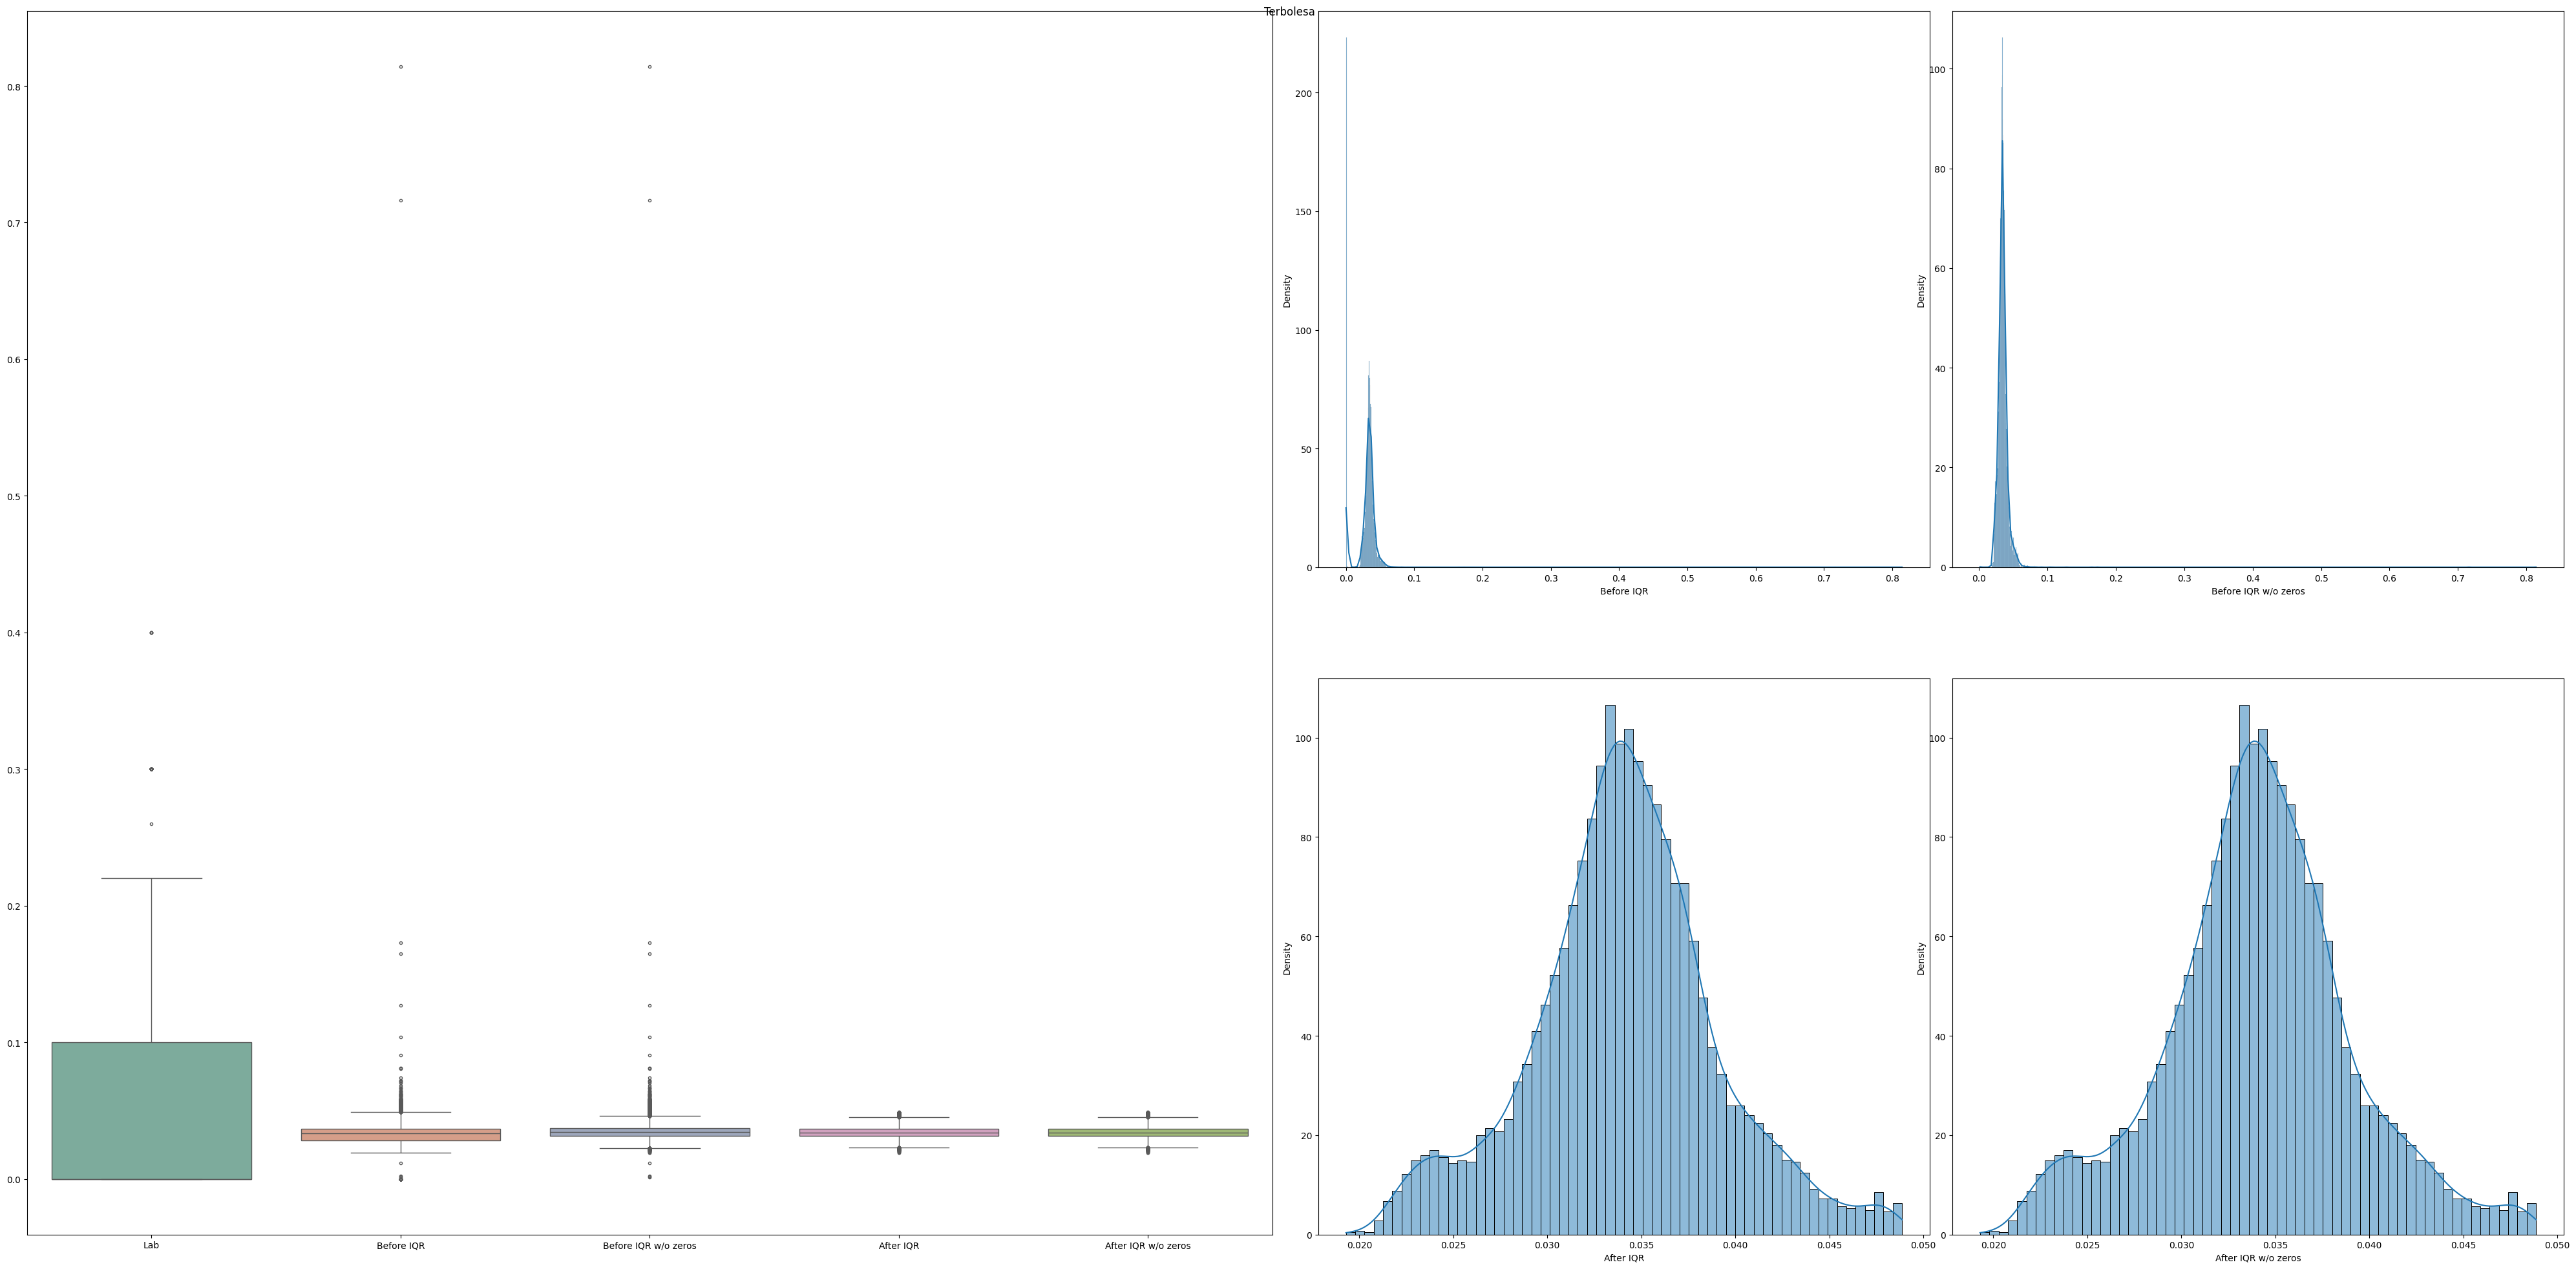

<Figure size 2000x1000 with 0 Axes>

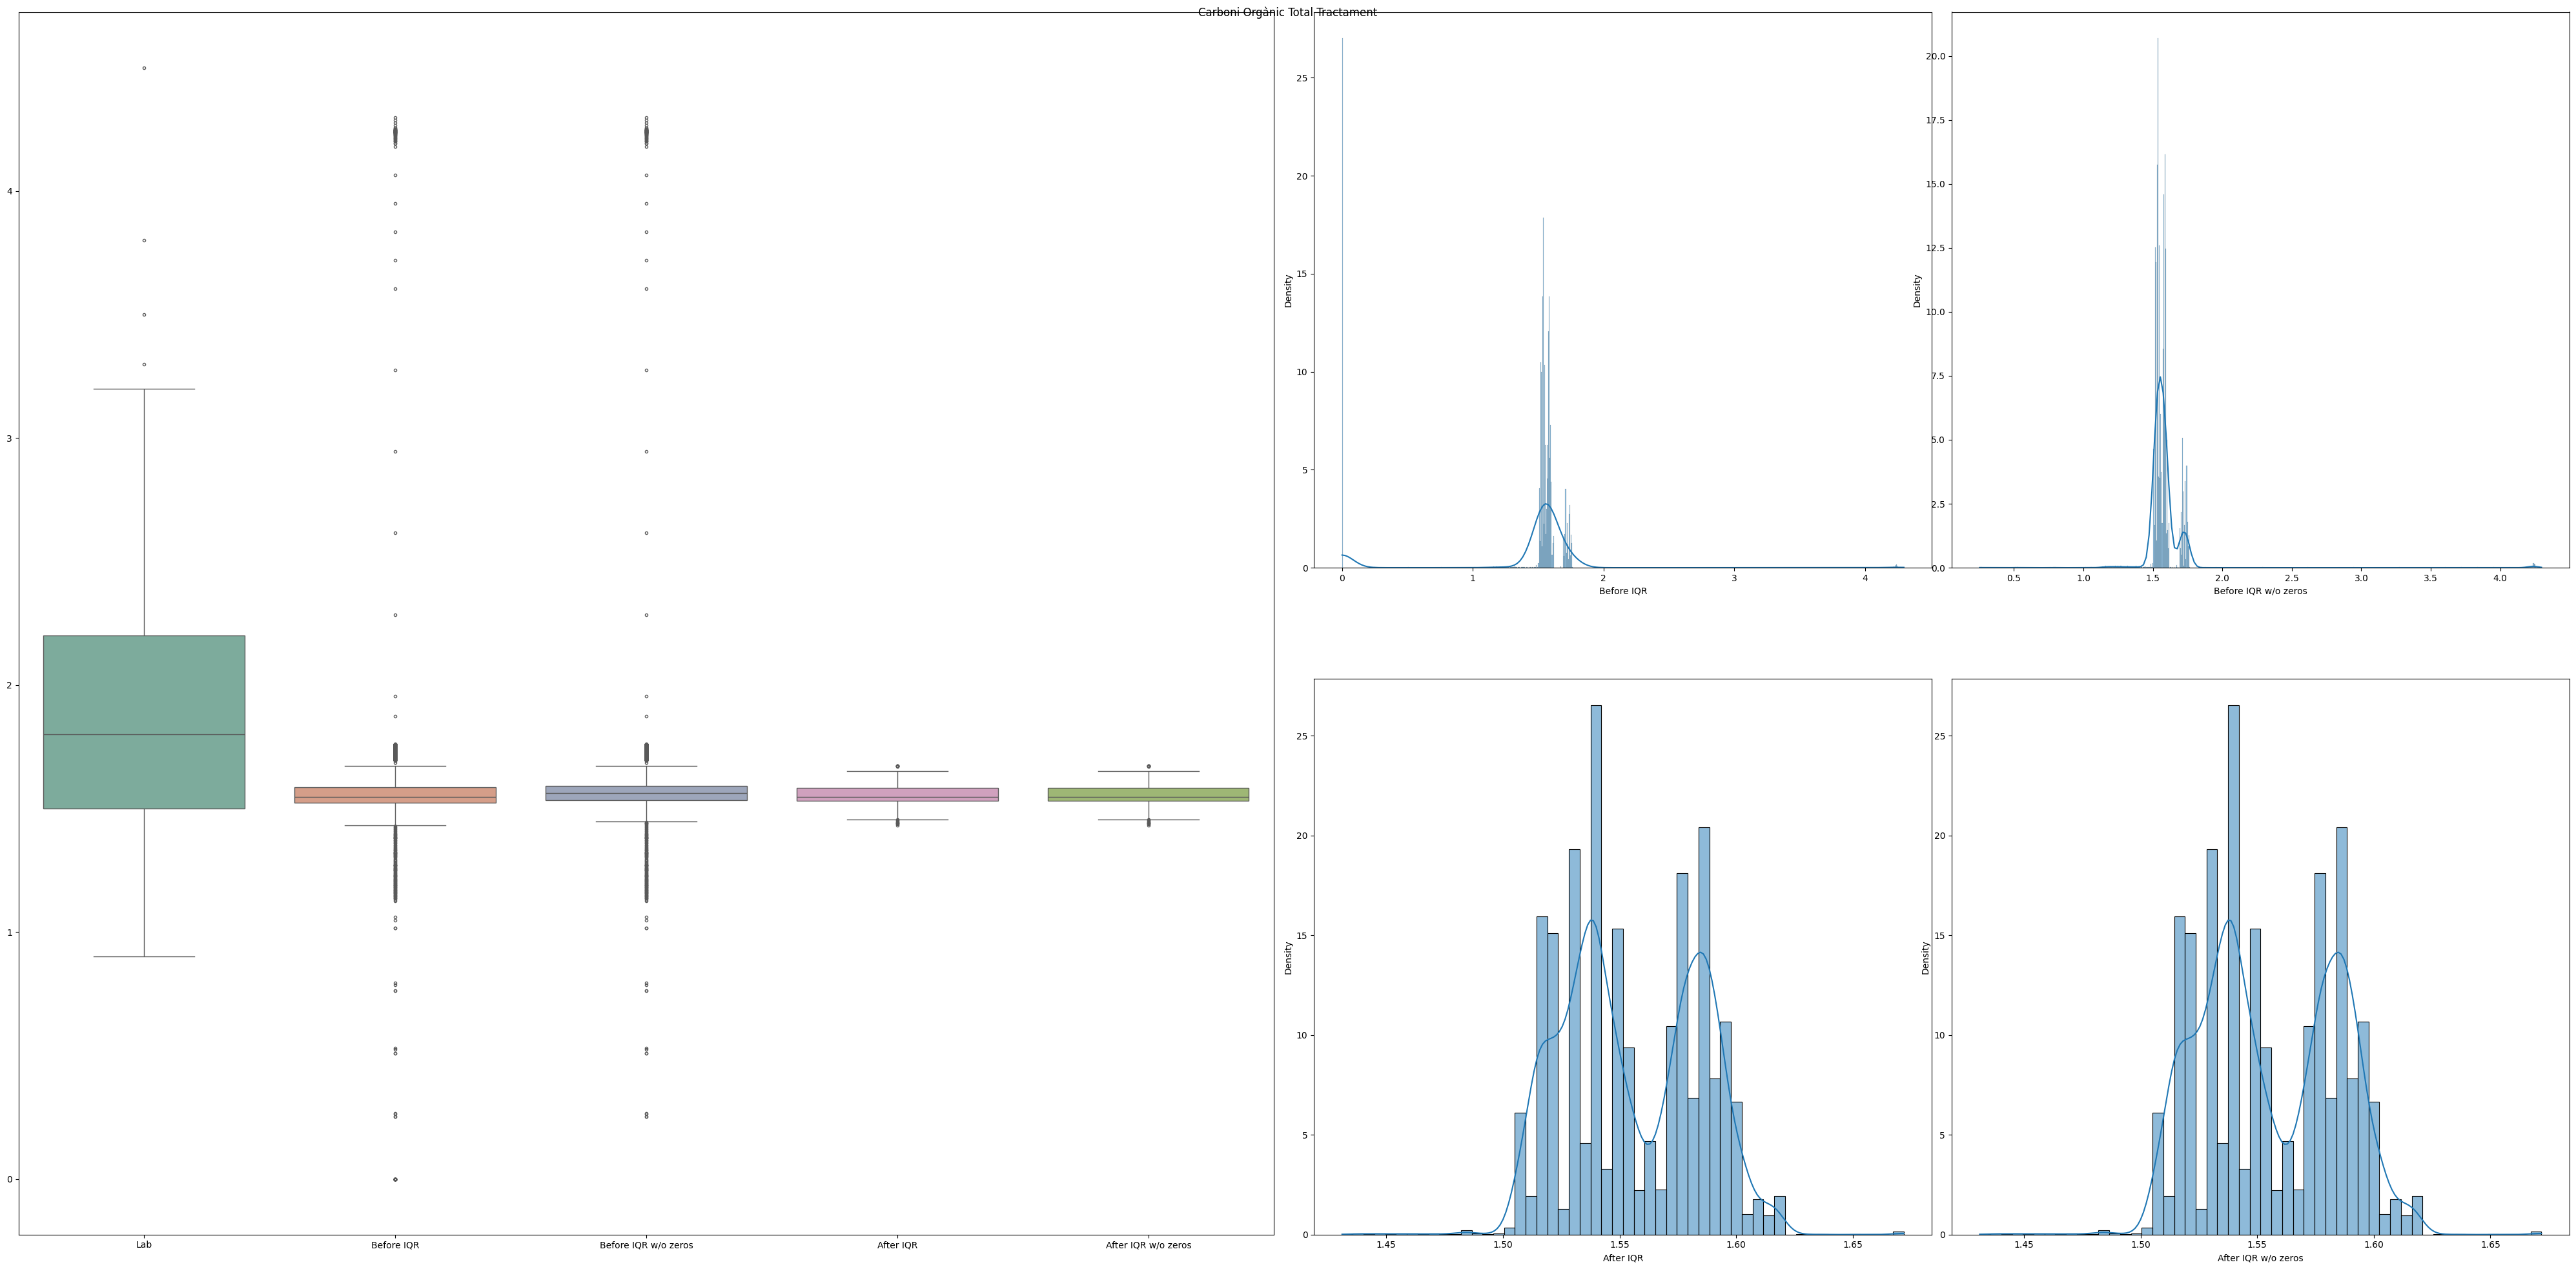

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/safecrew-3OLHM_8n-py3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/safecrew-3OLHM_8n-py3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Figure size 2000x1000 with 0 Axes>

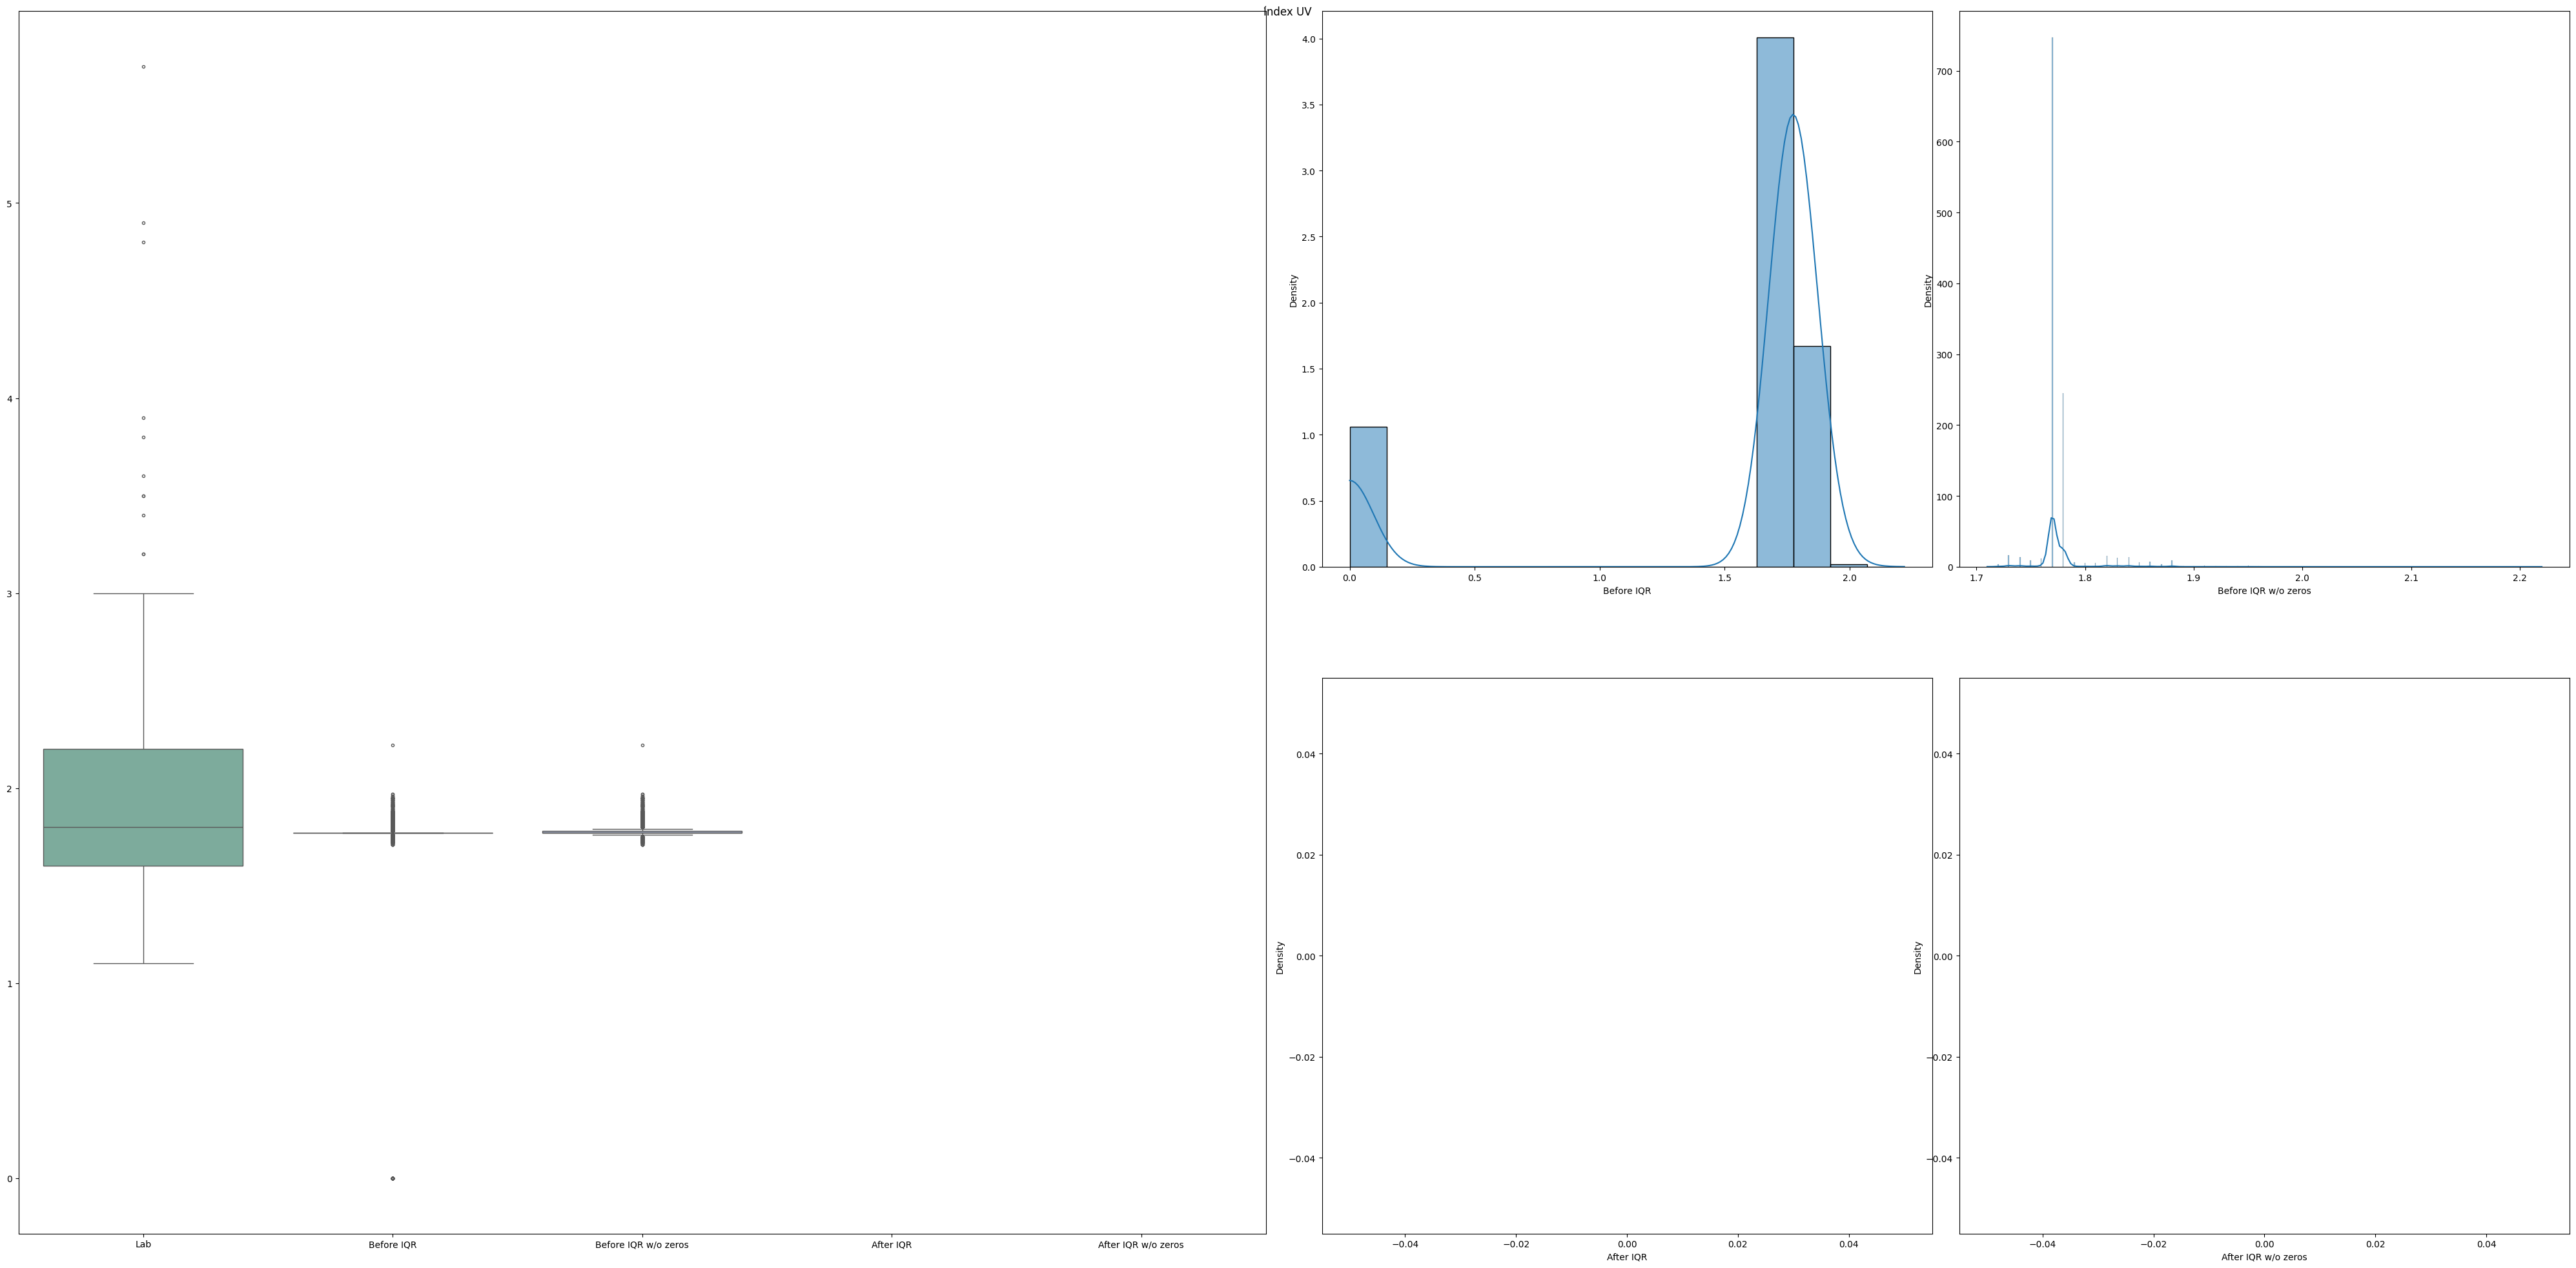

In [34]:
# Try combinations with and without zeros

# Outliers are removed using the IQR method
# NaNs are filled with the capped values

for lab_key, sensor_key in eb1_features_mapping.items():
    plt.figure(figsize=(20, 10))

    quartile1, quartile3 = eb1_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb1_without_zeros = eb1_sensor_df[sensor_key][
        eb1_sensor_df[sensor_key] != 0
    ]

    # Create a temporary DataFrame with the column values before and after the IQR operation
    temp_df = pd.DataFrame(
        {
            "Lab": eb1_features_lab_df[lab_key],
            "Before IQR": eb1_sensor_df[sensor_key],
            "Before IQR w/o zeros": eb1_without_zeros,
            "After IQR": eb1_sensor_df[sensor_key].apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
            "After IQR w/o zeros": eb1_without_zeros.apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
        }
    )

    fig = plt.figure(figsize=(40, 20))
    
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])

    # Plot the temporary DataFrame
    sns.boxplot(
        data=temp_df,
        palette="Set2",
        saturation=0.5,
        whis=1.5,
        fliersize=3,
        ax=fig.add_subplot(gs00[0])
    )
    
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1])

    # Plot a histogram for each column
    for i, column in enumerate(temp_df.columns[1:], start=1):
        sns.histplot(
            data=temp_df[column],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs01[i - 1]),
            label=column
        )
        
    

    plt.suptitle(lab_key)
    plt.tight_layout()
    plt.show()

In [35]:
list(eb1_features_mapping.values())

['CLOR LLIURE',
 'COLOR',
 'CONDUCTIVITAT',
 'PARTICULES',
 'PH',
 'TEMPERATURA',
 'TERBOLESA',
 'TOC',
 'UVA']

In [36]:
# Outliers are removed using the IQR method w/o zeros
for sensor_key in eb1_features_mapping.values():
    
    eb1_sensor_df = eb1_sensor_df[eb1_sensor_df[sensor_key] > 0]

    quartile1, quartile3 = eb1_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb1_sensor_df[sensor_key] = (
        eb1_sensor_df[sensor_key]
        .apply(lambda x: x if (x > lower_bound and x < upper_bound) else None)
    )

# Missing Values

## Lab

### EB0

In [37]:
# NaN count per feature
print(eb0_features_lab_df.isna().sum() / len(eb0_features_lab_df) * 100)
print()
print('Total number of samples: ', len(eb0_features_lab_df))

Unnamed: 0                                  0.000000
DateTime                                    0.000000
Color                                      25.992780
Conductivitat a 20oC                        5.703971
Mercuri                                   100.000000
Quantitat més abundant de partícules     94.151625
Sulfats                                    84.187726
Temperatura                                61.227437
Terbolesa                                   7.436823
pH                                          5.920578
Índex UV                                  92.707581
dtype: float64

Total number of samples:  1385


<Axes: >

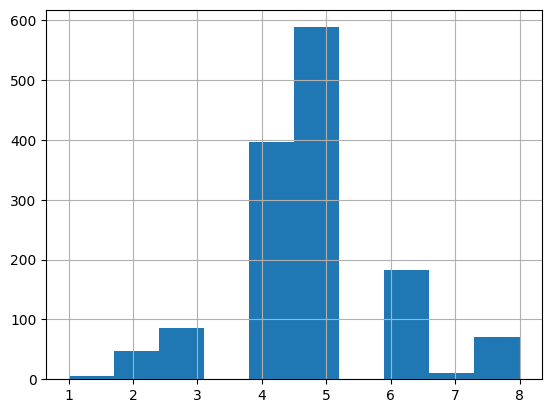

In [38]:
# NaN count per sample
eb0_features_lab_df.isna().sum(axis=1).hist()

In [39]:
# remove features with more than 60% of NaNs
eb0_features_lab_df = eb0_features_lab_df.dropna(thresh=len(eb0_features_lab_df) * 0.6, axis=1)

<Axes: >

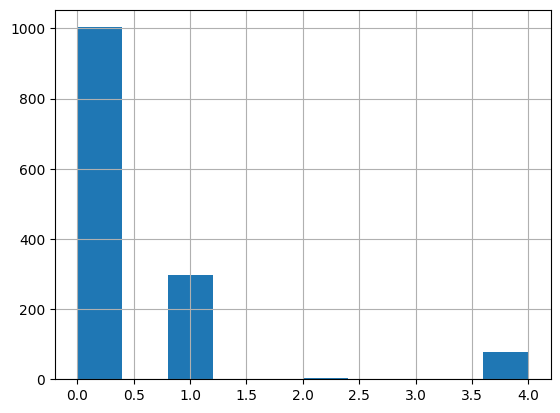

In [40]:
# NaN count per sample
eb0_features_lab_df.isna().sum(axis=1).hist()

In [ ]:
%%script false --no-raise-error
# get columns that have only NaNs
cols = eb0_features_lab_df.columns[eb0_features_lab_df.isna().all()].tolist()

# remove NaNs columns from df and mapping
eb0_features_lab_df = eb0_features_lab_df.drop(columns=cols)
eb0_features_mapping = {k: v for k, v in eb0_features_mapping.items() if k not in cols}

In [46]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Fill NaNs through data imputation with KNN
# for KNN, data must be scaled

scaler = StandardScaler()

eb0_features_lab_df_copy = deepcopy(eb0_features_lab_df)

eb0_features_lab_scaled = scaler.fit_transform(eb0_features_lab_df[eb0_features_lab_df.columns[1:]]) # exclude timestamp
eb0_features_lab_scaled = pd.DataFrame(eb0_features_lab_scaled, columns=scaler.get_feature_names_out())

# find best k for KNN imputation

k_values = np.arange(1, 21)

for k in k_values:
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    eb0_features_lab_imputed = imputer.fit_transform(eb0_features_lab_scaled)
    eb0_features_lab_imputed = pd.DataFrame(eb0_features_lab_imputed, columns=imputer.get_feature_names_out())
    
    eb0_features_lab_df[eb0_features_lab_df.columns[1:]] = scaler.inverse_transform(eb0_features_lab_imputed)
    
    # Plot histograms for each feature before and after imputation
    for lab_key in eb0_features_mapping.keys():
        fig = plt.figure(figsize=(40, 20))
        
        gs0 = gridspec.GridSpec(2, 1, figure=fig)

        gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
        
        sns.histplot(
            data=eb0_features_lab_df_copy[lab_key],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs00[0]),
            color='#dd7100',
            label="Before imputation",
        )
        
        sns.histplot(
            data=eb0_features_lab_df[lab_key],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs00[1]),
            color='#43af14',
            label="After imputation"
        )
        
        gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
        
        sns.lineplot(
            x='DateTime',
            y=lab_key,
            data=eb0_features_lab_df_copy,
            ax=fig.add_subplot(gs01[0]),
            color='#dd7100',
            label="Before imputation"
        )
        
        sns.lineplot(
            x='DateTime',
            y=lab_key,
            data=eb0_features_lab_df,
            ax=fig.add_subplot(gs01[1]),
            color='#43af14',
            label="After imputation"
        )
        
        plt.suptitle('Neighbours: ' + str(k) + ' - ' + lab_key)
        plt.tight_layout()
        plt.show()

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [ ]:
eb0_features_lab_df = deepcopy(eb0_features_lab_df_copy)

scaler = StandardScaler()

eb0_features_lab_scaled = scaler.fit_transform(eb0_features_lab_df[eb0_features_lab_df.columns[1:]]) # exclude timestamp
eb0_features_lab_scaled = pd.DataFrame(eb0_features_lab_scaled, columns=scaler.get_feature_names_out())

imputer = KNNImputer(n_neighbors=k, weights='distance')
eb0_features_lab_imputed = imputer.fit_transform(eb0_features_lab_scaled)
eb0_features_lab_imputed = pd.DataFrame(eb0_features_lab_imputed, columns=imputer.get_feature_names_out())

eb0_features_lab_df[eb0_features_lab_df.columns[1:]] = scaler.inverse_transform(eb0_features_lab_imputed)

### EB1

In [42]:
# NaN count per feature
print(eb1_features_lab_df.isna().sum() / len(eb1_features_lab_df) * 100)
print()
print('Total number of samples: ', len(eb1_features_lab_df))

Unnamed: 0                                 0.000000
DateTime                                   0.000000
Carboni Orgànic Total Tractament         93.349398
Clor lliure residual                       5.349398
Color                                      6.795181
Conductivitat a 20oC                       5.686747
Quantitat més abundant de partícules    95.421687
Temperatura                               71.807229
Terbolesa                                  5.686747
pH                                         5.783133
Índex UV                                 93.060241
dtype: float64

Total number of samples:  2075


<Axes: >

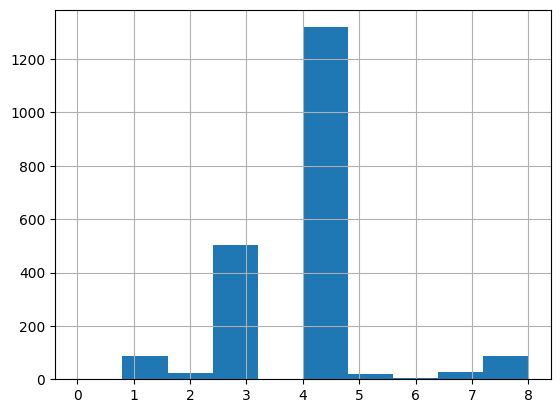

In [43]:
# NaN count per sample
eb1_features_lab_df.isna().sum(axis=1).hist()

In [44]:
# remove features with more than 60% of NaNs
eb1_features_lab_df = eb1_features_lab_df.dropna(thresh=len(eb1_features_lab_df) * 0.6, axis=1)

<Axes: >

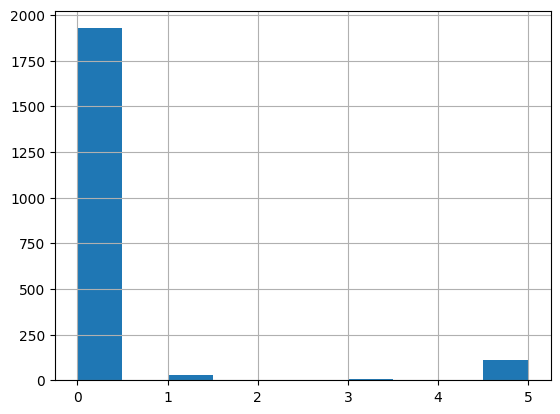

In [45]:
# NaN count per sample
eb1_features_lab_df.isna().sum(axis=1).hist()

In [ ]:
%%script false --no-raise-error

# get columns that have only NaNs
cols = eb1_features_lab_df.columns[eb1_features_lab_df.isna().all()].tolist()

# remove NaNs columns from df and mapping
eb1_features_lab_df = eb1_features_lab_df.drop(columns=cols)
eb1_features_mapping = {k: v for k, v in eb1_features_mapping.items() if k not in cols}

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Fill NaNs through data imputation with KNN
# for KNN, data must be scaled

scaler = StandardScaler()

eb1_features_lab_df_copy = deepcopy(eb1_features_lab_df)

eb1_features_lab_scaled = scaler.fit_transform(eb1_features_lab_df[eb1_features_lab_df.columns[1:]]) # exclude timestamp
eb1_features_lab_scaled = pd.DataFrame(eb1_features_lab_scaled, columns=scaler.get_feature_names_out())

# find best k for KNN imputation

k_values = np.arange(1, 21)

for k in k_values:
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    eb1_features_lab_imputed = imputer.fit_transform(eb1_features_lab_scaled)
    eb1_features_lab_imputed = pd.DataFrame(eb1_features_lab_imputed, columns=imputer.get_feature_names_out())
    
    eb1_features_lab_df[eb1_features_lab_df.columns[1:]] = scaler.inverse_transform(eb1_features_lab_imputed)
    
    # Plot histograms for each feature before and after imputation
    for lab_key in eb1_features_mapping.keys():
        fig = plt.figure(figsize=(40, 20))
        
        gs0 = gridspec.GridSpec(2, 1, figure=fig)

        gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
        
        sns.histplot(
            data=eb1_features_lab_df_copy[lab_key],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs00[0]),
            color='#dd7100',
            label="Before imputation",
        )
        
        sns.histplot(
            data=eb1_features_lab_df[lab_key],
            kde=True,
            stat="density",
            ax=fig.add_subplot(gs00[1]),
            color='#43af14',
            label="After imputation"
        )
        
        gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
        
        sns.lineplot(
            x='DateTime',
            y=lab_key,
            data=eb1_features_lab_df_copy,
            ax=fig.add_subplot(gs01[0]),
            color='#dd7100',
            label="Before imputation"
        )
        
        sns.lineplot(
            x='DateTime',
            y=lab_key,
            data=eb1_features_lab_df,
            ax=fig.add_subplot(gs01[1]),
            color='#43af14',
            label="After imputation"
        )
        
        plt.suptitle('Neighbours: ' + str(k) + ' - ' + lab_key)
        plt.tight_layout()
        plt.show()

In [ ]:
# impute data with k=5
eb1_features_lab_df = deepcopy(eb1_features_lab_df_copy)

scaler = StandardScaler()

eb1_features_lab_scaled = scaler.fit_transform(eb1_features_lab_df[eb1_features_lab_df.columns[1:]]) # exclude timestamp
eb1_features_lab_scaled = pd.DataFrame(eb1_features_lab_scaled, columns=scaler.get_feature_names_out())

imputer = KNNImputer(n_neighbors=k, weights='distance')
eb1_features_lab_imputed = imputer.fit_transform(eb1_features_lab_scaled)
eb1_features_lab_imputed = pd.DataFrame(eb1_features_lab_imputed, columns=imputer.get_feature_names_out())

eb1_features_lab_df[eb1_features_lab_df.columns[1:]] = scaler.inverse_transform(eb1_features_lab_imputed)